In [1]:
# # installs the tutorial package
# !pip install m3_learning --no-deps
# !pip install -i https://test.pypi.org/simple/ IMC20-AI-Tutorial==0.0.4

In [2]:
import numpy as np
from skimage import io
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import inspect

from m3_learning.util.code import print_code


from m3_learning.viz.nn import embeddings, latent_generator
from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn, loss_function
from m3_learning.viz.layout import layout_fig, embedding_maps
from m3_learning.util.data_generators import generate_data

import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

set_style("default")
random_seed(seed=42)

default set for seaborn
default set for matplotlib
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
# Loads dog image
image = io.imread(
    "https://github.com/jagar2/m3_learning/blob/main/m3_learning/Tutorials/Unsupervised_Learning_with_AEs/figs/nala.jpg?raw=true"
)

# Crops dog image
image = image[200:1900:20, 100:1500:20] / 255


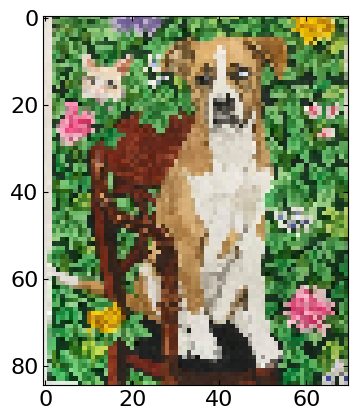

In [4]:
# Plots dog image
plt.imshow(image)


In [5]:
def non_linear_fn(t, x, y, z):
    tanh = nn.Tanh()
    selu = nn.SELU()
    sigmoid = nn.Sigmoid()

    # returns a function from variables
    return (
        tanh(torch.tensor(20 * (t - 2 * (x - 0.5))))
        + selu(torch.tensor((t - 2 * (y - 0.5))))
        + sigmoid(torch.tensor(-20 * (t - (z - 0.5))))
    )


In [6]:
print_code(generate_data)

24: def generate_data(values, function=default_nl_function, length=25, range_=[-1, 1]):
25:   """function to generate data based on an arbitrary function
26: 
27:   Args:
28:       values (array): Input values to use
29:       function (obj, optional): Function to use for generation. Defaults to default_nl_function.
30:       length (int, optional): length of the vector to generate. Defaults to 25.
31:       range_ (list, optional): range of spectra where you generate data. Defaults to [-1, 1].
32: 
33:   Returns:
34:       array: computed spectra
35:   """
36:   # build x vector
37:   x = np.linspace(range_[0], range_[1], length)
38: 
39:   data = np.zeros((values.shape[0], length))
40: 
41:   for i in range(values.shape[0]):
42:       data[i, :] = function(x, values[i, 0], values[i, 1], values[i, 2])
43: 
44:   return data
45: 


In [7]:
# generates a hyperspectral image
dog_data = generate_data(image.reshape(-1, 3),
                         length=10, function=non_linear_fn)


In [8]:
# Conducts a test train split.
# because we are training an autoencoder x and y are the same
X_train, X_test, _, _ = train_test_split(
    dog_data, dog_data, test_size=0.2, random_state=42
)


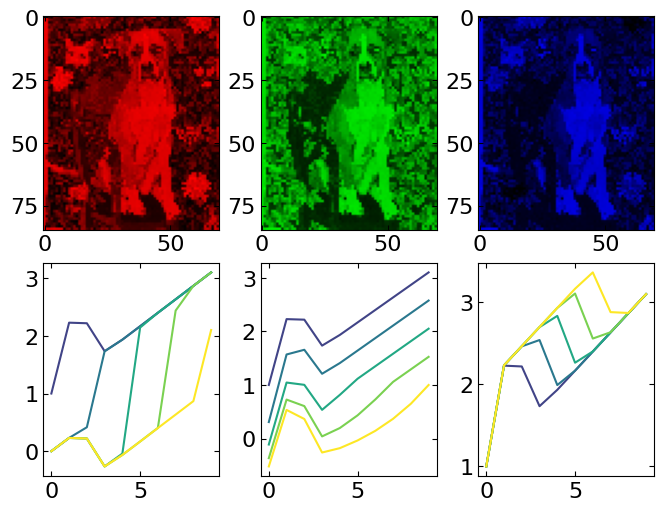

In [9]:
fig, ax = layout_fig(6, mod=3, figsize=(10, 5))

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    # for the first three plots we plot the image
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        # for the last three plots we plot the hyperspectral image
        values = np.zeros((5, 3))
        
        # generates 5 linearly spaced values between 0 and 1
        values[:, i - 3] = np.linspace(0, 1, 5)
        
        # generates the spectra 
        y_data = generate_data(values, length=10)
        
        for j in range(y_data.shape[0]):
            
            # computes the colormap for each spectra based on the value
            color = cmap((j + 1) / y_data.shape[0])
            
            # plots the data
            ax.plot(y_data[j], c=color)


In [10]:
# sets the number of latent dimensions for the autoencoder
latent_dim = 12


class Encoder(nn.Module):
    """Encoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.dense_1 = nn.Linear(10, self.latent_dim)

    def forward(self, x):
        # single dense layer in the model
        x = self.dense_1(x)
        return x


class Decoder(nn.Module):
    """Decoder class for the autoencoder"""
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.dense_1 = nn.Linear(self.latent_dim, 10)

    def forward(self, x):
        # single dense layer in the decoder
        x = self.dense_1(x)
        return x


In [11]:
class Autoencoder(nn.Module):
    """
    Autoencoder class that combines the encoder and decoder
    """
    
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        # encode
        embedding = self.encoder(x)
        # decode
        predicted = self.decoder(embedding)

        return predicted


In [12]:
import cpuinfo

cpudata = cpuinfo.get_cpu_info()["brand_raw"]
cpuname = cpudata.split(" ")[1]

# choose a device based on your system 
if cpuname == "M1":
    device = "mps"
elif torch.cuda.device_count():
    device = "cuda"
else:
    device = "cpu"

print(f"You are running on a {device}")

# builds the encode, decoder, and autoencoder
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


You are running on a cuda


In [13]:
# prints the model structure

try:
    summary(model, ((X_train.shape[1:])))
except:
    model_cpu = copy.deepcopy(model).to("cpu")
    summary(model_cpu, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
           Encoder-2                   [-1, 12]               0
            Linear-3                   [-1, 10]             130
           Decoder-4                   [-1, 10]               0
Total params: 262
Trainable params: 262
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [14]:

# builds a dataloader
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


In [15]:
print_code(Train)

201: def Train(
202:     model,
203:     encoder,
204:     decoder,
205:     train_iterator,
206:     optimizer,
207:     epochs,
208:     coef=0,
209:     coef_1=0,
210:     ln_parm=1,
211:     beta=None,
212:     mse=True,
213:     device="cuda",
214:     save_weight = False,
215: ):
216:     """Function that trains the model
217: 
218:     Args:
219:         model (Pytorch model): autoencoder model
220:         encoder (PyTorch model): encoder of the mode
221:         decoder (PyTorch model): decoder of the model
222:         train_iterator (iter): iterator used from straining
223:         optimizer (obj): optimization methods used
224:         epochs (int): number of epochs
225:         coef (int, optional): used to set the lambda value of the regularization. Defaults to 0.
226:         coef1 (int, optional): not implemented. Defaults to 0.
227:         ln_parm (int, optional): norm value. Defaults to 1.
228:         beta (float, optional): beta for variational autoencoder. Default

In [16]:
# fixes the seed
random_seed(seed=42)

# trains the model
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.68it/s]

Epoch 0, Train Loss: 2.0557
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.81it/s]

Epoch 1, Train Loss: 1.8709
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 607.79it/s]

Epoch 2, Train Loss: 1.7014
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 567.90it/s]

Epoch 3, Train Loss: 1.5465
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 635.13it/s]

Epoch 4, Train Loss: 1.3983
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.57it/s]

Epoch 5, Train Loss: 1.2586
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 607.31it/s]

Epoch 6, Train Loss: 1.1299
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.74it/s]

Epoch 7, Train Loss: 1.0058
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.25it/s]

Epoch 8, Train Loss: 0.8919
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.03it/s]

Epoch 9, Train Loss: 0.7870
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.96it/s]

Epoch 10, Train Loss: 0.6910
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.84it/s]

Epoch 11, Train Loss: 0.6044
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.51it/s]

Epoch 12, Train Loss: 0.5278
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.03it/s]

Epoch 13, Train Loss: 0.4611
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.12it/s]

Epoch 14, Train Loss: 0.4038
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.96it/s]

Epoch 15, Train Loss: 0.3553
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.46it/s]

Epoch 16, Train Loss: 0.3155
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.68it/s]

Epoch 17, Train Loss: 0.2828
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 530.33it/s]

Epoch 18, Train Loss: 0.2565
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.53it/s]

Epoch 19, Train Loss: 0.2355


.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 482.69it/s]

Epoch 20, Train Loss: 0.2191
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 539.82it/s]

Epoch 21, Train Loss: 0.2055
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.09it/s]

Epoch 22, Train Loss: 0.1945
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 624.61it/s]

Epoch 23, Train Loss: 0.1857
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.84it/s]

Epoch 24, Train Loss: 0.1780
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 481.81it/s]

Epoch 25, Train Loss: 0.1714
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.16it/s]

Epoch 26, Train Loss: 0.1664
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 649.63it/s]

Epoch 27, Train Loss: 0.1614
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 630.06it/s]

Epoch 28, Train Loss: 0.1573
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.48it/s]

Epoch 29, Train Loss: 0.1535
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.45it/s]

Epoch 30, Train Loss: 0.1501
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.12it/s]

Epoch 31, Train Loss: 0.1467
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.87it/s]

Epoch 32, Train Loss: 0.1440
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 616.67it/s]

Epoch 33, Train Loss: 0.1412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 640.25it/s]

Epoch 34, Train Loss: 0.1385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 631.53it/s]

Epoch 35, Train Loss: 0.1361
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.24it/s]

Epoch 36, Train Loss: 0.1338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.90it/s]

Epoch 37, Train Loss: 0.1314
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.98it/s]

Epoch 38, Train Loss: 0.1291
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 535.60it/s]

Epoch 39, Train Loss: 0.1268
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 558.47it/s]

Epoch 40, Train Loss: 0.1245
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.84it/s]

Epoch 41, Train Loss: 0.1225
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 536.51it/s]

Epoch 42, Train Loss: 0.1204
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.42it/s]

Epoch 43, Train Loss: 0.1181
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 475.46it/s]

Epoch 44, Train Loss: 0.1161
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 515.72it/s]

Epoch 45, Train Loss: 0.1140
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 478.21it/s]

Epoch 46, Train Loss: 0.1121
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 526.47it/s]

Epoch 47, Train Loss: 0.1099
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 551.24it/s]

Epoch 48, Train Loss: 0.1081
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 506.74it/s]

Epoch 49, Train Loss: 0.1062
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 539.08it/s]

Epoch 50, Train Loss: 0.1044
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.35it/s]

Epoch 51, Train Loss: 0.1024
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.99it/s]

Epoch 52, Train Loss: 0.1005
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 580.37it/s]

Epoch 53, Train Loss: 0.0986
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.74it/s]

Epoch 54, Train Loss: 0.0969
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 632.25it/s]

Epoch 55, Train Loss: 0.0949
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.03it/s]

Epoch 56, Train Loss: 0.0933
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.18it/s]

Epoch 57, Train Loss: 0.0914
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 643.40it/s]

Epoch 58, Train Loss: 0.0897
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 640.09it/s]

Epoch 59, Train Loss: 0.0880
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 656.76it/s]

Epoch 60, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 542.77it/s]

Epoch 61, Train Loss: 0.0847
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 650.74it/s]

Epoch 62, Train Loss: 0.0831
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 647.17it/s]

Epoch 63, Train Loss: 0.0816
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581.16it/s]

Epoch 64, Train Loss: 0.0801
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.28it/s]

Epoch 65, Train Loss: 0.0784
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 536.66it/s]

Epoch 66, Train Loss: 0.0771
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.41it/s]

Epoch 67, Train Loss: 0.0755
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.93it/s]

Epoch 68, Train Loss: 0.0743
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.95it/s]

Epoch 69, Train Loss: 0.0727
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 589.34it/s]

Epoch 70, Train Loss: 0.0713
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.60it/s]

Epoch 71, Train Loss: 0.0701
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 623.67it/s]

Epoch 72, Train Loss: 0.0689
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.19it/s]

Epoch 73, Train Loss: 0.0676
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.72it/s]

Epoch 74, Train Loss: 0.0664
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 635.08it/s]

Epoch 75, Train Loss: 0.0651
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 543.35it/s]

Epoch 76, Train Loss: 0.0639
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.70it/s]

Epoch 77, Train Loss: 0.0628
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 511.43it/s]

Epoch 78, Train Loss: 0.0618
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 498.56it/s]

Epoch 79, Train Loss: 0.0607
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.75it/s]

Epoch 80, Train Loss: 0.0597
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.12it/s]

Epoch 81, Train Loss: 0.0586
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 568.96it/s]

Epoch 82, Train Loss: 0.0577
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.15it/s]

Epoch 83, Train Loss: 0.0568
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.61it/s]

Epoch 84, Train Loss: 0.0558
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.91it/s]

Epoch 85, Train Loss: 0.0549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 570.41it/s]

Epoch 86, Train Loss: 0.0539
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 630.31it/s]

Epoch 87, Train Loss: 0.0531
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.63it/s]

Epoch 88, Train Loss: 0.0524
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 663.93it/s]

Epoch 89, Train Loss: 0.0515
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 635.82it/s]

Epoch 90, Train Loss: 0.0507
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.53it/s]

Epoch 91, Train Loss: 0.0500
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 535.23it/s]

Epoch 92, Train Loss: 0.0492
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.07it/s]

Epoch 93, Train Loss: 0.0484
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 518.46it/s]

Epoch 94, Train Loss: 0.0477
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.78it/s]

Epoch 95, Train Loss: 0.0470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 632.16it/s]

Epoch 96, Train Loss: 0.0463
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.92it/s]

Epoch 97, Train Loss: 0.0457
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.47it/s]

Epoch 98, Train Loss: 0.0451
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 672.39it/s]

Epoch 99, Train Loss: 0.0445
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.19it/s]

Epoch 100, Train Loss: 0.0437
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 637.25it/s]

Epoch 101, Train Loss: 0.0431
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 632.48it/s]

Epoch 102, Train Loss: 0.0425
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 534.21it/s]

Epoch 103, Train Loss: 0.0420
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 515.68it/s]

Epoch 104, Train Loss: 0.0415
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.21it/s]

Epoch 105, Train Loss: 0.0409
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 528.65it/s]

Epoch 106, Train Loss: 0.0403
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 533.21it/s]

Epoch 107, Train Loss: 0.0397
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 570.33it/s]

Epoch 108, Train Loss: 0.0392
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 505.82it/s]

Epoch 109, Train Loss: 0.0388
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 608.31it/s]

Epoch 110, Train Loss: 0.0382
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 614.71it/s]

Epoch 111, Train Loss: 0.0378
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.02it/s]

Epoch 112, Train Loss: 0.0373
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 613.61it/s]

Epoch 113, Train Loss: 0.0369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.26it/s]

Epoch 114, Train Loss: 0.0365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 587.78it/s]

Epoch 115, Train Loss: 0.0359
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 614.46it/s]

Epoch 116, Train Loss: 0.0354
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.55it/s]

Epoch 117, Train Loss: 0.0350
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.23it/s]

Epoch 118, Train Loss: 0.0346
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.40it/s]

Epoch 119, Train Loss: 0.0341
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.73it/s]

Epoch 120, Train Loss: 0.0338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 542.78it/s]

Epoch 121, Train Loss: 0.0333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 490.80it/s]

Epoch 122, Train Loss: 0.0330
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 534.79it/s]

Epoch 123, Train Loss: 0.0326
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 485.04it/s]

Epoch 124, Train Loss: 0.0321
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 513.62it/s]

Epoch 125, Train Loss: 0.0318
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 505.44it/s]

Epoch 126, Train Loss: 0.0314
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.14it/s]

Epoch 127, Train Loss: 0.0311
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.23it/s]

Epoch 128, Train Loss: 0.0307
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.11it/s]

Epoch 129, Train Loss: 0.0304
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.42it/s]

Epoch 130, Train Loss: 0.0300
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.16it/s]

Epoch 131, Train Loss: 0.0297
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 644.49it/s]

Epoch 132, Train Loss: 0.0294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.66it/s]

Epoch 133, Train Loss: 0.0290
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 623.10it/s]

Epoch 134, Train Loss: 0.0287
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.47it/s]

Epoch 135, Train Loss: 0.0283
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.74it/s]

Epoch 136, Train Loss: 0.0280
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 498.74it/s]

Epoch 137, Train Loss: 0.0278
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.26it/s]

Epoch 138, Train Loss: 0.0274
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.64it/s]

Epoch 139, Train Loss: 0.0271
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 626.60it/s]

Epoch 140, Train Loss: 0.0268
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 592.49it/s]

Epoch 141, Train Loss: 0.0266
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 568.15it/s]

Epoch 142, Train Loss: 0.0262
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.79it/s]

Epoch 143, Train Loss: 0.0259
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.92it/s]

Epoch 144, Train Loss: 0.0257
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 638.92it/s]

Epoch 145, Train Loss: 0.0254
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.80it/s]

Epoch 146, Train Loss: 0.0252
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 606.92it/s]

Epoch 147, Train Loss: 0.0250
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.82it/s]

Epoch 148, Train Loss: 0.0246
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.75it/s]

Epoch 149, Train Loss: 0.0245
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 573.89it/s]

Epoch 150, Train Loss: 0.0242
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 519.81it/s]

Epoch 151, Train Loss: 0.0239
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.86it/s]

Epoch 152, Train Loss: 0.0237
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.91it/s]

Epoch 153, Train Loss: 0.0234
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.91it/s]

Epoch 154, Train Loss: 0.0232
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.21it/s]

Epoch 155, Train Loss: 0.0230
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.53it/s]

Epoch 156, Train Loss: 0.0227
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 563.97it/s]

Epoch 157, Train Loss: 0.0225
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 552.56it/s]

Epoch 158, Train Loss: 0.0224
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 485.25it/s]

Epoch 159, Train Loss: 0.0220
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 417.46it/s]

Epoch 160, Train Loss: 0.0218
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 438.03it/s]

Epoch 161, Train Loss: 0.0217
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.53it/s]

Epoch 162, Train Loss: 0.0215
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 512.84it/s]

Epoch 163, Train Loss: 0.0212
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 483.57it/s]

Epoch 164, Train Loss: 0.0211
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 518.21it/s]

Epoch 165, Train Loss: 0.0208
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.03it/s]

Epoch 166, Train Loss: 0.0207
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 605.53it/s]

Epoch 167, Train Loss: 0.0204
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 645.17it/s]

Epoch 168, Train Loss: 0.0202
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.80it/s]

Epoch 169, Train Loss: 0.0201
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 552.36it/s]

Epoch 170, Train Loss: 0.0199
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 596.62it/s]

Epoch 171, Train Loss: 0.0197
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 647.88it/s]

Epoch 172, Train Loss: 0.0195
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 613.95it/s]

Epoch 173, Train Loss: 0.0193
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.86it/s]

Epoch 174, Train Loss: 0.0192
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.98it/s]

Epoch 175, Train Loss: 0.0190
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 559.73it/s]

Epoch 176, Train Loss: 0.0187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 512.93it/s]

Epoch 177, Train Loss: 0.0187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 632.89it/s]

Epoch 178, Train Loss: 0.0185
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 622.06it/s]

Epoch 179, Train Loss: 0.0182
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 542.32it/s]

Epoch 180, Train Loss: 0.0181
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.61it/s]

Epoch 181, Train Loss: 0.0179
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.30it/s]

Epoch 182, Train Loss: 0.0178
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.33it/s]

Epoch 183, Train Loss: 0.0176
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 638.16it/s]

Epoch 184, Train Loss: 0.0174
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.79it/s]

Epoch 185, Train Loss: 0.0173
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.39it/s]

Epoch 186, Train Loss: 0.0171
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 638.51it/s]

Epoch 187, Train Loss: 0.0169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581.07it/s]

Epoch 188, Train Loss: 0.0168
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.68it/s]

Epoch 189, Train Loss: 0.0166
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 626.61it/s]

Epoch 190, Train Loss: 0.0165
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.18it/s]

Epoch 191, Train Loss: 0.0164
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.24it/s]

Epoch 192, Train Loss: 0.0162
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 520.04it/s]

Epoch 193, Train Loss: 0.0161
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 503.76it/s]

Epoch 194, Train Loss: 0.0159
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.87it/s]

Epoch 195, Train Loss: 0.0158
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.36it/s]

Epoch 196, Train Loss: 0.0156
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 659.41it/s]

Epoch 197, Train Loss: 0.0155
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.60it/s]

Epoch 198, Train Loss: 0.0153
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 664.64it/s]

Epoch 199, Train Loss: 0.0152
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 582.91it/s]

Epoch 200, Train Loss: 0.0150
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 630.08it/s]

Epoch 201, Train Loss: 0.0148
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 632.64it/s]

Epoch 202, Train Loss: 0.0147
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.43it/s]

Epoch 203, Train Loss: 0.0145
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.57it/s]

Epoch 204, Train Loss: 0.0144
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.95it/s]

Epoch 205, Train Loss: 0.0143
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 559.72it/s]

Epoch 206, Train Loss: 0.0141
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.65it/s]

Epoch 207, Train Loss: 0.0139
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 554.10it/s]

Epoch 208, Train Loss: 0.0138
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.61it/s]

Epoch 209, Train Loss: 0.0136
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 558.92it/s]

Epoch 210, Train Loss: 0.0135
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.34it/s]

Epoch 211, Train Loss: 0.0134
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.37it/s]

Epoch 212, Train Loss: 0.0133
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.58it/s]

Epoch 213, Train Loss: 0.0131
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 616.20it/s]

Epoch 214, Train Loss: 0.0129
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.65it/s]

Epoch 215, Train Loss: 0.0128
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.79it/s]

Epoch 216, Train Loss: 0.0127
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.94it/s]

Epoch 217, Train Loss: 0.0125
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 468.51it/s]

Epoch 218, Train Loss: 0.0123
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 614.66it/s]

Epoch 219, Train Loss: 0.0122
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 614.80it/s]

Epoch 220, Train Loss: 0.0120
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 552.07it/s]

Epoch 221, Train Loss: 0.0119
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 571.22it/s]

Epoch 222, Train Loss: 0.0118
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 551.58it/s]

Epoch 223, Train Loss: 0.0116
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 587.81it/s]

Epoch 224, Train Loss: 0.0115
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 644.29it/s]

Epoch 225, Train Loss: 0.0114
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 641.08it/s]

Epoch 226, Train Loss: 0.0112
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.38it/s]

Epoch 227, Train Loss: 0.0110
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.14it/s]

Epoch 228, Train Loss: 0.0109
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 650.97it/s]

Epoch 229, Train Loss: 0.0108
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.85it/s]

Epoch 230, Train Loss: 0.0106
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.77it/s]

Epoch 231, Train Loss: 0.0105
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.41it/s]

Epoch 232, Train Loss: 0.0104
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.45it/s]

Epoch 233, Train Loss: 0.0102
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.25it/s]

Epoch 234, Train Loss: 0.0101
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.78it/s]

Epoch 235, Train Loss: 0.0099
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 625.25it/s]

Epoch 236, Train Loss: 0.0098
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.89it/s]

Epoch 237, Train Loss: 0.0096
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.86it/s]

Epoch 238, Train Loss: 0.0096
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.43it/s]

Epoch 239, Train Loss: 0.0094
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.34it/s]

Epoch 240, Train Loss: 0.0093
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 652.41it/s]

Epoch 241, Train Loss: 0.0092
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 632.24it/s]

Epoch 242, Train Loss: 0.0090
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 630.33it/s]

Epoch 243, Train Loss: 0.0088
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.92it/s]

Epoch 244, Train Loss: 0.0087
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.83it/s]

Epoch 245, Train Loss: 0.0086
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 640.01it/s]

Epoch 246, Train Loss: 0.0084
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 616.04it/s]

Epoch 247, Train Loss: 0.0083
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.28it/s]

Epoch 248, Train Loss: 0.0082
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 640.15it/s]

Epoch 249, Train Loss: 0.0080
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 622.79it/s]

Epoch 250, Train Loss: 0.0079
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 538.02it/s]

Epoch 251, Train Loss: 0.0078
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.38it/s]

Epoch 252, Train Loss: 0.0077
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.26it/s]

Epoch 253, Train Loss: 0.0075
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 541.04it/s]

Epoch 254, Train Loss: 0.0074
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.14it/s]

Epoch 255, Train Loss: 0.0073
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 647.89it/s]

Epoch 256, Train Loss: 0.0071
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.42it/s]

Epoch 257, Train Loss: 0.0070
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 635.28it/s]

Epoch 258, Train Loss: 0.0069
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 641.20it/s]

Epoch 259, Train Loss: 0.0067
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.36it/s]

Epoch 260, Train Loss: 0.0066
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 551.11it/s]

Epoch 261, Train Loss: 0.0065
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.92it/s]

Epoch 262, Train Loss: 0.0064
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 554.37it/s]

Epoch 263, Train Loss: 0.0062
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 454.99it/s]

Epoch 264, Train Loss: 0.0061
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 506.98it/s]

Epoch 265, Train Loss: 0.0060
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 515.93it/s]

Epoch 266, Train Loss: 0.0059
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 554.53it/s]

Epoch 267, Train Loss: 0.0057
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 515.52it/s]

Epoch 268, Train Loss: 0.0056
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 491.40it/s]

Epoch 269, Train Loss: 0.0055
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 516.72it/s]

Epoch 270, Train Loss: 0.0054
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.32it/s]

Epoch 271, Train Loss: 0.0052
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.75it/s]

Epoch 272, Train Loss: 0.0052
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 658.02it/s]

Epoch 273, Train Loss: 0.0050
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.34it/s]

Epoch 274, Train Loss: 0.0049
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.67it/s]

Epoch 275, Train Loss: 0.0048
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.13it/s]

Epoch 276, Train Loss: 0.0047
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.81it/s]

Epoch 277, Train Loss: 0.0046
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 507.31it/s]

Epoch 278, Train Loss: 0.0045
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 479.83it/s]

Epoch 279, Train Loss: 0.0043
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.36it/s]

Epoch 280, Train Loss: 0.0042
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.60it/s]

Epoch 281, Train Loss: 0.0041
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 534.28it/s]

Epoch 282, Train Loss: 0.0040
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.88it/s]

Epoch 283, Train Loss: 0.0039
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 629.18it/s]

Epoch 284, Train Loss: 0.0038
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 629.22it/s]

Epoch 285, Train Loss: 0.0037
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.07it/s]

Epoch 286, Train Loss: 0.0036
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 644.23it/s]

Epoch 287, Train Loss: 0.0035
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.75it/s]

Epoch 288, Train Loss: 0.0034
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.51it/s]

Epoch 289, Train Loss: 0.0033
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.58it/s]

Epoch 290, Train Loss: 0.0032
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 625.12it/s]

Epoch 291, Train Loss: 0.0031
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.68it/s]

Epoch 292, Train Loss: 0.0030
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.98it/s]

Epoch 293, Train Loss: 0.0029
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.12it/s]

Epoch 294, Train Loss: 0.0028
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.23it/s]

Epoch 295, Train Loss: 0.0027
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 607.14it/s]

Epoch 296, Train Loss: 0.0026
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.26it/s]

Epoch 297, Train Loss: 0.0025
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 608.08it/s]

Epoch 298, Train Loss: 0.0024
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.50it/s]

Epoch 299, Train Loss: 0.0023
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.46it/s]

Epoch 300, Train Loss: 0.0023
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.71it/s]

Epoch 301, Train Loss: 0.0022
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.77it/s]

Epoch 302, Train Loss: 0.0021
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.51it/s]

Epoch 303, Train Loss: 0.0020
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.17it/s]

Epoch 304, Train Loss: 0.0019
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 525.74it/s]

Epoch 305, Train Loss: 0.0019
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 516.01it/s]

Epoch 306, Train Loss: 0.0018
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.55it/s]

Epoch 307, Train Loss: 0.0017
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 451.95it/s]

Epoch 308, Train Loss: 0.0016
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.79it/s]

Epoch 309, Train Loss: 0.0016
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 506.62it/s]

Epoch 310, Train Loss: 0.0015
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.77it/s]

Epoch 311, Train Loss: 0.0014
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 627.07it/s]

Epoch 312, Train Loss: 0.0014
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.41it/s]

Epoch 313, Train Loss: 0.0013
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 631.35it/s]

Epoch 314, Train Loss: 0.0013
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.77it/s]

Epoch 315, Train Loss: 0.0012
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.02it/s]

Epoch 316, Train Loss: 0.0011
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.62it/s]

Epoch 317, Train Loss: 0.0011
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 657.39it/s]

Epoch 318, Train Loss: 0.0010
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.02it/s]

Epoch 319, Train Loss: 0.0010
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 583.31it/s]

Epoch 320, Train Loss: 0.0009
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.73it/s]

Epoch 321, Train Loss: 0.0009
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 546.42it/s]

Epoch 322, Train Loss: 0.0009
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.91it/s]

Epoch 323, Train Loss: 0.0008
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 589.68it/s]

Epoch 324, Train Loss: 0.0008
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.78it/s]

Epoch 325, Train Loss: 0.0007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.10it/s]

Epoch 326, Train Loss: 0.0007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.74it/s]

Epoch 327, Train Loss: 0.0007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.93it/s]

Epoch 328, Train Loss: 0.0006
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.75it/s]

Epoch 329, Train Loss: 0.0006
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.48it/s]

Epoch 330, Train Loss: 0.0006
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.89it/s]

Epoch 331, Train Loss: 0.0005
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.74it/s]

Epoch 332, Train Loss: 0.0005
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.71it/s]

Epoch 333, Train Loss: 0.0005
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 489.19it/s]

Epoch 334, Train Loss: 0.0004
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 524.92it/s]

Epoch 335, Train Loss: 0.0004
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.04it/s]

Epoch 336, Train Loss: 0.0004
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.30it/s]

Epoch 337, Train Loss: 0.0004
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 570.33it/s]

Epoch 338, Train Loss: 0.0004
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.13it/s]

Epoch 339, Train Loss: 0.0003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 596.73it/s]

Epoch 340, Train Loss: 0.0003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.84it/s]

Epoch 341, Train Loss: 0.0003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 583.37it/s]

Epoch 342, Train Loss: 0.0003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 630.75it/s]

Epoch 343, Train Loss: 0.0003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 608.61it/s]

Epoch 344, Train Loss: 0.0003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 523.68it/s]

Epoch 345, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 582.07it/s]

Epoch 346, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 521.72it/s]

Epoch 347, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 605.98it/s]

Epoch 348, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.22it/s]

Epoch 349, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.83it/s]

Epoch 350, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.92it/s]

Epoch 351, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.30it/s]

Epoch 352, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 543.82it/s]

Epoch 353, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.78it/s]

Epoch 354, Train Loss: 0.0002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.27it/s]

Epoch 355, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 611.29it/s]

Epoch 356, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.49it/s]

Epoch 357, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.58it/s]

Epoch 358, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 643.25it/s]

Epoch 359, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.73it/s]

Epoch 360, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 606.05it/s]

Epoch 361, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 466.36it/s]

Epoch 362, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.59it/s]

Epoch 363, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.99it/s]

Epoch 364, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 505.88it/s]

Epoch 365, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 529.55it/s]

Epoch 366, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 492.26it/s]

Epoch 367, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.21it/s]

Epoch 368, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 503.28it/s]

Epoch 369, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.44it/s]

Epoch 370, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.26it/s]

Epoch 371, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 546.22it/s]

Epoch 372, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 497.94it/s]

Epoch 373, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 571.46it/s]

Epoch 374, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.55it/s]

Epoch 375, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 508.37it/s]

Epoch 376, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 505.85it/s]

Epoch 377, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 570.82it/s]

Epoch 378, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.46it/s]

Epoch 379, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.12it/s]

Epoch 380, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 556.79it/s]

Epoch 381, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 550.82it/s]

Epoch 382, Train Loss: 0.0001


.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 556.73it/s]

Epoch 383, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.41it/s]

Epoch 384, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 596.51it/s]

Epoch 385, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.07it/s]

Epoch 386, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.65it/s]

Epoch 387, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.83it/s]

Epoch 388, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 525.32it/s]

Epoch 389, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 385.04it/s]

Epoch 390, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.28it/s]

Epoch 391, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 486.59it/s]

Epoch 392, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 326.47it/s]

Epoch 393, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 559.09it/s]

Epoch 394, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 605.08it/s]

Epoch 395, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.29it/s]

Epoch 396, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.07it/s]

Epoch 397, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.45it/s]

Epoch 398, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 498.56it/s]

Epoch 399, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 483.46it/s]

Epoch 400, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 498.37it/s]

Epoch 401, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 507.94it/s]

Epoch 402, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 512.04it/s]

Epoch 403, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 486.67it/s]

Epoch 404, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 523.75it/s]

Epoch 405, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.85it/s]

Epoch 406, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.30it/s]

Epoch 407, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 508.15it/s]

Epoch 408, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.86it/s]

Epoch 409, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.35it/s]

Epoch 410, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 626.18it/s]

Epoch 411, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.30it/s]

Epoch 412, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.27it/s]

Epoch 413, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.50it/s]

Epoch 414, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.74it/s]

Epoch 415, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 513.97it/s]

Epoch 416, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 529.09it/s]

Epoch 417, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 556.55it/s]

Epoch 418, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.08it/s]

Epoch 419, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 458.54it/s]

Epoch 420, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 501.08it/s]

Epoch 421, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.93it/s]

Epoch 422, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 643.32it/s]

Epoch 423, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.25it/s]

Epoch 424, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.35it/s]

Epoch 425, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 552.84it/s]

Epoch 426, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 570.19it/s]

Epoch 427, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 524.94it/s]

Epoch 428, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.23it/s]

Epoch 429, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.45it/s]

Epoch 430, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.48it/s]

Epoch 431, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.17it/s]

Epoch 432, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 608.17it/s]

Epoch 433, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.43it/s]

Epoch 434, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 546.25it/s]

Epoch 435, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 531.58it/s]

Epoch 436, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 513.51it/s]

Epoch 437, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 536.48it/s]

Epoch 438, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.92it/s]

Epoch 439, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.91it/s]

Epoch 440, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 568.31it/s]

Epoch 441, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 521.18it/s]

Epoch 442, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.93it/s]

Epoch 443, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.00it/s]

Epoch 444, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 507.37it/s]

Epoch 445, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.65it/s]

Epoch 446, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.85it/s]

Epoch 447, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 495.91it/s]

Epoch 448, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 446.85it/s]

Epoch 449, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 450.91it/s]

Epoch 450, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 516.99it/s]

Epoch 451, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.35it/s]

Epoch 452, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.10it/s]

Epoch 453, Train Loss: 0.0001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.06it/s]

Epoch 454, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 554.49it/s]

Epoch 455, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.89it/s]

Epoch 456, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.75it/s]

Epoch 457, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 582.26it/s]

Epoch 458, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 539.99it/s]

Epoch 459, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.47it/s]

Epoch 460, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.12it/s]

Epoch 461, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.91it/s]

Epoch 462, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 615.16it/s]

Epoch 463, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.16it/s]

Epoch 464, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.39it/s]

Epoch 465, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 637.19it/s]

Epoch 466, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.69it/s]

Epoch 467, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.78it/s]

Epoch 468, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 530.92it/s]

Epoch 469, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 571.79it/s]

Epoch 470, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 645.76it/s]

Epoch 471, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.91it/s]

Epoch 472, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 541.38it/s]

Epoch 473, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 651.76it/s]

Epoch 474, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.06it/s]

Epoch 475, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 523.11it/s]

Epoch 476, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 509.73it/s]

Epoch 477, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.37it/s]

Epoch 478, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 510.89it/s]

Epoch 479, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.15it/s]

Epoch 480, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 517.16it/s]

Epoch 481, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 552.04it/s]

Epoch 482, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 530.84it/s]

Epoch 483, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.64it/s]

Epoch 484, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.00it/s]

Epoch 485, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 559.21it/s]

Epoch 486, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 556.32it/s]

Epoch 487, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.29it/s]

Epoch 488, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 616.81it/s]

Epoch 489, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 543.63it/s]

Epoch 490, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.13it/s]

Epoch 491, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 615.39it/s]

Epoch 492, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 636.28it/s]

Epoch 493, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.42it/s]

Epoch 494, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.23it/s]

Epoch 495, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.20it/s]

Epoch 496, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 471.22it/s]

Epoch 497, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.99it/s]

Epoch 498, Train Loss: 0.0000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.07it/s]

Epoch 499, Train Loss: 0.0000
.............................


In [17]:
print_code(transform_nn)

278: def transform_nn(data, encoder, decoder, device = 'cuda'):
279:     """Extracts the inference from the autoencoder
280: 
281:     Args:
282:         data (array, float): input data
283:         encoder (PyTorch model): encoder block
284:         decoder (PyTorch model): decoder block
285:         device (str, optional): selects the device to use. Defaults to "cuda".
286: 
287:     Returns:
288:         array, float: encoder results, decoder results
289:     """
290:     try:
291:         encoded_spectra = encoder(
292:             torch.tensor(np.atleast_3d(data), dtype=torch.float32).to(device)
293:         )
294:     except:
295:         pass
296: 
297:     try:
298:         encoded_spectra = encoder(torch.tensor(data, dtype=torch.float32).to(device))
299:     except:
300:         pass
301: 
302:     decoded_spectra = decoder(encoded_spectra)
303: 
304:     encoded_spectra = encoded_spectra.to("cpu")
305:     encoded_spectra = encoded_spectra.detach().numpy()
306:     decoded_sp

In [18]:
# evaluates the model
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


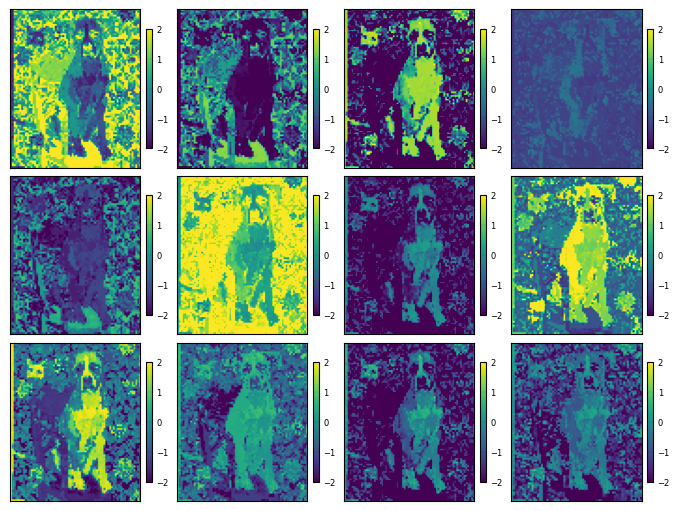

In [19]:
# computes the embeddings
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5), clim=(-2, 2))


In [20]:
# rebuilds the model with 3 latent dimensions
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [21]:
# prints the summary of the model
summary(model, ((X_train.shape[1:])))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              33
           Encoder-2                    [-1, 3]               0
            Linear-3                   [-1, 10]              40
           Decoder-4                   [-1, 10]               0
Total params: 73
Trainable params: 73
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [22]:
train_iterator = torch.utils.data.DataLoader(
    X_train, batch_size=256, shuffle=True)


In [23]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.12it/s]

Epoch 0, Train Loss: 2.3594
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 469.47it/s]

Epoch 1, Train Loss: 2.3181
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 502.12it/s]

Epoch 2, Train Loss: 2.2805
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 487.62it/s]

Epoch 3, Train Loss: 2.2494
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 451.70it/s]

Epoch 4, Train Loss: 2.2163
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 417.05it/s]

Epoch 5, Train Loss: 2.1850
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 444.61it/s]

Epoch 6, Train Loss: 2.1561
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 476.95it/s]

Epoch 7, Train Loss: 2.1224
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 460.15it/s]

Epoch 8, Train Loss: 2.0912
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 449.25it/s]

Epoch 9, Train Loss: 2.0593
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 535.37it/s]

Epoch 10, Train Loss: 2.0236
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 538.92it/s]

Epoch 11, Train Loss: 1.9853
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 589.35it/s]

Epoch 12, Train Loss: 1.9495
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.99it/s]

Epoch 13, Train Loss: 1.9113
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 492.75it/s]

Epoch 14, Train Loss: 1.8703
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 533.87it/s]

Epoch 15, Train Loss: 1.8264
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.68it/s]

Epoch 16, Train Loss: 1.7808
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 642.96it/s]

Epoch 17, Train Loss: 1.7369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 563.85it/s]

Epoch 18, Train Loss: 1.6876
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.23it/s]

Epoch 19, Train Loss: 1.6333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 596.25it/s]

Epoch 20, Train Loss: 1.5798
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 624.00it/s]

Epoch 21, Train Loss: 1.5261
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 636.56it/s]

Epoch 22, Train Loss: 1.4660
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 638.60it/s]

Epoch 23, Train Loss: 1.4064
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 629.46it/s]

Epoch 24, Train Loss: 1.3457
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 470.14it/s]

Epoch 25, Train Loss: 1.2864
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.45it/s]

Epoch 26, Train Loss: 1.2266
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 529.54it/s]

Epoch 27, Train Loss: 1.1686
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 531.14it/s]

Epoch 28, Train Loss: 1.1097
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.74it/s]

Epoch 29, Train Loss: 1.0524
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.43it/s]

Epoch 30, Train Loss: 0.9975
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 529.99it/s]

Epoch 31, Train Loss: 0.9439
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 554.36it/s]

Epoch 32, Train Loss: 0.8917
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.47it/s]

Epoch 33, Train Loss: 0.8427
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 509.53it/s]

Epoch 34, Train Loss: 0.7950
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581.79it/s]

Epoch 35, Train Loss: 0.7502
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.73it/s]

Epoch 36, Train Loss: 0.7077
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.10it/s]

Epoch 37, Train Loss: 0.6668
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.01it/s]

Epoch 38, Train Loss: 0.6293
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.69it/s]

Epoch 39, Train Loss: 0.5935
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.86it/s]

Epoch 40, Train Loss: 0.5598
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.53it/s]

Epoch 41, Train Loss: 0.5290
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 642.42it/s]

Epoch 42, Train Loss: 0.5001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 607.92it/s]

Epoch 43, Train Loss: 0.4723
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.87it/s]

Epoch 44, Train Loss: 0.4470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 631.76it/s]

Epoch 45, Train Loss: 0.4242
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.80it/s]

Epoch 46, Train Loss: 0.4030
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 533.85it/s]

Epoch 47, Train Loss: 0.3825
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.66it/s]

Epoch 48, Train Loss: 0.3655
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.55it/s]

Epoch 49, Train Loss: 0.3486
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 629.34it/s]

Epoch 50, Train Loss: 0.3335
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 616.11it/s]

Epoch 51, Train Loss: 0.3193
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.28it/s]

Epoch 52, Train Loss: 0.3065
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 644.33it/s]

Epoch 53, Train Loss: 0.2943
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.42it/s]

Epoch 54, Train Loss: 0.2836
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.15it/s]

Epoch 55, Train Loss: 0.2732
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.43it/s]

Epoch 56, Train Loss: 0.2647
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.94it/s]

Epoch 57, Train Loss: 0.2565
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.81it/s]

Epoch 58, Train Loss: 0.2486
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.88it/s]

Epoch 59, Train Loss: 0.2418
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 539.34it/s]

Epoch 60, Train Loss: 0.2354
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 550.83it/s]

Epoch 61, Train Loss: 0.2295
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 517.77it/s]

Epoch 62, Train Loss: 0.2243
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 512.10it/s]

Epoch 63, Train Loss: 0.2194
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.06it/s]

Epoch 64, Train Loss: 0.2149
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.38it/s]

Epoch 65, Train Loss: 0.2106
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.97it/s]

Epoch 66, Train Loss: 0.2071
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 514.89it/s]

Epoch 67, Train Loss: 0.2032
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 551.66it/s]

Epoch 68, Train Loss: 0.2003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.35it/s]

Epoch 69, Train Loss: 0.1968
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.99it/s]

Epoch 70, Train Loss: 0.1943
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.22it/s]

Epoch 71, Train Loss: 0.1916
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.87it/s]

Epoch 72, Train Loss: 0.1892
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 613.08it/s]

Epoch 73, Train Loss: 0.1871
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.58it/s]

Epoch 74, Train Loss: 0.1847
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 506.27it/s]

Epoch 75, Train Loss: 0.1827
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.09it/s]

Epoch 76, Train Loss: 0.1810
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.20it/s]

Epoch 77, Train Loss: 0.1790
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.68it/s]

Epoch 78, Train Loss: 0.1775
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.33it/s]

Epoch 79, Train Loss: 0.1761
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.55it/s]

Epoch 80, Train Loss: 0.1748
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.51it/s]

Epoch 81, Train Loss: 0.1733
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 629.18it/s]

Epoch 82, Train Loss: 0.1723
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.55it/s]

Epoch 83, Train Loss: 0.1712
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 556.17it/s]

Epoch 84, Train Loss: 0.1699
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.22it/s]

Epoch 85, Train Loss: 0.1690
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 550.16it/s]

Epoch 86, Train Loss: 0.1679
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.13it/s]

Epoch 87, Train Loss: 0.1672
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.21it/s]

Epoch 88, Train Loss: 0.1664
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.10it/s]

Epoch 89, Train Loss: 0.1657
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 521.35it/s]

Epoch 90, Train Loss: 0.1649
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.75it/s]

Epoch 91, Train Loss: 0.1641
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.21it/s]

Epoch 92, Train Loss: 0.1634
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581.03it/s]

Epoch 93, Train Loss: 0.1628
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.28it/s]

Epoch 94, Train Loss: 0.1623
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.54it/s]

Epoch 95, Train Loss: 0.1619
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 627.80it/s]

Epoch 96, Train Loss: 0.1612
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.86it/s]

Epoch 97, Train Loss: 0.1608
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 580.68it/s]

Epoch 98, Train Loss: 0.1604
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.49it/s]

Epoch 99, Train Loss: 0.1599
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.99it/s]

Epoch 100, Train Loss: 0.1595
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 608.13it/s]

Epoch 101, Train Loss: 0.1592
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 631.03it/s]

Epoch 102, Train Loss: 0.1587
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.90it/s]

Epoch 103, Train Loss: 0.1585
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 583.06it/s]

Epoch 104, Train Loss: 0.1581
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.71it/s]

Epoch 105, Train Loss: 0.1578
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.72it/s]

Epoch 106, Train Loss: 0.1574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.79it/s]

Epoch 107, Train Loss: 0.1570
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 551.12it/s]

Epoch 108, Train Loss: 0.1569
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.63it/s]

Epoch 109, Train Loss: 0.1566
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.63it/s]

Epoch 110, Train Loss: 0.1563
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 615.67it/s]

Epoch 111, Train Loss: 0.1561
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 601.62it/s]

Epoch 112, Train Loss: 0.1559
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.81it/s]

Epoch 113, Train Loss: 0.1558
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 580.40it/s]

Epoch 114, Train Loss: 0.1554
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 474.76it/s]

Epoch 115, Train Loss: 0.1551
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 435.22it/s]

Epoch 116, Train Loss: 0.1547
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 453.80it/s]

Epoch 117, Train Loss: 0.1545
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.32it/s]

Epoch 118, Train Loss: 0.1544
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 490.09it/s]

Epoch 119, Train Loss: 0.1540
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 487.62it/s]

Epoch 120, Train Loss: 0.1540
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 514.27it/s]

Epoch 121, Train Loss: 0.1537
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 514.73it/s]

Epoch 122, Train Loss: 0.1535
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.69it/s]

Epoch 123, Train Loss: 0.1534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.88it/s]

Epoch 124, Train Loss: 0.1530
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.85it/s]

Epoch 125, Train Loss: 0.1527
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.45it/s]

Epoch 126, Train Loss: 0.1527
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.25it/s]

Epoch 127, Train Loss: 0.1524
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.81it/s]

Epoch 128, Train Loss: 0.1520
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 635.03it/s]

Epoch 129, Train Loss: 0.1518
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 524.13it/s]

Epoch 130, Train Loss: 0.1518
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 587.84it/s]

Epoch 131, Train Loss: 0.1514
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.46it/s]

Epoch 132, Train Loss: 0.1514
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 611.40it/s]

Epoch 133, Train Loss: 0.1510
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 580.20it/s]

Epoch 134, Train Loss: 0.1509
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 622.45it/s]

Epoch 135, Train Loss: 0.1506
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.64it/s]

Epoch 136, Train Loss: 0.1505
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.34it/s]

Epoch 137, Train Loss: 0.1501
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.73it/s]

Epoch 138, Train Loss: 0.1499
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 622.08it/s]

Epoch 139, Train Loss: 0.1496
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 530.37it/s]

Epoch 140, Train Loss: 0.1493
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 571.20it/s]

Epoch 141, Train Loss: 0.1493
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 557.02it/s]

Epoch 142, Train Loss: 0.1490
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 530.70it/s]

Epoch 143, Train Loss: 0.1486
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 476.48it/s]

Epoch 144, Train Loss: 0.1485
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 534.49it/s]

Epoch 145, Train Loss: 0.1483
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 523.50it/s]

Epoch 146, Train Loss: 0.1479
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.33it/s]

Epoch 147, Train Loss: 0.1478
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 640.70it/s]

Epoch 148, Train Loss: 0.1474
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.48it/s]

Epoch 149, Train Loss: 0.1474
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 558.28it/s]

Epoch 150, Train Loss: 0.1470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 516.20it/s]

Epoch 151, Train Loss: 0.1469
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 520.91it/s]

Epoch 152, Train Loss: 0.1466
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 487.05it/s]

Epoch 153, Train Loss: 0.1463
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 510.84it/s]

Epoch 154, Train Loss: 0.1461
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.26it/s]

Epoch 155, Train Loss: 0.1458
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 664.16it/s]

Epoch 156, Train Loss: 0.1456
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 516.73it/s]

Epoch 157, Train Loss: 0.1452
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 553.74it/s]

Epoch 158, Train Loss: 0.1451
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 625.74it/s]

Epoch 159, Train Loss: 0.1447
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.47it/s]

Epoch 160, Train Loss: 0.1445
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.31it/s]

Epoch 161, Train Loss: 0.1441
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.12it/s]

Epoch 162, Train Loss: 0.1440
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 631.34it/s]

Epoch 163, Train Loss: 0.1438
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581.87it/s]

Epoch 164, Train Loss: 0.1434
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.79it/s]

Epoch 165, Train Loss: 0.1431
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 642.13it/s]

Epoch 166, Train Loss: 0.1429
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 643.60it/s]

Epoch 167, Train Loss: 0.1426
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 496.86it/s]

Epoch 168, Train Loss: 0.1425
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.43it/s]

Epoch 169, Train Loss: 0.1422
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 497.08it/s]

Epoch 170, Train Loss: 0.1420
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 480.20it/s]

Epoch 171, Train Loss: 0.1414
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.33it/s]

Epoch 172, Train Loss: 0.1412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 536.54it/s]

Epoch 173, Train Loss: 0.1411
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 476.61it/s]

Epoch 174, Train Loss: 0.1407
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 490.42it/s]

Epoch 175, Train Loss: 0.1407
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.80it/s]

Epoch 176, Train Loss: 0.1399
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 530.80it/s]

Epoch 177, Train Loss: 0.1402
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 538.98it/s]

Epoch 178, Train Loss: 0.1397
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 629.12it/s]

Epoch 179, Train Loss: 0.1395
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.99it/s]

Epoch 180, Train Loss: 0.1391
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 582.22it/s]

Epoch 181, Train Loss: 0.1387
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 528.09it/s]

Epoch 182, Train Loss: 0.1385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 540.29it/s]

Epoch 183, Train Loss: 0.1382
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.96it/s]

Epoch 184, Train Loss: 0.1378
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 520.99it/s]

Epoch 185, Train Loss: 0.1378
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.83it/s]

Epoch 186, Train Loss: 0.1371
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 568.08it/s]

Epoch 187, Train Loss: 0.1370
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 662.51it/s]

Epoch 188, Train Loss: 0.1367
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.53it/s]

Epoch 189, Train Loss: 0.1365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 582.93it/s]

Epoch 190, Train Loss: 0.1363
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.01it/s]

Epoch 191, Train Loss: 0.1361
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 547.21it/s]

Epoch 192, Train Loss: 0.1356
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.74it/s]

Epoch 193, Train Loss: 0.1355
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 630.91it/s]

Epoch 194, Train Loss: 0.1350
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 642.94it/s]

Epoch 195, Train Loss: 0.1349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.61it/s]

Epoch 196, Train Loss: 0.1343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.97it/s]

Epoch 197, Train Loss: 0.1342
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.71it/s]

Epoch 198, Train Loss: 0.1338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.54it/s]

Epoch 199, Train Loss: 0.1336
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.56it/s]

Epoch 200, Train Loss: 0.1333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 523.30it/s]

Epoch 201, Train Loss: 0.1328
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 521.04it/s]

Epoch 202, Train Loss: 0.1326
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 478.14it/s]

Epoch 203, Train Loss: 0.1325
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.08it/s]

Epoch 204, Train Loss: 0.1321
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.54it/s]

Epoch 205, Train Loss: 0.1320
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.57it/s]

Epoch 206, Train Loss: 0.1314
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.30it/s]

Epoch 207, Train Loss: 0.1311
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.44it/s]

Epoch 208, Train Loss: 0.1309
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.17it/s]

Epoch 209, Train Loss: 0.1304
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.02it/s]

Epoch 210, Train Loss: 0.1303
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 562.66it/s]

Epoch 211, Train Loss: 0.1302
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.74it/s]

Epoch 212, Train Loss: 0.1298
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.11it/s]

Epoch 213, Train Loss: 0.1294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.01it/s]

Epoch 214, Train Loss: 0.1292
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.29it/s]

Epoch 215, Train Loss: 0.1287
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.00it/s]

Epoch 216, Train Loss: 0.1285
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 637.40it/s]

Epoch 217, Train Loss: 0.1282
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.68it/s]

Epoch 218, Train Loss: 0.1280
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.09it/s]

Epoch 219, Train Loss: 0.1277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 650.95it/s]

Epoch 220, Train Loss: 0.1274
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.66it/s]

Epoch 221, Train Loss: 0.1271
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.66it/s]

Epoch 222, Train Loss: 0.1268
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 619.42it/s]

Epoch 223, Train Loss: 0.1266
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.25it/s]

Epoch 224, Train Loss: 0.1264
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 447.44it/s]

Epoch 225, Train Loss: 0.1260
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.40it/s]

Epoch 226, Train Loss: 0.1255
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 623.36it/s]

Epoch 227, Train Loss: 0.1253
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 529.05it/s]

Epoch 228, Train Loss: 0.1250
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 541.64it/s]

Epoch 229, Train Loss: 0.1250
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 494.96it/s]

Epoch 230, Train Loss: 0.1244
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 487.75it/s]

Epoch 231, Train Loss: 0.1242
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 563.21it/s]

Epoch 232, Train Loss: 0.1238
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 501.64it/s]

Epoch 233, Train Loss: 0.1237
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 512.61it/s]

Epoch 234, Train Loss: 0.1233
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.92it/s]

Epoch 235, Train Loss: 0.1228
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.96it/s]

Epoch 236, Train Loss: 0.1228
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.40it/s]

Epoch 237, Train Loss: 0.1223
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.79it/s]

Epoch 238, Train Loss: 0.1220
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 556.81it/s]

Epoch 239, Train Loss: 0.1219
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 547.24it/s]

Epoch 240, Train Loss: 0.1217
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 524.09it/s]

Epoch 241, Train Loss: 0.1215
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 592.82it/s]

Epoch 242, Train Loss: 0.1210
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.26it/s]

Epoch 243, Train Loss: 0.1206
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 564.12it/s]

Epoch 244, Train Loss: 0.1204
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 636.29it/s]

Epoch 245, Train Loss: 0.1203
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 605.56it/s]

Epoch 246, Train Loss: 0.1198
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 639.67it/s]

Epoch 247, Train Loss: 0.1195
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 567.65it/s]

Epoch 248, Train Loss: 0.1193
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.84it/s]

Epoch 249, Train Loss: 0.1189
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 589.27it/s]

Epoch 250, Train Loss: 0.1188
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.06it/s]

Epoch 251, Train Loss: 0.1184
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 441.11it/s]

Epoch 252, Train Loss: 0.1184
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 431.09it/s]

Epoch 253, Train Loss: 0.1180
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 519.26it/s]

Epoch 254, Train Loss: 0.1177
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 475.98it/s]

Epoch 255, Train Loss: 0.1174
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 507.97it/s]

Epoch 256, Train Loss: 0.1170
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 470.06it/s]

Epoch 257, Train Loss: 0.1169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 473.63it/s]

Epoch 258, Train Loss: 0.1166
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 475.51it/s]

Epoch 259, Train Loss: 0.1162
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 573.50it/s]

Epoch 260, Train Loss: 0.1161
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.93it/s]

Epoch 261, Train Loss: 0.1159
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 587.80it/s]

Epoch 262, Train Loss: 0.1156
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 577.15it/s]

Epoch 263, Train Loss: 0.1152
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 550.86it/s]

Epoch 264, Train Loss: 0.1150
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.50it/s]

Epoch 265, Train Loss: 0.1147
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 589.67it/s]

Epoch 266, Train Loss: 0.1145
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 503.25it/s]

Epoch 267, Train Loss: 0.1143
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 580.16it/s]

Epoch 268, Train Loss: 0.1140
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 587.63it/s]

Epoch 269, Train Loss: 0.1137
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 582.39it/s]

Epoch 270, Train Loss: 0.1135
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 628.36it/s]

Epoch 271, Train Loss: 0.1132
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 611.97it/s]

Epoch 272, Train Loss: 0.1132
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 590.77it/s]

Epoch 273, Train Loss: 0.1127
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.59it/s]

Epoch 274, Train Loss: 0.1126
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 592.76it/s]

Epoch 275, Train Loss: 0.1125
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 534.14it/s]

Epoch 276, Train Loss: 0.1122
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 532.12it/s]

Epoch 277, Train Loss: 0.1119
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 531.32it/s]

Epoch 278, Train Loss: 0.1117
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 557.09it/s]

Epoch 279, Train Loss: 0.1113
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 460.25it/s]

Epoch 280, Train Loss: 0.1113
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 508.86it/s]

Epoch 281, Train Loss: 0.1110
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 472.93it/s]

Epoch 282, Train Loss: 0.1109
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 424.79it/s]

Epoch 283, Train Loss: 0.1106
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 461.12it/s]

Epoch 284, Train Loss: 0.1104
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 466.12it/s]

Epoch 285, Train Loss: 0.1100
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 478.77it/s]

Epoch 286, Train Loss: 0.1097
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 480.99it/s]

Epoch 287, Train Loss: 0.1094
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 452.58it/s]

Epoch 288, Train Loss: 0.1096
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 488.87it/s]

Epoch 289, Train Loss: 0.1092
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 510.00it/s]

Epoch 290, Train Loss: 0.1091
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 605.46it/s]

Epoch 291, Train Loss: 0.1089
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 587.72it/s]

Epoch 292, Train Loss: 0.1084
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 523.82it/s]

Epoch 293, Train Loss: 0.1084
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.66it/s]

Epoch 294, Train Loss: 0.1083
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 583.05it/s]

Epoch 295, Train Loss: 0.1081
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 552.48it/s]

Epoch 296, Train Loss: 0.1079
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.26it/s]

Epoch 297, Train Loss: 0.1076


.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.45it/s]

Epoch 298, Train Loss: 0.1073
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 605.39it/s]

Epoch 299, Train Loss: 0.1072
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 559.18it/s]

Epoch 300, Train Loss: 0.1068
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.13it/s]

Epoch 301, Train Loss: 0.1068
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 624.49it/s]

Epoch 302, Train Loss: 0.1068
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 648.30it/s]

Epoch 303, Train Loss: 0.1066
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.57it/s]

Epoch 304, Train Loss: 0.1063
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.13it/s]

Epoch 305, Train Loss: 0.1062
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 654.63it/s]

Epoch 306, Train Loss: 0.1058
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 571.44it/s]

Epoch 307, Train Loss: 0.1058
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 480.29it/s]

Epoch 308, Train Loss: 0.1060
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 568.16it/s]

Epoch 309, Train Loss: 0.1054


.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 488.77it/s]

Epoch 310, Train Loss: 0.1054
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.99it/s]

Epoch 311, Train Loss: 0.1052
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 510.08it/s]

Epoch 312, Train Loss: 0.1052
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 533.49it/s]

Epoch 313, Train Loss: 0.1050
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 513.71it/s]

Epoch 314, Train Loss: 0.1048
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 474.24it/s]

Epoch 315, Train Loss: 0.1045
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 547.99it/s]

Epoch 316, Train Loss: 0.1043
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 636.89it/s]

Epoch 317, Train Loss: 0.1042
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.05it/s]

Epoch 318, Train Loss: 0.1040
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 606.60it/s]

Epoch 319, Train Loss: 0.1040
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.00it/s]

Epoch 320, Train Loss: 0.1040
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 535.98it/s]

Epoch 321, Train Loss: 0.1037
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.28it/s]

Epoch 322, Train Loss: 0.1037
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 626.96it/s]

Epoch 323, Train Loss: 0.1035
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 573.98it/s]

Epoch 324, Train Loss: 0.1033
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.28it/s]

Epoch 325, Train Loss: 0.1033
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 599.82it/s]

Epoch 326, Train Loss: 0.1029
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 606.64it/s]

Epoch 327, Train Loss: 0.1027
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 505.29it/s]

Epoch 328, Train Loss: 0.1028
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 583.25it/s]

Epoch 329, Train Loss: 0.1027
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 609.58it/s]

Epoch 330, Train Loss: 0.1027
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 594.84it/s]

Epoch 331, Train Loss: 0.1022
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.91it/s]

Epoch 332, Train Loss: 0.1023
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 576.91it/s]

Epoch 333, Train Loss: 0.1022
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 598.54it/s]

Epoch 334, Train Loss: 0.1020
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 596.81it/s]

Epoch 335, Train Loss: 0.1018
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 502.75it/s]

Epoch 336, Train Loss: 0.1019
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 475.45it/s]

Epoch 337, Train Loss: 0.1017
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 489.91it/s]

Epoch 338, Train Loss: 0.1017
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 506.17it/s]

Epoch 339, Train Loss: 0.1014
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.75it/s]

Epoch 340, Train Loss: 0.1011
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 536.62it/s]

Epoch 341, Train Loss: 0.1010
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.06it/s]

Epoch 342, Train Loss: 0.1010
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 634.76it/s]

Epoch 343, Train Loss: 0.1010
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 596.82it/s]

Epoch 344, Train Loss: 0.1008
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 547.20it/s]

Epoch 345, Train Loss: 0.1007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 588.61it/s]

Epoch 346, Train Loss: 0.1006
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.18it/s]

Epoch 347, Train Loss: 0.1004
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.01it/s]

Epoch 348, Train Loss: 0.1002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 542.49it/s]

Epoch 349, Train Loss: 0.1000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 611.78it/s]

Epoch 350, Train Loss: 0.1001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.14it/s]

Epoch 351, Train Loss: 0.1000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.77it/s]

Epoch 352, Train Loss: 0.0998
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 618.21it/s]

Epoch 353, Train Loss: 0.0997
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 606.86it/s]

Epoch 354, Train Loss: 0.0998
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.40it/s]

Epoch 355, Train Loss: 0.0995
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 550.95it/s]

Epoch 356, Train Loss: 0.0992
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 544.36it/s]

Epoch 357, Train Loss: 0.0991
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.60it/s]

Epoch 358, Train Loss: 0.0992
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 595.35it/s]

Epoch 359, Train Loss: 0.0989
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 578.24it/s]

Epoch 360, Train Loss: 0.0986
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.00it/s]

Epoch 361, Train Loss: 0.0988
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.18it/s]

Epoch 362, Train Loss: 0.0987
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 637.38it/s]

Epoch 363, Train Loss: 0.0987
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 610.07it/s]

Epoch 364, Train Loss: 0.0985
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 440.96it/s]

Epoch 365, Train Loss: 0.0983
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.77it/s]

Epoch 366, Train Loss: 0.0982
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 583.51it/s]

Epoch 367, Train Loss: 0.0980
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.20it/s]

Epoch 368, Train Loss: 0.0980
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 543.77it/s]

Epoch 369, Train Loss: 0.0979
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 541.37it/s]

Epoch 370, Train Loss: 0.0975
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 478.31it/s]

Epoch 371, Train Loss: 0.0977
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 557.82it/s]

Epoch 372, Train Loss: 0.0974
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 548.12it/s]

Epoch 373, Train Loss: 0.0974
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.90it/s]

Epoch 374, Train Loss: 0.0973
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.18it/s]

Epoch 375, Train Loss: 0.0971
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 531.70it/s]

Epoch 376, Train Loss: 0.0971
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.71it/s]

Epoch 377, Train Loss: 0.0969
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.22it/s]

Epoch 378, Train Loss: 0.0966
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 581.22it/s]

Epoch 379, Train Loss: 0.0966
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.28it/s]

Epoch 380, Train Loss: 0.0966
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 620.28it/s]

Epoch 381, Train Loss: 0.0963
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.19it/s]

Epoch 382, Train Loss: 0.0961
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 643.61it/s]

Epoch 383, Train Loss: 0.0962
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.72it/s]

Epoch 384, Train Loss: 0.0960
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 597.73it/s]

Epoch 385, Train Loss: 0.0959
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 573.73it/s]

Epoch 386, Train Loss: 0.0958
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 572.86it/s]

Epoch 387, Train Loss: 0.0956
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 524.05it/s]

Epoch 388, Train Loss: 0.0955
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 482.92it/s]

Epoch 389, Train Loss: 0.0954
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 539.83it/s]

Epoch 390, Train Loss: 0.0953
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 498.21it/s]

Epoch 391, Train Loss: 0.0951
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 502.13it/s]

Epoch 392, Train Loss: 0.0949
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 487.03it/s]

Epoch 393, Train Loss: 0.0948
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 503.27it/s]

Epoch 394, Train Loss: 0.0946
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.65it/s]

Epoch 395, Train Loss: 0.0944
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.77it/s]

Epoch 396, Train Loss: 0.0943
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 533.31it/s]

Epoch 397, Train Loss: 0.0943
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 558.81it/s]

Epoch 398, Train Loss: 0.0941
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 499.60it/s]

Epoch 399, Train Loss: 0.0941
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 568.37it/s]

Epoch 400, Train Loss: 0.0939
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.76it/s]

Epoch 401, Train Loss: 0.0937
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 559.41it/s]

Epoch 402, Train Loss: 0.0935
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 506.33it/s]

Epoch 403, Train Loss: 0.0934
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.46it/s]

Epoch 404, Train Loss: 0.0934
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 648.60it/s]

Epoch 405, Train Loss: 0.0931
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 604.38it/s]

Epoch 406, Train Loss: 0.0930
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.75it/s]

Epoch 407, Train Loss: 0.0929
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.48it/s]

Epoch 408, Train Loss: 0.0926
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.24it/s]

Epoch 409, Train Loss: 0.0925
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 551.19it/s]

Epoch 410, Train Loss: 0.0926
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 483.40it/s]

Epoch 411, Train Loss: 0.0925
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.69it/s]

Epoch 412, Train Loss: 0.0922
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 654.34it/s]

Epoch 413, Train Loss: 0.0922
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 560.38it/s]

Epoch 414, Train Loss: 0.0918
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 616.48it/s]

Epoch 415, Train Loss: 0.0918
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.91it/s]

Epoch 416, Train Loss: 0.0914
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.74it/s]

Epoch 417, Train Loss: 0.0914
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.98it/s]

Epoch 418, Train Loss: 0.0916
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 545.34it/s]

Epoch 419, Train Loss: 0.0913
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 485.45it/s]

Epoch 420, Train Loss: 0.0911
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 491.39it/s]

Epoch 421, Train Loss: 0.0908
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.37it/s]

Epoch 422, Train Loss: 0.0908
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.32it/s]

Epoch 423, Train Loss: 0.0904
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 485.08it/s]

Epoch 424, Train Loss: 0.0904
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 461.13it/s]

Epoch 425, Train Loss: 0.0904
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 498.41it/s]

Epoch 426, Train Loss: 0.0903
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 483.10it/s]

Epoch 427, Train Loss: 0.0901
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 558.82it/s]

Epoch 428, Train Loss: 0.0900
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 617.43it/s]

Epoch 429, Train Loss: 0.0899
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 472.70it/s]

Epoch 430, Train Loss: 0.0896
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.65it/s]

Epoch 431, Train Loss: 0.0896
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 624.32it/s]

Epoch 432, Train Loss: 0.0894
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 633.31it/s]

Epoch 433, Train Loss: 0.0894
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 602.97it/s]

Epoch 434, Train Loss: 0.0892
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 600.16it/s]

Epoch 435, Train Loss: 0.0889
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 622.56it/s]

Epoch 436, Train Loss: 0.0888
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.29it/s]

Epoch 437, Train Loss: 0.0887
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 567.86it/s]

Epoch 438, Train Loss: 0.0885
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.93it/s]

Epoch 439, Train Loss: 0.0884
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 591.21it/s]

Epoch 440, Train Loss: 0.0883
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.66it/s]

Epoch 441, Train Loss: 0.0882
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 589.42it/s]

Epoch 442, Train Loss: 0.0878
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 531.57it/s]

Epoch 443, Train Loss: 0.0878
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.02it/s]

Epoch 444, Train Loss: 0.0876
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 585.06it/s]

Epoch 445, Train Loss: 0.0875
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 621.81it/s]

Epoch 446, Train Loss: 0.0872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.74it/s]

Epoch 447, Train Loss: 0.0872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 561.76it/s]

Epoch 448, Train Loss: 0.0870
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 525.25it/s]

Epoch 449, Train Loss: 0.0870
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 538.76it/s]

Epoch 450, Train Loss: 0.0868
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 547.35it/s]

Epoch 451, Train Loss: 0.0867
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 520.18it/s]

Epoch 452, Train Loss: 0.0867
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 500.00it/s]

Epoch 453, Train Loss: 0.0864
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 473.30it/s]

Epoch 454, Train Loss: 0.0863
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 487.11it/s]

Epoch 455, Train Loss: 0.0860
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 511.63it/s]

Epoch 456, Train Loss: 0.0858
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 399.14it/s]

Epoch 457, Train Loss: 0.0857
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 527.70it/s]

Epoch 458, Train Loss: 0.0857
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.09it/s]

Epoch 459, Train Loss: 0.0856
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.58it/s]

Epoch 460, Train Loss: 0.0854
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.97it/s]

Epoch 461, Train Loss: 0.0852
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 574.61it/s]

Epoch 462, Train Loss: 0.0850
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.78it/s]

Epoch 463, Train Loss: 0.0849
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 534.59it/s]

Epoch 464, Train Loss: 0.0849
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 546.69it/s]

Epoch 465, Train Loss: 0.0847
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 555.26it/s]

Epoch 466, Train Loss: 0.0845
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 565.68it/s]

Epoch 467, Train Loss: 0.0843
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 522.14it/s]

Epoch 468, Train Loss: 0.0843
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.73it/s]

Epoch 469, Train Loss: 0.0841
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 542.78it/s]

Epoch 470, Train Loss: 0.0840
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 566.27it/s]

Epoch 471, Train Loss: 0.0839
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.08it/s]

Epoch 472, Train Loss: 0.0837
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 546.22it/s]

Epoch 473, Train Loss: 0.0837
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 570.42it/s]

Epoch 474, Train Loss: 0.0833
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 579.12it/s]

Epoch 475, Train Loss: 0.0834
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 486.91it/s]

Epoch 476, Train Loss: 0.0831
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 510.63it/s]

Epoch 477, Train Loss: 0.0830
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 528.13it/s]

Epoch 478, Train Loss: 0.0830
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 536.02it/s]

Epoch 479, Train Loss: 0.0827
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.40it/s]

Epoch 480, Train Loss: 0.0826
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 499.63it/s]

Epoch 481, Train Loss: 0.0824
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 612.98it/s]

Epoch 482, Train Loss: 0.0824
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 542.49it/s]

Epoch 483, Train Loss: 0.0824
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 480.80it/s]

Epoch 484, Train Loss: 0.0822
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 537.19it/s]

Epoch 485, Train Loss: 0.0819
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 567.28it/s]

Epoch 486, Train Loss: 0.0818
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 549.67it/s]

Epoch 487, Train Loss: 0.0819
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.08it/s]

Epoch 488, Train Loss: 0.0817
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 541.85it/s]

Epoch 489, Train Loss: 0.0815
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 504.36it/s]

Epoch 490, Train Loss: 0.0813
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 575.46it/s]

Epoch 491, Train Loss: 0.0813
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 603.09it/s]

Epoch 492, Train Loss: 0.0813
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 550.94it/s]

Epoch 493, Train Loss: 0.0811
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 524.16it/s]

Epoch 494, Train Loss: 0.0809
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 558.75it/s]

Epoch 495, Train Loss: 0.0806
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 593.64it/s]

Epoch 496, Train Loss: 0.0806
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 517.43it/s]

Epoch 497, Train Loss: 0.0806
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 586.28it/s]

Epoch 498, Train Loss: 0.0804
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 569.06it/s]

Epoch 499, Train Loss: 0.0803
.............................


In [24]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


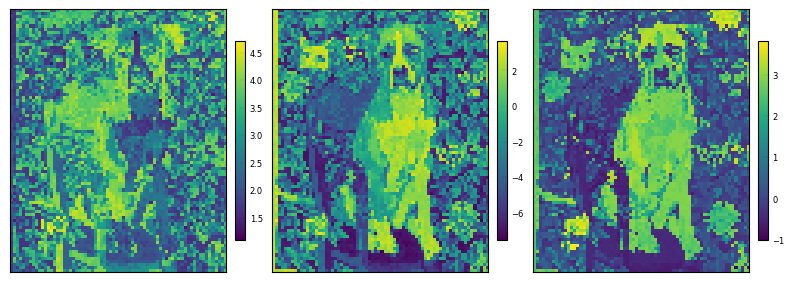

In [25]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


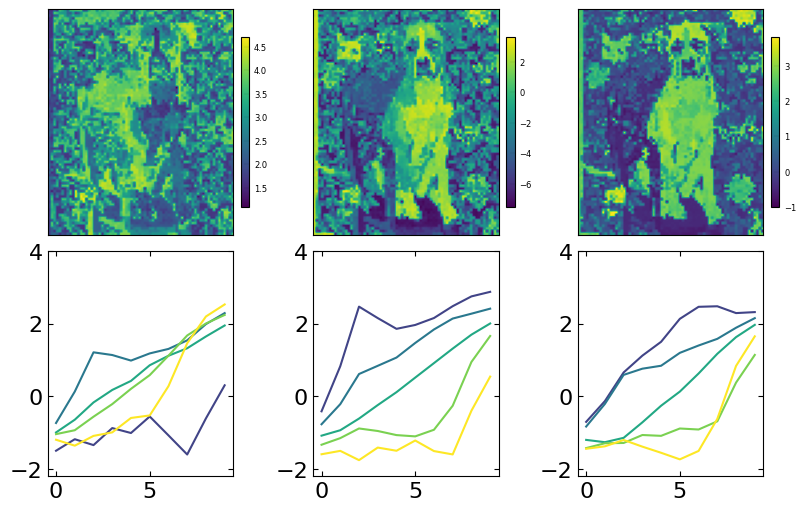

In [26]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


In [27]:
latent_dim = 12

# encoder with LSTM
class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [28]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [29]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [30]:
random_seed(seed=42)
Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

  5%|████████                                                                                                                                                 | 1/19 [00:01<00:22,  1.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 13.94it/s]

Epoch 0, Train Loss: 2.2412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.22it/s]

Epoch 1, Train Loss: 2.2313
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.63it/s]

Epoch 2, Train Loss: 2.2214
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.32it/s]

Epoch 3, Train Loss: 2.2117
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.48it/s]

Epoch 4, Train Loss: 2.2020
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.02it/s]

Epoch 5, Train Loss: 2.1923
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.32it/s]

Epoch 6, Train Loss: 2.1826
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.25it/s]

Epoch 7, Train Loss: 2.1729
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.36it/s]

Epoch 8, Train Loss: 2.1631
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.22it/s]

Epoch 9, Train Loss: 2.1533
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 244.81it/s]

Epoch 10, Train Loss: 2.1433
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.45it/s]

Epoch 11, Train Loss: 2.1333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.38it/s]

Epoch 12, Train Loss: 2.1230
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.58it/s]

Epoch 13, Train Loss: 2.1126
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.07it/s]

Epoch 14, Train Loss: 2.1019
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.40it/s]

Epoch 15, Train Loss: 2.0911
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.15it/s]

Epoch 16, Train Loss: 2.0799
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.61it/s]

Epoch 17, Train Loss: 2.0686
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.84it/s]

Epoch 18, Train Loss: 2.0569
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.49it/s]

Epoch 19, Train Loss: 2.0449
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.08it/s]

Epoch 20, Train Loss: 2.0326
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.60it/s]

Epoch 21, Train Loss: 2.0200
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.77it/s]

Epoch 22, Train Loss: 2.0070
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.44it/s]

Epoch 23, Train Loss: 1.9937
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.76it/s]

Epoch 24, Train Loss: 1.9799
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.95it/s]

Epoch 25, Train Loss: 1.9658
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.93it/s]

Epoch 26, Train Loss: 1.9512
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.88it/s]

Epoch 27, Train Loss: 1.9362
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.29it/s]

Epoch 28, Train Loss: 1.9208
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.36it/s]

Epoch 29, Train Loss: 1.9050
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.88it/s]

Epoch 30, Train Loss: 1.8887
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.45it/s]

Epoch 31, Train Loss: 1.8719
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.25it/s]

Epoch 32, Train Loss: 1.8548
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.78it/s]

Epoch 33, Train Loss: 1.8372
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.89it/s]

Epoch 34, Train Loss: 1.8192
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.13it/s]

Epoch 35, Train Loss: 1.8008
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.99it/s]

Epoch 36, Train Loss: 1.7821
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.56it/s]

Epoch 37, Train Loss: 1.7630
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.23it/s]

Epoch 38, Train Loss: 1.7436
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.89it/s]

Epoch 39, Train Loss: 1.7240
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.00it/s]

Epoch 40, Train Loss: 1.7042
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.69it/s]

Epoch 41, Train Loss: 1.6842
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.99it/s]

Epoch 42, Train Loss: 1.6642
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.81it/s]

Epoch 43, Train Loss: 1.6441
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.81it/s]

Epoch 44, Train Loss: 1.6241
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.55it/s]

Epoch 45, Train Loss: 1.6043
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.95it/s]

Epoch 46, Train Loss: 1.5846
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.71it/s]

Epoch 47, Train Loss: 1.5652
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.88it/s]

Epoch 48, Train Loss: 1.5462
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.14it/s]

Epoch 49, Train Loss: 1.5276
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.96it/s]

Epoch 50, Train Loss: 1.5093
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.83it/s]

Epoch 51, Train Loss: 1.4916
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.17it/s]

Epoch 52, Train Loss: 1.4743
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.91it/s]

Epoch 53, Train Loss: 1.4574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.74it/s]

Epoch 54, Train Loss: 1.4410
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.90it/s]

Epoch 55, Train Loss: 1.4251
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.96it/s]

Epoch 56, Train Loss: 1.4096
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.23it/s]

Epoch 57, Train Loss: 1.3944
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.06it/s]

Epoch 58, Train Loss: 1.3796
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.64it/s]

Epoch 59, Train Loss: 1.3650
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.43it/s]

Epoch 60, Train Loss: 1.3507
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.46it/s]

Epoch 61, Train Loss: 1.3366
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.67it/s]

Epoch 62, Train Loss: 1.3226
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.32it/s]

Epoch 63, Train Loss: 1.3087
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.01it/s]

Epoch 64, Train Loss: 1.2948
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.07it/s]

Epoch 65, Train Loss: 1.2810
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.57it/s]

Epoch 66, Train Loss: 1.2672
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.98it/s]

Epoch 67, Train Loss: 1.2534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.16it/s]

Epoch 68, Train Loss: 1.2395
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.58it/s]

Epoch 69, Train Loss: 1.2255
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.51it/s]

Epoch 70, Train Loss: 1.2115
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.41it/s]

Epoch 71, Train Loss: 1.1974
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.86it/s]

Epoch 72, Train Loss: 1.1832
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.30it/s]

Epoch 73, Train Loss: 1.1689
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.91it/s]

Epoch 74, Train Loss: 1.1546
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.24it/s]

Epoch 75, Train Loss: 1.1401
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.44it/s]

Epoch 76, Train Loss: 1.1256
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.12it/s]

Epoch 77, Train Loss: 1.1109
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.53it/s]

Epoch 78, Train Loss: 1.0962
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.32it/s]

Epoch 79, Train Loss: 1.0814
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.72it/s]

Epoch 80, Train Loss: 1.0666
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.94it/s]

Epoch 81, Train Loss: 1.0516
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.04it/s]

Epoch 82, Train Loss: 1.0367
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.32it/s]

Epoch 83, Train Loss: 1.0217
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.24it/s]

Epoch 84, Train Loss: 1.0067
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.38it/s]

Epoch 85, Train Loss: 0.9916
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.09it/s]

Epoch 86, Train Loss: 0.9766
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.66it/s]

Epoch 87, Train Loss: 0.9615
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.18it/s]

Epoch 88, Train Loss: 0.9465
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.28it/s]

Epoch 89, Train Loss: 0.9314
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.29it/s]

Epoch 90, Train Loss: 0.9164
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.94it/s]

Epoch 91, Train Loss: 0.9015
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.85it/s]

Epoch 92, Train Loss: 0.8866
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.41it/s]

Epoch 93, Train Loss: 0.8717
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.83it/s]

Epoch 94, Train Loss: 0.8569
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.57it/s]

Epoch 95, Train Loss: 0.8422
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.10it/s]

Epoch 96, Train Loss: 0.8275
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.81it/s]

Epoch 97, Train Loss: 0.8129
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.00it/s]

Epoch 98, Train Loss: 0.7984
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.89it/s]

Epoch 99, Train Loss: 0.7840
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.46it/s]

Epoch 100, Train Loss: 0.7697
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.32it/s]

Epoch 101, Train Loss: 0.7555
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.69it/s]

Epoch 102, Train Loss: 0.7414
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.51it/s]

Epoch 103, Train Loss: 0.7274
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.98it/s]

Epoch 104, Train Loss: 0.7135
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.73it/s]

Epoch 105, Train Loss: 0.6997
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.27it/s]

Epoch 106, Train Loss: 0.6861
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.69it/s]

Epoch 107, Train Loss: 0.6726
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.34it/s]

Epoch 108, Train Loss: 0.6592
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.71it/s]

Epoch 109, Train Loss: 0.6459
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.06it/s]

Epoch 110, Train Loss: 0.6328
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.91it/s]

Epoch 111, Train Loss: 0.6199
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.97it/s]

Epoch 112, Train Loss: 0.6070
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.37it/s]

Epoch 113, Train Loss: 0.5944
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.03it/s]

Epoch 114, Train Loss: 0.5818
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.37it/s]

Epoch 115, Train Loss: 0.5695
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.01it/s]

Epoch 116, Train Loss: 0.5573
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.75it/s]

Epoch 117, Train Loss: 0.5453
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.75it/s]

Epoch 118, Train Loss: 0.5334
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.95it/s]

Epoch 119, Train Loss: 0.5218
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.03it/s]

Epoch 120, Train Loss: 0.5104
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.00it/s]

Epoch 121, Train Loss: 0.4991
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.44it/s]

Epoch 122, Train Loss: 0.4881
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.05it/s]

Epoch 123, Train Loss: 0.4774
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.36it/s]

Epoch 124, Train Loss: 0.4668
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.25it/s]

Epoch 125, Train Loss: 0.4566
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.45it/s]

Epoch 126, Train Loss: 0.4466
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.16it/s]

Epoch 127, Train Loss: 0.4369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.23it/s]

Epoch 128, Train Loss: 0.4274
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.90it/s]

Epoch 129, Train Loss: 0.4183
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.62it/s]

Epoch 130, Train Loss: 0.4094
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.41it/s]

Epoch 131, Train Loss: 0.4008
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 238.79it/s]

Epoch 132, Train Loss: 0.3925
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.39it/s]

Epoch 133, Train Loss: 0.3845
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.09it/s]

Epoch 134, Train Loss: 0.3767
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.87it/s]

Epoch 135, Train Loss: 0.3692
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.23it/s]

Epoch 136, Train Loss: 0.3620
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.77it/s]

Epoch 137, Train Loss: 0.3550
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.57it/s]

Epoch 138, Train Loss: 0.3482
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.31it/s]

Epoch 139, Train Loss: 0.3417
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.83it/s]

Epoch 140, Train Loss: 0.3354
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.31it/s]

Epoch 141, Train Loss: 0.3294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.43it/s]

Epoch 142, Train Loss: 0.3235
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.21it/s]

Epoch 143, Train Loss: 0.3179
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.77it/s]

Epoch 144, Train Loss: 0.3124
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.19it/s]

Epoch 145, Train Loss: 0.3072
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.54it/s]

Epoch 146, Train Loss: 0.3021
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.29it/s]

Epoch 147, Train Loss: 0.2973
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 242.02it/s]

Epoch 148, Train Loss: 0.2926
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.63it/s]

Epoch 149, Train Loss: 0.2880
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.13it/s]

Epoch 150, Train Loss: 0.2837
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.82it/s]

Epoch 151, Train Loss: 0.2795
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.15it/s]

Epoch 152, Train Loss: 0.2754
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.82it/s]

Epoch 153, Train Loss: 0.2716
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.89it/s]

Epoch 154, Train Loss: 0.2678
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.93it/s]

Epoch 155, Train Loss: 0.2642
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.50it/s]

Epoch 156, Train Loss: 0.2607
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.95it/s]

Epoch 157, Train Loss: 0.2574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.40it/s]

Epoch 158, Train Loss: 0.2542
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.48it/s]

Epoch 159, Train Loss: 0.2511
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.82it/s]

Epoch 160, Train Loss: 0.2481
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.09it/s]

Epoch 161, Train Loss: 0.2453
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.72it/s]

Epoch 162, Train Loss: 0.2425
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.52it/s]

Epoch 163, Train Loss: 0.2399
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.65it/s]

Epoch 164, Train Loss: 0.2374
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.45it/s]

Epoch 165, Train Loss: 0.2349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.41it/s]

Epoch 166, Train Loss: 0.2326
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.70it/s]

Epoch 167, Train Loss: 0.2303
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.01it/s]

Epoch 168, Train Loss: 0.2281
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.64it/s]

Epoch 169, Train Loss: 0.2261
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.71it/s]

Epoch 170, Train Loss: 0.2241
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.39it/s]

Epoch 171, Train Loss: 0.2221
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.34it/s]

Epoch 172, Train Loss: 0.2203
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.08it/s]

Epoch 173, Train Loss: 0.2185
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.18it/s]

Epoch 174, Train Loss: 0.2167
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.85it/s]

Epoch 175, Train Loss: 0.2151
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.55it/s]

Epoch 176, Train Loss: 0.2135
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.92it/s]

Epoch 177, Train Loss: 0.2119
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.86it/s]

Epoch 178, Train Loss: 0.2104
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.66it/s]

Epoch 179, Train Loss: 0.2090
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.69it/s]

Epoch 180, Train Loss: 0.2076
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.74it/s]

Epoch 181, Train Loss: 0.2062
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 238.32it/s]

Epoch 182, Train Loss: 0.2049
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.98it/s]

Epoch 183, Train Loss: 0.2036
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 241.53it/s]

Epoch 184, Train Loss: 0.2024
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.58it/s]

Epoch 185, Train Loss: 0.2012
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.67it/s]

Epoch 186, Train Loss: 0.2000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.14it/s]

Epoch 187, Train Loss: 0.1989
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.52it/s]

Epoch 188, Train Loss: 0.1977
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.56it/s]

Epoch 189, Train Loss: 0.1967
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.67it/s]

Epoch 190, Train Loss: 0.1956
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.88it/s]

Epoch 191, Train Loss: 0.1945
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.58it/s]

Epoch 192, Train Loss: 0.1935
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.61it/s]

Epoch 193, Train Loss: 0.1925
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.89it/s]

Epoch 194, Train Loss: 0.1915
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.25it/s]

Epoch 195, Train Loss: 0.1906
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.52it/s]

Epoch 196, Train Loss: 0.1897
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.62it/s]

Epoch 197, Train Loss: 0.1888
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.41it/s]

Epoch 198, Train Loss: 0.1879
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.32it/s]

Epoch 199, Train Loss: 0.1871
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.38it/s]

Epoch 200, Train Loss: 0.1862
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.13it/s]

Epoch 201, Train Loss: 0.1854
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.62it/s]

Epoch 202, Train Loss: 0.1847
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.81it/s]

Epoch 203, Train Loss: 0.1839
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.88it/s]

Epoch 204, Train Loss: 0.1832
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.39it/s]

Epoch 205, Train Loss: 0.1825
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.47it/s]

Epoch 206, Train Loss: 0.1818
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.18it/s]

Epoch 207, Train Loss: 0.1812
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.10it/s]

Epoch 208, Train Loss: 0.1805
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.23it/s]

Epoch 209, Train Loss: 0.1799
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.85it/s]

Epoch 210, Train Loss: 0.1793
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.78it/s]

Epoch 211, Train Loss: 0.1787
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.40it/s]

Epoch 212, Train Loss: 0.1781
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.37it/s]

Epoch 213, Train Loss: 0.1776
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.47it/s]

Epoch 214, Train Loss: 0.1771
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.71it/s]

Epoch 215, Train Loss: 0.1765
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.57it/s]

Epoch 216, Train Loss: 0.1760
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.26it/s]

Epoch 217, Train Loss: 0.1755
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.74it/s]

Epoch 218, Train Loss: 0.1750
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.99it/s]

Epoch 219, Train Loss: 0.1746
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.61it/s]

Epoch 220, Train Loss: 0.1741
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.31it/s]

Epoch 221, Train Loss: 0.1736
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.42it/s]

Epoch 222, Train Loss: 0.1732
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.33it/s]

Epoch 223, Train Loss: 0.1728
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.17it/s]

Epoch 224, Train Loss: 0.1723
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.51it/s]

Epoch 225, Train Loss: 0.1719
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.03it/s]

Epoch 226, Train Loss: 0.1715
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.51it/s]

Epoch 227, Train Loss: 0.1711
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.73it/s]

Epoch 228, Train Loss: 0.1707
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.55it/s]

Epoch 229, Train Loss: 0.1704
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.65it/s]

Epoch 230, Train Loss: 0.1700
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.58it/s]

Epoch 231, Train Loss: 0.1696
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.16it/s]

Epoch 232, Train Loss: 0.1692
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.07it/s]

Epoch 233, Train Loss: 0.1689
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.56it/s]

Epoch 234, Train Loss: 0.1685
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.50it/s]

Epoch 235, Train Loss: 0.1682
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.83it/s]

Epoch 236, Train Loss: 0.1678
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.58it/s]

Epoch 237, Train Loss: 0.1675
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.19it/s]

Epoch 238, Train Loss: 0.1672
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.51it/s]

Epoch 239, Train Loss: 0.1668
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.21it/s]

Epoch 240, Train Loss: 0.1665
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.41it/s]

Epoch 241, Train Loss: 0.1662
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.22it/s]

Epoch 242, Train Loss: 0.1659
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.69it/s]

Epoch 243, Train Loss: 0.1655
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.23it/s]

Epoch 244, Train Loss: 0.1652
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.50it/s]

Epoch 245, Train Loss: 0.1649
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.31it/s]

Epoch 246, Train Loss: 0.1646
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.15it/s]

Epoch 247, Train Loss: 0.1643
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.60it/s]

Epoch 248, Train Loss: 0.1640
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.14it/s]

Epoch 249, Train Loss: 0.1637
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.96it/s]

Epoch 250, Train Loss: 0.1634
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.12it/s]

Epoch 251, Train Loss: 0.1631
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.49it/s]

Epoch 252, Train Loss: 0.1628
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.09it/s]

Epoch 253, Train Loss: 0.1625
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.15it/s]

Epoch 254, Train Loss: 0.1622
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.17it/s]

Epoch 255, Train Loss: 0.1619
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.35it/s]

Epoch 256, Train Loss: 0.1616
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.01it/s]

Epoch 257, Train Loss: 0.1614
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.41it/s]

Epoch 258, Train Loss: 0.1611
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.17it/s]

Epoch 259, Train Loss: 0.1608
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.43it/s]

Epoch 260, Train Loss: 0.1605
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.11it/s]

Epoch 261, Train Loss: 0.1602
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.74it/s]

Epoch 262, Train Loss: 0.1599
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.15it/s]

Epoch 263, Train Loss: 0.1597
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.13it/s]

Epoch 264, Train Loss: 0.1594
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.48it/s]

Epoch 265, Train Loss: 0.1591
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.20it/s]

Epoch 266, Train Loss: 0.1588
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.56it/s]

Epoch 267, Train Loss: 0.1585
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.69it/s]

Epoch 268, Train Loss: 0.1583
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.40it/s]

Epoch 269, Train Loss: 0.1580
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.22it/s]

Epoch 270, Train Loss: 0.1577
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.85it/s]

Epoch 271, Train Loss: 0.1574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.93it/s]

Epoch 272, Train Loss: 0.1571
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.36it/s]

Epoch 273, Train Loss: 0.1569
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.02it/s]

Epoch 274, Train Loss: 0.1566
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.86it/s]

Epoch 275, Train Loss: 0.1563
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.60it/s]

Epoch 276, Train Loss: 0.1560
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.55it/s]

Epoch 277, Train Loss: 0.1558
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.16it/s]

Epoch 278, Train Loss: 0.1555
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.93it/s]

Epoch 279, Train Loss: 0.1552
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.75it/s]

Epoch 280, Train Loss: 0.1549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.96it/s]

Epoch 281, Train Loss: 0.1547
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.67it/s]

Epoch 282, Train Loss: 0.1544
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.21it/s]

Epoch 283, Train Loss: 0.1541
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.17it/s]

Epoch 284, Train Loss: 0.1538
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.96it/s]

Epoch 285, Train Loss: 0.1536
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.93it/s]

Epoch 286, Train Loss: 0.1533
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.52it/s]

Epoch 287, Train Loss: 0.1530
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.43it/s]

Epoch 288, Train Loss: 0.1528
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.72it/s]

Epoch 289, Train Loss: 0.1525
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.86it/s]

Epoch 290, Train Loss: 0.1522
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.74it/s]

Epoch 291, Train Loss: 0.1520
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.31it/s]

Epoch 292, Train Loss: 0.1517
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.95it/s]

Epoch 293, Train Loss: 0.1514
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.71it/s]

Epoch 294, Train Loss: 0.1511
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.60it/s]

Epoch 295, Train Loss: 0.1509
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.38it/s]

Epoch 296, Train Loss: 0.1506
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.51it/s]

Epoch 297, Train Loss: 0.1503
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.44it/s]

Epoch 298, Train Loss: 0.1501
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.71it/s]

Epoch 299, Train Loss: 0.1498
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.85it/s]

Epoch 300, Train Loss: 0.1496
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.82it/s]

Epoch 301, Train Loss: 0.1493
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.57it/s]

Epoch 302, Train Loss: 0.1490
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.48it/s]

Epoch 303, Train Loss: 0.1488
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.08it/s]

Epoch 304, Train Loss: 0.1485
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.79it/s]

Epoch 305, Train Loss: 0.1483
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.17it/s]

Epoch 306, Train Loss: 0.1480
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.46it/s]

Epoch 307, Train Loss: 0.1477
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.89it/s]

Epoch 308, Train Loss: 0.1475
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.21it/s]

Epoch 309, Train Loss: 0.1472
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.13it/s]

Epoch 310, Train Loss: 0.1470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.30it/s]

Epoch 311, Train Loss: 0.1467
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.62it/s]

Epoch 312, Train Loss: 0.1465
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.50it/s]

Epoch 313, Train Loss: 0.1462
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.46it/s]

Epoch 314, Train Loss: 0.1460
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.76it/s]

Epoch 315, Train Loss: 0.1457
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.63it/s]

Epoch 316, Train Loss: 0.1455
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.62it/s]

Epoch 317, Train Loss: 0.1452
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.57it/s]

Epoch 318, Train Loss: 0.1450
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.13it/s]

Epoch 319, Train Loss: 0.1447
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.33it/s]

Epoch 320, Train Loss: 0.1445
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.69it/s]

Epoch 321, Train Loss: 0.1442
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.63it/s]

Epoch 322, Train Loss: 0.1440
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.94it/s]

Epoch 323, Train Loss: 0.1438
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 238.94it/s]

Epoch 324, Train Loss: 0.1435
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.49it/s]

Epoch 325, Train Loss: 0.1433
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.59it/s]

Epoch 326, Train Loss: 0.1430
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.59it/s]

Epoch 327, Train Loss: 0.1428
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.49it/s]

Epoch 328, Train Loss: 0.1426
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.24it/s]

Epoch 329, Train Loss: 0.1423
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.26it/s]

Epoch 330, Train Loss: 0.1421
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.11it/s]

Epoch 331, Train Loss: 0.1419
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.66it/s]

Epoch 332, Train Loss: 0.1416
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.81it/s]

Epoch 333, Train Loss: 0.1414
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.40it/s]

Epoch 334, Train Loss: 0.1412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.86it/s]

Epoch 335, Train Loss: 0.1409
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.56it/s]

Epoch 336, Train Loss: 0.1407
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.78it/s]

Epoch 337, Train Loss: 0.1405
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.81it/s]

Epoch 338, Train Loss: 0.1403
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.55it/s]

Epoch 339, Train Loss: 0.1400
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.75it/s]

Epoch 340, Train Loss: 0.1398
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.29it/s]

Epoch 341, Train Loss: 0.1396
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.05it/s]

Epoch 342, Train Loss: 0.1394
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.72it/s]

Epoch 343, Train Loss: 0.1392
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.76it/s]

Epoch 344, Train Loss: 0.1389
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.43it/s]

Epoch 345, Train Loss: 0.1387
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.82it/s]

Epoch 346, Train Loss: 0.1385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.74it/s]

Epoch 347, Train Loss: 0.1383
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.55it/s]

Epoch 348, Train Loss: 0.1381
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.24it/s]

Epoch 349, Train Loss: 0.1379
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.09it/s]

Epoch 350, Train Loss: 0.1377
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.42it/s]

Epoch 351, Train Loss: 0.1375
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.07it/s]

Epoch 352, Train Loss: 0.1372
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.47it/s]

Epoch 353, Train Loss: 0.1370
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.54it/s]

Epoch 354, Train Loss: 0.1368
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 238.46it/s]

Epoch 355, Train Loss: 0.1366
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.64it/s]

Epoch 356, Train Loss: 0.1364
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.33it/s]

Epoch 357, Train Loss: 0.1362
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.21it/s]

Epoch 358, Train Loss: 0.1360
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.97it/s]

Epoch 359, Train Loss: 0.1358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.25it/s]

Epoch 360, Train Loss: 0.1356
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.79it/s]

Epoch 361, Train Loss: 0.1354
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.84it/s]

Epoch 362, Train Loss: 0.1353
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.73it/s]

Epoch 363, Train Loss: 0.1351
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.34it/s]

Epoch 364, Train Loss: 0.1349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.46it/s]

Epoch 365, Train Loss: 0.1347
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.06it/s]

Epoch 366, Train Loss: 0.1345
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.50it/s]

Epoch 367, Train Loss: 0.1343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.40it/s]

Epoch 368, Train Loss: 0.1341
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.88it/s]

Epoch 369, Train Loss: 0.1339
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.80it/s]

Epoch 370, Train Loss: 0.1338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.88it/s]

Epoch 371, Train Loss: 0.1336
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.95it/s]

Epoch 372, Train Loss: 0.1334
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.68it/s]

Epoch 373, Train Loss: 0.1332
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.78it/s]

Epoch 374, Train Loss: 0.1331
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.51it/s]

Epoch 375, Train Loss: 0.1329
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.40it/s]

Epoch 376, Train Loss: 0.1327
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.55it/s]

Epoch 377, Train Loss: 0.1325
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.71it/s]

Epoch 378, Train Loss: 0.1324
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.82it/s]

Epoch 379, Train Loss: 0.1322
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.01it/s]

Epoch 380, Train Loss: 0.1320
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.31it/s]

Epoch 381, Train Loss: 0.1319
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.30it/s]

Epoch 382, Train Loss: 0.1317
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.63it/s]

Epoch 383, Train Loss: 0.1315
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.15it/s]

Epoch 384, Train Loss: 0.1314
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.21it/s]

Epoch 385, Train Loss: 0.1312
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.53it/s]

Epoch 386, Train Loss: 0.1310
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.41it/s]

Epoch 387, Train Loss: 0.1309
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.67it/s]

Epoch 388, Train Loss: 0.1307
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.43it/s]

Epoch 389, Train Loss: 0.1306
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.44it/s]

Epoch 390, Train Loss: 0.1304
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.14it/s]

Epoch 391, Train Loss: 0.1303
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.50it/s]

Epoch 392, Train Loss: 0.1301
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.33it/s]

Epoch 393, Train Loss: 0.1299
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.12it/s]

Epoch 394, Train Loss: 0.1298
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.03it/s]

Epoch 395, Train Loss: 0.1296
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.88it/s]

Epoch 396, Train Loss: 0.1295
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.32it/s]

Epoch 397, Train Loss: 0.1293
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.59it/s]

Epoch 398, Train Loss: 0.1292
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.14it/s]

Epoch 399, Train Loss: 0.1290
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.02it/s]

Epoch 400, Train Loss: 0.1289
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.49it/s]

Epoch 401, Train Loss: 0.1288
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.41it/s]

Epoch 402, Train Loss: 0.1286
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.90it/s]

Epoch 403, Train Loss: 0.1285
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.32it/s]

Epoch 404, Train Loss: 0.1283
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.97it/s]

Epoch 405, Train Loss: 0.1282
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.35it/s]

Epoch 406, Train Loss: 0.1280
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.17it/s]

Epoch 407, Train Loss: 0.1279
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.35it/s]

Epoch 408, Train Loss: 0.1277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.42it/s]

Epoch 409, Train Loss: 0.1276
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.21it/s]

Epoch 410, Train Loss: 0.1275
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.19it/s]

Epoch 411, Train Loss: 0.1273
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.09it/s]

Epoch 412, Train Loss: 0.1272
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.06it/s]

Epoch 413, Train Loss: 0.1270
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.54it/s]

Epoch 414, Train Loss: 0.1269
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.46it/s]

Epoch 415, Train Loss: 0.1268
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.70it/s]

Epoch 416, Train Loss: 0.1266
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.54it/s]

Epoch 417, Train Loss: 0.1265
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.69it/s]

Epoch 418, Train Loss: 0.1264
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.19it/s]

Epoch 419, Train Loss: 0.1262
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.28it/s]

Epoch 420, Train Loss: 0.1261
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.23it/s]

Epoch 421, Train Loss: 0.1260
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.40it/s]

Epoch 422, Train Loss: 0.1258
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.26it/s]

Epoch 423, Train Loss: 0.1257
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.73it/s]

Epoch 424, Train Loss: 0.1256
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.96it/s]

Epoch 425, Train Loss: 0.1254
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.29it/s]

Epoch 426, Train Loss: 0.1253
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.65it/s]

Epoch 427, Train Loss: 0.1251
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.24it/s]

Epoch 428, Train Loss: 0.1250
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.24it/s]

Epoch 429, Train Loss: 0.1249
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.59it/s]

Epoch 430, Train Loss: 0.1248
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.37it/s]

Epoch 431, Train Loss: 0.1246
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.96it/s]

Epoch 432, Train Loss: 0.1245
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.85it/s]

Epoch 433, Train Loss: 0.1244
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.96it/s]

Epoch 434, Train Loss: 0.1242
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.20it/s]

Epoch 435, Train Loss: 0.1241
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.68it/s]

Epoch 436, Train Loss: 0.1240
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.71it/s]

Epoch 437, Train Loss: 0.1238
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.59it/s]

Epoch 438, Train Loss: 0.1237
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.96it/s]

Epoch 439, Train Loss: 0.1236
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.83it/s]

Epoch 440, Train Loss: 0.1234
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.57it/s]

Epoch 441, Train Loss: 0.1233
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.27it/s]

Epoch 442, Train Loss: 0.1232
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.17it/s]

Epoch 443, Train Loss: 0.1231
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.65it/s]

Epoch 444, Train Loss: 0.1229
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.71it/s]

Epoch 445, Train Loss: 0.1228
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.98it/s]

Epoch 446, Train Loss: 0.1227
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.11it/s]

Epoch 447, Train Loss: 0.1225
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.45it/s]

Epoch 448, Train Loss: 0.1224
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.09it/s]

Epoch 449, Train Loss: 0.1223
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.45it/s]

Epoch 450, Train Loss: 0.1222
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.12it/s]

Epoch 451, Train Loss: 0.1220
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.44it/s]

Epoch 452, Train Loss: 0.1219
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.76it/s]

Epoch 453, Train Loss: 0.1218
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.74it/s]

Epoch 454, Train Loss: 0.1216
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.39it/s]

Epoch 455, Train Loss: 0.1215
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.51it/s]

Epoch 456, Train Loss: 0.1214
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.94it/s]

Epoch 457, Train Loss: 0.1213
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.81it/s]

Epoch 458, Train Loss: 0.1211
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.43it/s]

Epoch 459, Train Loss: 0.1210
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.81it/s]

Epoch 460, Train Loss: 0.1209
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.85it/s]

Epoch 461, Train Loss: 0.1208
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.17it/s]

Epoch 462, Train Loss: 0.1206
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.28it/s]

Epoch 463, Train Loss: 0.1205
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.87it/s]

Epoch 464, Train Loss: 0.1204
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.09it/s]

Epoch 465, Train Loss: 0.1202
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.29it/s]

Epoch 466, Train Loss: 0.1201
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.70it/s]

Epoch 467, Train Loss: 0.1200
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.38it/s]

Epoch 468, Train Loss: 0.1199
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.57it/s]

Epoch 469, Train Loss: 0.1197
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.38it/s]

Epoch 470, Train Loss: 0.1196
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.35it/s]

Epoch 471, Train Loss: 0.1195
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.88it/s]

Epoch 472, Train Loss: 0.1194
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.30it/s]

Epoch 473, Train Loss: 0.1192
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.28it/s]

Epoch 474, Train Loss: 0.1191
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.76it/s]

Epoch 475, Train Loss: 0.1190
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.10it/s]

Epoch 476, Train Loss: 0.1188
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.83it/s]

Epoch 477, Train Loss: 0.1187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.95it/s]

Epoch 478, Train Loss: 0.1186
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.58it/s]

Epoch 479, Train Loss: 0.1185
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.37it/s]

Epoch 480, Train Loss: 0.1183
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.04it/s]

Epoch 481, Train Loss: 0.1182
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.51it/s]

Epoch 482, Train Loss: 0.1181
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.78it/s]

Epoch 483, Train Loss: 0.1180
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.30it/s]

Epoch 484, Train Loss: 0.1178
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.30it/s]

Epoch 485, Train Loss: 0.1177
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.64it/s]

Epoch 486, Train Loss: 0.1176
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.00it/s]

Epoch 487, Train Loss: 0.1174
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.39it/s]

Epoch 488, Train Loss: 0.1173
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.35it/s]

Epoch 489, Train Loss: 0.1172
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.93it/s]

Epoch 490, Train Loss: 0.1171
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.63it/s]

Epoch 491, Train Loss: 0.1169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.03it/s]

Epoch 492, Train Loss: 0.1168
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.15it/s]

Epoch 493, Train Loss: 0.1167
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.20it/s]

Epoch 494, Train Loss: 0.1166
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.10it/s]

Epoch 495, Train Loss: 0.1164
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.71it/s]

Epoch 496, Train Loss: 0.1163
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.07it/s]

Epoch 497, Train Loss: 0.1162
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.32it/s]

Epoch 498, Train Loss: 0.1160
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.67it/s]

Epoch 499, Train Loss: 0.1159
.............................


In [31]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


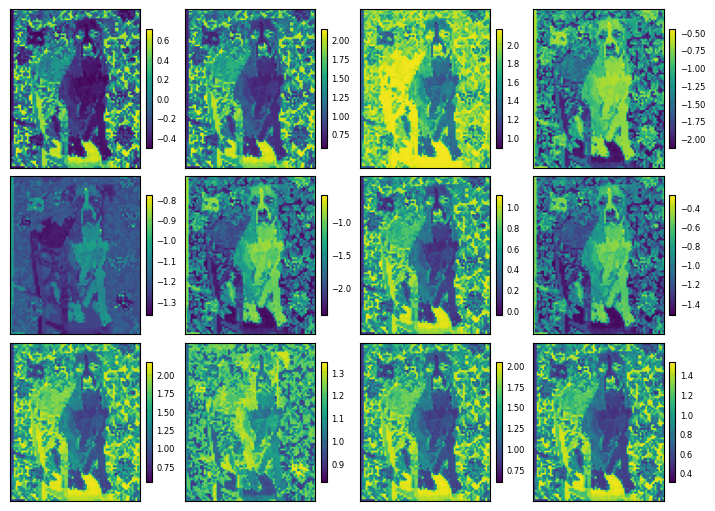

In [32]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


In [33]:
encoder = Encoder(latent_dim=3).to(device)
decoder = Decoder(latent_dim=3).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [34]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [35]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [36]:
random_seed(seed=42)

Train(model, encoder, decoder, train_iterator, optimizer, 500, device=device)


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.77it/s]

Epoch 0, Train Loss: 2.0366
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.87it/s]

Epoch 1, Train Loss: 2.0331
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.60it/s]

Epoch 2, Train Loss: 2.0296
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.54it/s]

Epoch 3, Train Loss: 2.0262
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.31it/s]

Epoch 4, Train Loss: 2.0227
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.43it/s]

Epoch 5, Train Loss: 2.0193
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.92it/s]

Epoch 6, Train Loss: 2.0158
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.84it/s]

Epoch 7, Train Loss: 2.0124
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.27it/s]

Epoch 8, Train Loss: 2.0089
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.09it/s]

Epoch 9, Train Loss: 2.0054
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.08it/s]

Epoch 10, Train Loss: 2.0019
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.01it/s]

Epoch 11, Train Loss: 1.9984
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.39it/s]

Epoch 12, Train Loss: 1.9948
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.37it/s]

Epoch 13, Train Loss: 1.9912
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.93it/s]

Epoch 14, Train Loss: 1.9876
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.61it/s]

Epoch 15, Train Loss: 1.9839
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.38it/s]

Epoch 16, Train Loss: 1.9801
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.94it/s]

Epoch 17, Train Loss: 1.9763
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.72it/s]

Epoch 18, Train Loss: 1.9725
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.60it/s]

Epoch 19, Train Loss: 1.9685
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.98it/s]

Epoch 20, Train Loss: 1.9645
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.53it/s]

Epoch 21, Train Loss: 1.9604
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.62it/s]

Epoch 22, Train Loss: 1.9562
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.64it/s]

Epoch 23, Train Loss: 1.9519
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.71it/s]

Epoch 24, Train Loss: 1.9476
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.41it/s]

Epoch 25, Train Loss: 1.9431
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.31it/s]

Epoch 26, Train Loss: 1.9384
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.87it/s]

Epoch 27, Train Loss: 1.9337
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.71it/s]

Epoch 28, Train Loss: 1.9288
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.13it/s]

Epoch 29, Train Loss: 1.9238
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.87it/s]

Epoch 30, Train Loss: 1.9186
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.05it/s]

Epoch 31, Train Loss: 1.9133
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.16it/s]

Epoch 32, Train Loss: 1.9077
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.13it/s]

Epoch 33, Train Loss: 1.9021
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.80it/s]

Epoch 34, Train Loss: 1.8962
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.69it/s]

Epoch 35, Train Loss: 1.8901
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.51it/s]

Epoch 36, Train Loss: 1.8838
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.90it/s]

Epoch 37, Train Loss: 1.8773
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 166.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.46it/s]

Epoch 38, Train Loss: 1.8705
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.32it/s]

Epoch 39, Train Loss: 1.8635
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.17it/s]

Epoch 40, Train Loss: 1.8563
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.01it/s]

Epoch 41, Train Loss: 1.8487
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.03it/s]

Epoch 42, Train Loss: 1.8409
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.40it/s]

Epoch 43, Train Loss: 1.8328
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.35it/s]

Epoch 44, Train Loss: 1.8244
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.28it/s]

Epoch 45, Train Loss: 1.8156
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.67it/s]

Epoch 46, Train Loss: 1.8065
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.41it/s]

Epoch 47, Train Loss: 1.7971
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.93it/s]

Epoch 48, Train Loss: 1.7872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.35it/s]

Epoch 49, Train Loss: 1.7770
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.63it/s]

Epoch 50, Train Loss: 1.7664
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.82it/s]

Epoch 51, Train Loss: 1.7553
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.83it/s]

Epoch 52, Train Loss: 1.7437
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.22it/s]

Epoch 53, Train Loss: 1.7317
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.79it/s]

Epoch 54, Train Loss: 1.7192
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.68it/s]

Epoch 55, Train Loss: 1.7062
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.92it/s]

Epoch 56, Train Loss: 1.6927
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.41it/s]

Epoch 57, Train Loss: 1.6786
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.52it/s]

Epoch 58, Train Loss: 1.6640
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.93it/s]

Epoch 59, Train Loss: 1.6488
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.01it/s]

Epoch 60, Train Loss: 1.6331
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.79it/s]

Epoch 61, Train Loss: 1.6169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.22it/s]

Epoch 62, Train Loss: 1.6002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.55it/s]

Epoch 63, Train Loss: 1.5830
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.48it/s]

Epoch 64, Train Loss: 1.5653
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.92it/s]

Epoch 65, Train Loss: 1.5472
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.94it/s]

Epoch 66, Train Loss: 1.5287
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.10it/s]

Epoch 67, Train Loss: 1.5099
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.87it/s]

Epoch 68, Train Loss: 1.4908
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.73it/s]

Epoch 69, Train Loss: 1.4715
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.36it/s]

Epoch 70, Train Loss: 1.4519
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.57it/s]

Epoch 71, Train Loss: 1.4322
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.76it/s]

Epoch 72, Train Loss: 1.4124
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.95it/s]

Epoch 73, Train Loss: 1.3925
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.59it/s]

Epoch 74, Train Loss: 1.3726
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.43it/s]

Epoch 75, Train Loss: 1.3526
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.39it/s]

Epoch 76, Train Loss: 1.3327
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.08it/s]

Epoch 77, Train Loss: 1.3128
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.41it/s]

Epoch 78, Train Loss: 1.2929
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 180.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.73it/s]

Epoch 79, Train Loss: 1.2731
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.62it/s]

Epoch 80, Train Loss: 1.2534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.84it/s]

Epoch 81, Train Loss: 1.2337
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.79it/s]

Epoch 82, Train Loss: 1.2141
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.91it/s]

Epoch 83, Train Loss: 1.1946
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.76it/s]

Epoch 84, Train Loss: 1.1752
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.34it/s]

Epoch 85, Train Loss: 1.1558
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.10it/s]

Epoch 86, Train Loss: 1.1365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.58it/s]

Epoch 87, Train Loss: 1.1172
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.79it/s]

Epoch 88, Train Loss: 1.0979
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.08it/s]

Epoch 89, Train Loss: 1.0786
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.51it/s]

Epoch 90, Train Loss: 1.0593
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.87it/s]

Epoch 91, Train Loss: 1.0400
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.71it/s]

Epoch 92, Train Loss: 1.0206
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.69it/s]

Epoch 93, Train Loss: 1.0010
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.74it/s]

Epoch 94, Train Loss: 0.9814
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.34it/s]

Epoch 95, Train Loss: 0.9616
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.49it/s]

Epoch 96, Train Loss: 0.9417
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.89it/s]

Epoch 97, Train Loss: 0.9216
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.20it/s]

Epoch 98, Train Loss: 0.9012
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.12it/s]

Epoch 99, Train Loss: 0.8807
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.70it/s]

Epoch 100, Train Loss: 0.8600
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.91it/s]

Epoch 101, Train Loss: 0.8391
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.80it/s]

Epoch 102, Train Loss: 0.8181
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.33it/s]

Epoch 103, Train Loss: 0.7968
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.52it/s]

Epoch 104, Train Loss: 0.7754
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.13it/s]

Epoch 105, Train Loss: 0.7539
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.12it/s]

Epoch 106, Train Loss: 0.7324
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.58it/s]

Epoch 107, Train Loss: 0.7108
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.25it/s]

Epoch 108, Train Loss: 0.6893
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.05it/s]

Epoch 109, Train Loss: 0.6680
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.30it/s]

Epoch 110, Train Loss: 0.6468
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.57it/s]

Epoch 111, Train Loss: 0.6259
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.81it/s]

Epoch 112, Train Loss: 0.6053
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.04it/s]

Epoch 113, Train Loss: 0.5853
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.01it/s]

Epoch 114, Train Loss: 0.5657
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.28it/s]

Epoch 115, Train Loss: 0.5467
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.21it/s]

Epoch 116, Train Loss: 0.5284
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.78it/s]

Epoch 117, Train Loss: 0.5108
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.37it/s]

Epoch 118, Train Loss: 0.4939
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.48it/s]

Epoch 119, Train Loss: 0.4779
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.76it/s]

Epoch 120, Train Loss: 0.4626
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.22it/s]

Epoch 121, Train Loss: 0.4482
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.63it/s]

Epoch 122, Train Loss: 0.4346
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.97it/s]

Epoch 123, Train Loss: 0.4218
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.01it/s]

Epoch 124, Train Loss: 0.4097
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.44it/s]

Epoch 125, Train Loss: 0.3984
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.06it/s]

Epoch 126, Train Loss: 0.3878
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.79it/s]

Epoch 127, Train Loss: 0.3778
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.66it/s]

Epoch 128, Train Loss: 0.3685
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.98it/s]

Epoch 129, Train Loss: 0.3597
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.81it/s]

Epoch 130, Train Loss: 0.3515
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.11it/s]

Epoch 131, Train Loss: 0.3438
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.60it/s]

Epoch 132, Train Loss: 0.3365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.12it/s]

Epoch 133, Train Loss: 0.3297
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.78it/s]

Epoch 134, Train Loss: 0.3232
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.74it/s]

Epoch 135, Train Loss: 0.3171
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.62it/s]

Epoch 136, Train Loss: 0.3114
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.13it/s]

Epoch 137, Train Loss: 0.3060
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.08it/s]

Epoch 138, Train Loss: 0.3009
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.00it/s]

Epoch 139, Train Loss: 0.2961
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.07it/s]

Epoch 140, Train Loss: 0.2915
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.09it/s]

Epoch 141, Train Loss: 0.2872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.31it/s]

Epoch 142, Train Loss: 0.2831
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.51it/s]

Epoch 143, Train Loss: 0.2792
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.11it/s]

Epoch 144, Train Loss: 0.2756
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.83it/s]

Epoch 145, Train Loss: 0.2721
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.09it/s]

Epoch 146, Train Loss: 0.2688
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.58it/s]

Epoch 147, Train Loss: 0.2657
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.28it/s]

Epoch 148, Train Loss: 0.2628
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.77it/s]

Epoch 149, Train Loss: 0.2600
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.92it/s]

Epoch 150, Train Loss: 0.2574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.35it/s]

Epoch 151, Train Loss: 0.2549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.05it/s]

Epoch 152, Train Loss: 0.2525
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.93it/s]

Epoch 153, Train Loss: 0.2502
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.88it/s]

Epoch 154, Train Loss: 0.2481
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.30it/s]

Epoch 155, Train Loss: 0.2461
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.03it/s]

Epoch 156, Train Loss: 0.2441
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 239.98it/s]

Epoch 157, Train Loss: 0.2423
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.57it/s]

Epoch 158, Train Loss: 0.2405
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.45it/s]

Epoch 159, Train Loss: 0.2389
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.99it/s]

Epoch 160, Train Loss: 0.2373
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.86it/s]

Epoch 161, Train Loss: 0.2358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.81it/s]

Epoch 162, Train Loss: 0.2343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.30it/s]

Epoch 163, Train Loss: 0.2329
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.84it/s]

Epoch 164, Train Loss: 0.2316
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.48it/s]

Epoch 165, Train Loss: 0.2303
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.66it/s]

Epoch 166, Train Loss: 0.2291
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.71it/s]

Epoch 167, Train Loss: 0.2280
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.43it/s]

Epoch 168, Train Loss: 0.2269
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.36it/s]

Epoch 169, Train Loss: 0.2258
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.70it/s]

Epoch 170, Train Loss: 0.2248
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.38it/s]

Epoch 171, Train Loss: 0.2238
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.24it/s]

Epoch 172, Train Loss: 0.2228
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.57it/s]

Epoch 173, Train Loss: 0.2219
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.85it/s]

Epoch 174, Train Loss: 0.2210
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.66it/s]

Epoch 175, Train Loss: 0.2201
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.52it/s]

Epoch 176, Train Loss: 0.2193
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.56it/s]

Epoch 177, Train Loss: 0.2185
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.55it/s]

Epoch 178, Train Loss: 0.2177
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.45it/s]

Epoch 179, Train Loss: 0.2169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.23it/s]

Epoch 180, Train Loss: 0.2162
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.55it/s]

Epoch 181, Train Loss: 0.2155
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.17it/s]

Epoch 182, Train Loss: 0.2147
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.53it/s]

Epoch 183, Train Loss: 0.2140
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.12it/s]

Epoch 184, Train Loss: 0.2134
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.57it/s]

Epoch 185, Train Loss: 0.2127
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.26it/s]

Epoch 186, Train Loss: 0.2120
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.93it/s]

Epoch 187, Train Loss: 0.2114
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.34it/s]

Epoch 188, Train Loss: 0.2108
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.75it/s]

Epoch 189, Train Loss: 0.2101
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.64it/s]

Epoch 190, Train Loss: 0.2095
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.03it/s]

Epoch 191, Train Loss: 0.2089
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.53it/s]

Epoch 192, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.60it/s]

Epoch 193, Train Loss: 0.2078
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.35it/s]

Epoch 194, Train Loss: 0.2072
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.77it/s]

Epoch 195, Train Loss: 0.2066
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.36it/s]

Epoch 196, Train Loss: 0.2061
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.38it/s]

Epoch 197, Train Loss: 0.2055
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.63it/s]

Epoch 198, Train Loss: 0.2049
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.49it/s]

Epoch 199, Train Loss: 0.2044
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.98it/s]

Epoch 200, Train Loss: 0.2039
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.15it/s]

Epoch 201, Train Loss: 0.2033
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.01it/s]

Epoch 202, Train Loss: 0.2028
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.86it/s]

Epoch 203, Train Loss: 0.2023
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.99it/s]

Epoch 204, Train Loss: 0.2018
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.58it/s]

Epoch 205, Train Loss: 0.2013
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.90it/s]

Epoch 206, Train Loss: 0.2008
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.23it/s]

Epoch 207, Train Loss: 0.2002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.11it/s]

Epoch 208, Train Loss: 0.1998
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.79it/s]

Epoch 209, Train Loss: 0.1993
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.49it/s]

Epoch 210, Train Loss: 0.1988
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.78it/s]

Epoch 211, Train Loss: 0.1983
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 241.59it/s]

Epoch 212, Train Loss: 0.1978
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.57it/s]

Epoch 213, Train Loss: 0.1973
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.06it/s]

Epoch 214, Train Loss: 0.1968
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.32it/s]

Epoch 215, Train Loss: 0.1964
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.96it/s]

Epoch 216, Train Loss: 0.1959
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.69it/s]

Epoch 217, Train Loss: 0.1955
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.70it/s]

Epoch 218, Train Loss: 0.1950
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.33it/s]

Epoch 219, Train Loss: 0.1945
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.03it/s]

Epoch 220, Train Loss: 0.1941
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.74it/s]

Epoch 221, Train Loss: 0.1936
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.56it/s]

Epoch 222, Train Loss: 0.1932
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.65it/s]

Epoch 223, Train Loss: 0.1928
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.10it/s]

Epoch 224, Train Loss: 0.1923
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.97it/s]

Epoch 225, Train Loss: 0.1919
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.55it/s]

Epoch 226, Train Loss: 0.1915
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.55it/s]

Epoch 227, Train Loss: 0.1910
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.38it/s]

Epoch 228, Train Loss: 0.1906
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.56it/s]

Epoch 229, Train Loss: 0.1902
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.81it/s]

Epoch 230, Train Loss: 0.1898
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.28it/s]

Epoch 231, Train Loss: 0.1894
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.32it/s]

Epoch 232, Train Loss: 0.1889
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.36it/s]

Epoch 233, Train Loss: 0.1885
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.90it/s]

Epoch 234, Train Loss: 0.1881
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.85it/s]

Epoch 235, Train Loss: 0.1877
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.57it/s]

Epoch 236, Train Loss: 0.1873
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.63it/s]

Epoch 237, Train Loss: 0.1869
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.75it/s]

Epoch 238, Train Loss: 0.1865
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.00it/s]

Epoch 239, Train Loss: 0.1861
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.39it/s]

Epoch 240, Train Loss: 0.1858
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.12it/s]

Epoch 241, Train Loss: 0.1854
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.65it/s]

Epoch 242, Train Loss: 0.1850
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.15it/s]

Epoch 243, Train Loss: 0.1846
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.11it/s]

Epoch 244, Train Loss: 0.1842
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.05it/s]

Epoch 245, Train Loss: 0.1838
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.89it/s]

Epoch 246, Train Loss: 0.1835
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.15it/s]

Epoch 247, Train Loss: 0.1831
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.61it/s]

Epoch 248, Train Loss: 0.1827
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.30it/s]

Epoch 249, Train Loss: 0.1823
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.12it/s]

Epoch 250, Train Loss: 0.1820
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.00it/s]

Epoch 251, Train Loss: 0.1816
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.91it/s]

Epoch 252, Train Loss: 0.1812
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.65it/s]

Epoch 253, Train Loss: 0.1809
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.32it/s]

Epoch 254, Train Loss: 0.1805
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.54it/s]

Epoch 255, Train Loss: 0.1802
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.94it/s]

Epoch 256, Train Loss: 0.1798
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.26it/s]

Epoch 257, Train Loss: 0.1794
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.71it/s]

Epoch 258, Train Loss: 0.1791
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.93it/s]

Epoch 259, Train Loss: 0.1787
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.54it/s]

Epoch 260, Train Loss: 0.1784
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.20it/s]

Epoch 261, Train Loss: 0.1780
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.16it/s]

Epoch 262, Train Loss: 0.1777
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.43it/s]

Epoch 263, Train Loss: 0.1773
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.47it/s]

Epoch 264, Train Loss: 0.1770
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.65it/s]

Epoch 265, Train Loss: 0.1766
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.39it/s]

Epoch 266, Train Loss: 0.1763
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 230.85it/s]

Epoch 267, Train Loss: 0.1759
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.47it/s]

Epoch 268, Train Loss: 0.1756
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.18it/s]

Epoch 269, Train Loss: 0.1752
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.85it/s]

Epoch 270, Train Loss: 0.1749
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.89it/s]

Epoch 271, Train Loss: 0.1746
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.28it/s]

Epoch 272, Train Loss: 0.1742
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.42it/s]

Epoch 273, Train Loss: 0.1739
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.95it/s]

Epoch 274, Train Loss: 0.1735
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.59it/s]

Epoch 275, Train Loss: 0.1732
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.14it/s]

Epoch 276, Train Loss: 0.1729
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.62it/s]

Epoch 277, Train Loss: 0.1725
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.64it/s]

Epoch 278, Train Loss: 0.1722
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.65it/s]

Epoch 279, Train Loss: 0.1719
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.92it/s]

Epoch 280, Train Loss: 0.1715
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.28it/s]

Epoch 281, Train Loss: 0.1712
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.94it/s]

Epoch 282, Train Loss: 0.1709
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.81it/s]

Epoch 283, Train Loss: 0.1705
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.70it/s]

Epoch 284, Train Loss: 0.1702
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.29it/s]

Epoch 285, Train Loss: 0.1699
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.93it/s]

Epoch 286, Train Loss: 0.1695
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.96it/s]

Epoch 287, Train Loss: 0.1692
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.97it/s]

Epoch 288, Train Loss: 0.1689
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.65it/s]

Epoch 289, Train Loss: 0.1686
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.62it/s]

Epoch 290, Train Loss: 0.1682
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.83it/s]

Epoch 291, Train Loss: 0.1679
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.24it/s]

Epoch 292, Train Loss: 0.1676
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.13it/s]

Epoch 293, Train Loss: 0.1673
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.59it/s]

Epoch 294, Train Loss: 0.1670
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.03it/s]

Epoch 295, Train Loss: 0.1667
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.61it/s]

Epoch 296, Train Loss: 0.1663
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.14it/s]

Epoch 297, Train Loss: 0.1660
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.01it/s]

Epoch 298, Train Loss: 0.1657
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.03it/s]

Epoch 299, Train Loss: 0.1654
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.56it/s]

Epoch 300, Train Loss: 0.1651
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.17it/s]

Epoch 301, Train Loss: 0.1648
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.42it/s]

Epoch 302, Train Loss: 0.1645
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.13it/s]

Epoch 303, Train Loss: 0.1642
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.58it/s]

Epoch 304, Train Loss: 0.1639
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.43it/s]

Epoch 305, Train Loss: 0.1636
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.04it/s]

Epoch 306, Train Loss: 0.1633
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.91it/s]

Epoch 307, Train Loss: 0.1630
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.86it/s]

Epoch 308, Train Loss: 0.1627
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.70it/s]

Epoch 309, Train Loss: 0.1624
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.73it/s]

Epoch 310, Train Loss: 0.1621
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.60it/s]

Epoch 311, Train Loss: 0.1618
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.13it/s]

Epoch 312, Train Loss: 0.1616
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.37it/s]

Epoch 313, Train Loss: 0.1613
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.76it/s]

Epoch 314, Train Loss: 0.1610
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.04it/s]

Epoch 315, Train Loss: 0.1607
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.47it/s]

Epoch 316, Train Loss: 0.1604
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.70it/s]

Epoch 317, Train Loss: 0.1602
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.04it/s]

Epoch 318, Train Loss: 0.1599
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.68it/s]

Epoch 319, Train Loss: 0.1596
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.98it/s]

Epoch 320, Train Loss: 0.1593
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.75it/s]

Epoch 321, Train Loss: 0.1591
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.74it/s]

Epoch 322, Train Loss: 0.1588
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.94it/s]

Epoch 323, Train Loss: 0.1585
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.47it/s]

Epoch 324, Train Loss: 0.1583
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.12it/s]

Epoch 325, Train Loss: 0.1580
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.09it/s]

Epoch 326, Train Loss: 0.1578
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.04it/s]

Epoch 327, Train Loss: 0.1575
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.91it/s]

Epoch 328, Train Loss: 0.1573
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.73it/s]

Epoch 329, Train Loss: 0.1570
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.37it/s]

Epoch 330, Train Loss: 0.1568
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.71it/s]

Epoch 331, Train Loss: 0.1565
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.71it/s]

Epoch 332, Train Loss: 0.1563
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.30it/s]

Epoch 333, Train Loss: 0.1561
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.93it/s]

Epoch 334, Train Loss: 0.1558
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.30it/s]

Epoch 335, Train Loss: 0.1556
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.30it/s]

Epoch 336, Train Loss: 0.1554
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.86it/s]

Epoch 337, Train Loss: 0.1551
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.11it/s]

Epoch 338, Train Loss: 0.1549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 235.00it/s]

Epoch 339, Train Loss: 0.1547
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 237.54it/s]

Epoch 340, Train Loss: 0.1544
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.25it/s]

Epoch 341, Train Loss: 0.1542
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.90it/s]

Epoch 342, Train Loss: 0.1540
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.56it/s]

Epoch 343, Train Loss: 0.1538
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 236.97it/s]

Epoch 344, Train Loss: 0.1536
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.41it/s]

Epoch 345, Train Loss: 0.1534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.13it/s]

Epoch 346, Train Loss: 0.1532
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.12it/s]

Epoch 347, Train Loss: 0.1530
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.32it/s]

Epoch 348, Train Loss: 0.1528
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.18it/s]

Epoch 349, Train Loss: 0.1525
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.26it/s]

Epoch 350, Train Loss: 0.1523
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.33it/s]

Epoch 351, Train Loss: 0.1522
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.96it/s]

Epoch 352, Train Loss: 0.1520
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.86it/s]

Epoch 353, Train Loss: 0.1518
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.05it/s]

Epoch 354, Train Loss: 0.1516
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.44it/s]

Epoch 355, Train Loss: 0.1514
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.87it/s]

Epoch 356, Train Loss: 0.1512
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.42it/s]

Epoch 357, Train Loss: 0.1510
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.73it/s]

Epoch 358, Train Loss: 0.1508
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.88it/s]

Epoch 359, Train Loss: 0.1506
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.68it/s]

Epoch 360, Train Loss: 0.1505
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.24it/s]

Epoch 361, Train Loss: 0.1503
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.06it/s]

Epoch 362, Train Loss: 0.1501
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.44it/s]

Epoch 363, Train Loss: 0.1499
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.52it/s]

Epoch 364, Train Loss: 0.1498
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.84it/s]

Epoch 365, Train Loss: 0.1496
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.83it/s]

Epoch 366, Train Loss: 0.1494
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.55it/s]

Epoch 367, Train Loss: 0.1492
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.48it/s]

Epoch 368, Train Loss: 0.1491
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.75it/s]

Epoch 369, Train Loss: 0.1489
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.60it/s]

Epoch 370, Train Loss: 0.1487
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 238.29it/s]

Epoch 371, Train Loss: 0.1486
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.72it/s]

Epoch 372, Train Loss: 0.1484
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.78it/s]

Epoch 373, Train Loss: 0.1483
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.69it/s]

Epoch 374, Train Loss: 0.1481
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.61it/s]

Epoch 375, Train Loss: 0.1479
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.22it/s]

Epoch 376, Train Loss: 0.1478
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.20it/s]

Epoch 377, Train Loss: 0.1476
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.62it/s]

Epoch 378, Train Loss: 0.1475
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.68it/s]

Epoch 379, Train Loss: 0.1473
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.36it/s]

Epoch 380, Train Loss: 0.1472
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.86it/s]

Epoch 381, Train Loss: 0.1470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.93it/s]

Epoch 382, Train Loss: 0.1469
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.85it/s]

Epoch 383, Train Loss: 0.1467
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 240.93it/s]

Epoch 384, Train Loss: 0.1466
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.30it/s]

Epoch 385, Train Loss: 0.1464
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.83it/s]

Epoch 386, Train Loss: 0.1463
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.85it/s]

Epoch 387, Train Loss: 0.1461
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.90it/s]

Epoch 388, Train Loss: 0.1460
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.44it/s]

Epoch 389, Train Loss: 0.1459
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.30it/s]

Epoch 390, Train Loss: 0.1457
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.07it/s]

Epoch 391, Train Loss: 0.1456
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.77it/s]

Epoch 392, Train Loss: 0.1454
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 234.49it/s]

Epoch 393, Train Loss: 0.1453
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.20it/s]

Epoch 394, Train Loss: 0.1452
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 226.58it/s]

Epoch 395, Train Loss: 0.1450
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.77it/s]

Epoch 396, Train Loss: 0.1449
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.15it/s]

Epoch 397, Train Loss: 0.1447
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.25it/s]

Epoch 398, Train Loss: 0.1446
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.60it/s]

Epoch 399, Train Loss: 0.1445
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.89it/s]

Epoch 400, Train Loss: 0.1443
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.43it/s]

Epoch 401, Train Loss: 0.1442
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.78it/s]

Epoch 402, Train Loss: 0.1441
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.15it/s]

Epoch 403, Train Loss: 0.1439
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.01it/s]

Epoch 404, Train Loss: 0.1438
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.27it/s]

Epoch 405, Train Loss: 0.1437
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.14it/s]

Epoch 406, Train Loss: 0.1435
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.55it/s]

Epoch 407, Train Loss: 0.1434
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.04it/s]

Epoch 408, Train Loss: 0.1433
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.82it/s]

Epoch 409, Train Loss: 0.1432
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.06it/s]

Epoch 410, Train Loss: 0.1430
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.09it/s]

Epoch 411, Train Loss: 0.1429
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.66it/s]

Epoch 412, Train Loss: 0.1428
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.35it/s]

Epoch 413, Train Loss: 0.1426
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 224.75it/s]

Epoch 414, Train Loss: 0.1425
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.46it/s]

Epoch 415, Train Loss: 0.1424
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.04it/s]

Epoch 416, Train Loss: 0.1423
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.13it/s]

Epoch 417, Train Loss: 0.1421
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 229.04it/s]

Epoch 418, Train Loss: 0.1420
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.52it/s]

Epoch 419, Train Loss: 0.1419
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.40it/s]

Epoch 420, Train Loss: 0.1418
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.00it/s]

Epoch 421, Train Loss: 0.1417
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.11it/s]

Epoch 422, Train Loss: 0.1415
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.74it/s]

Epoch 423, Train Loss: 0.1414
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.73it/s]

Epoch 424, Train Loss: 0.1413
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.21it/s]

Epoch 425, Train Loss: 0.1412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.01it/s]

Epoch 426, Train Loss: 0.1410
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.19it/s]

Epoch 427, Train Loss: 0.1409
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.39it/s]

Epoch 428, Train Loss: 0.1408
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.96it/s]

Epoch 429, Train Loss: 0.1407
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.15it/s]

Epoch 430, Train Loss: 0.1406
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.42it/s]

Epoch 431, Train Loss: 0.1404
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.26it/s]

Epoch 432, Train Loss: 0.1403
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 227.00it/s]

Epoch 433, Train Loss: 0.1402
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.28it/s]

Epoch 434, Train Loss: 0.1401
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.00it/s]

Epoch 435, Train Loss: 0.1400
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.76it/s]

Epoch 436, Train Loss: 0.1399
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.14it/s]

Epoch 437, Train Loss: 0.1397
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.14it/s]

Epoch 438, Train Loss: 0.1396
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.03it/s]

Epoch 439, Train Loss: 0.1395
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 232.58it/s]

Epoch 440, Train Loss: 0.1394
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.34it/s]

Epoch 441, Train Loss: 0.1393
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.86it/s]

Epoch 442, Train Loss: 0.1392
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.52it/s]

Epoch 443, Train Loss: 0.1390
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.69it/s]

Epoch 444, Train Loss: 0.1389
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.05it/s]

Epoch 445, Train Loss: 0.1388
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.36it/s]

Epoch 446, Train Loss: 0.1387
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 233.37it/s]

Epoch 447, Train Loss: 0.1386
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.75it/s]

Epoch 448, Train Loss: 0.1385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.99it/s]

Epoch 449, Train Loss: 0.1383
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.19it/s]

Epoch 450, Train Loss: 0.1382
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.93it/s]

Epoch 451, Train Loss: 0.1381
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.97it/s]

Epoch 452, Train Loss: 0.1380
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.18it/s]

Epoch 453, Train Loss: 0.1379
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.64it/s]

Epoch 454, Train Loss: 0.1378
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.49it/s]

Epoch 455, Train Loss: 0.1377
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.91it/s]

Epoch 456, Train Loss: 0.1376
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 215.63it/s]

Epoch 457, Train Loss: 0.1374
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.82it/s]

Epoch 458, Train Loss: 0.1373
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.84it/s]

Epoch 459, Train Loss: 0.1372
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.05it/s]

Epoch 460, Train Loss: 0.1371
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.96it/s]

Epoch 461, Train Loss: 0.1370
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.64it/s]

Epoch 462, Train Loss: 0.1369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.87it/s]

Epoch 463, Train Loss: 0.1368
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.78it/s]

Epoch 464, Train Loss: 0.1367
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.06it/s]

Epoch 465, Train Loss: 0.1365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.51it/s]

Epoch 466, Train Loss: 0.1364
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.01it/s]

Epoch 467, Train Loss: 0.1363
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.50it/s]

Epoch 468, Train Loss: 0.1362
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.92it/s]

Epoch 469, Train Loss: 0.1361
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.05it/s]

Epoch 470, Train Loss: 0.1360
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 225.74it/s]

Epoch 471, Train Loss: 0.1359
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.39it/s]

Epoch 472, Train Loss: 0.1358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.58it/s]

Epoch 473, Train Loss: 0.1357
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.25it/s]

Epoch 474, Train Loss: 0.1356
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.27it/s]

Epoch 475, Train Loss: 0.1354
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.17it/s]

Epoch 476, Train Loss: 0.1353
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.96it/s]

Epoch 477, Train Loss: 0.1352
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.07it/s]

Epoch 478, Train Loss: 0.1351
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.16it/s]

Epoch 479, Train Loss: 0.1350
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.56it/s]

Epoch 480, Train Loss: 0.1349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.26it/s]

Epoch 481, Train Loss: 0.1348
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 231.24it/s]

Epoch 482, Train Loss: 0.1347
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.44it/s]

Epoch 483, Train Loss: 0.1346
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.73it/s]

Epoch 484, Train Loss: 0.1345
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.93it/s]

Epoch 485, Train Loss: 0.1344
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.18it/s]

Epoch 486, Train Loss: 0.1343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.75it/s]

Epoch 487, Train Loss: 0.1342
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 219.24it/s]

Epoch 488, Train Loss: 0.1340
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 222.77it/s]

Epoch 489, Train Loss: 0.1339
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 220.20it/s]

Epoch 490, Train Loss: 0.1338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.16it/s]

Epoch 491, Train Loss: 0.1337
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 218.44it/s]

Epoch 492, Train Loss: 0.1336
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 228.37it/s]

Epoch 493, Train Loss: 0.1335
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.58it/s]

Epoch 494, Train Loss: 0.1334
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.93it/s]

Epoch 495, Train Loss: 0.1333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.58it/s]

Epoch 496, Train Loss: 0.1332
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.15it/s]

Epoch 497, Train Loss: 0.1331
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.33it/s]

Epoch 498, Train Loss: 0.1330
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 223.73it/s]

Epoch 499, Train Loss: 0.1329
.............................


In [37]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


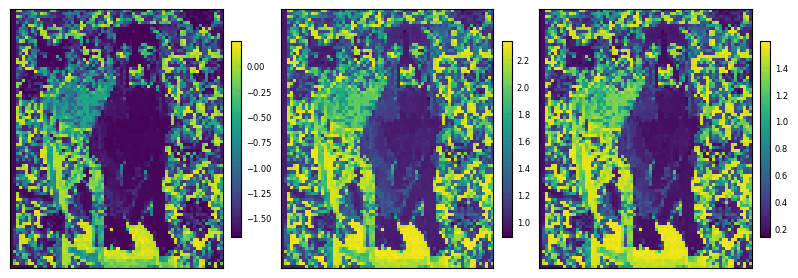

In [38]:
embeddings(encode, shape_=image.shape[0:2], figsize=(10, 5))


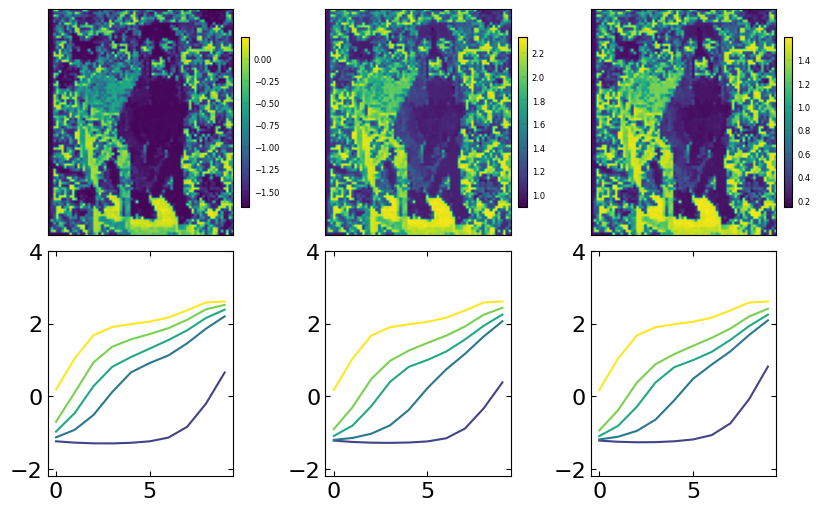

In [39]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(10, 5), divider_=False)


In [40]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)  # add a relu
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12,
                            batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [41]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)


In [42]:
model


Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [43]:
train_iterator = torch.utils.data.DataLoader(
    np.atleast_3d(X_train), batch_size=256, shuffle=False
)


In [44]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    coef=1e-3, # adds a regularization term l1
    mse=False,
    device=device,
)


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.76it/s]

Epoch 0, Train Loss: 2.1840
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.76it/s]

Epoch 1, Train Loss: 2.1752
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.36it/s]

Epoch 2, Train Loss: 2.1666
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.35it/s]

Epoch 3, Train Loss: 2.1581
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.47it/s]

Epoch 4, Train Loss: 2.1497
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.32it/s]

Epoch 5, Train Loss: 2.1414
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.20it/s]

Epoch 6, Train Loss: 2.1332
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.56it/s]

Epoch 7, Train Loss: 2.1250
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.51it/s]

Epoch 8, Train Loss: 2.1169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.33it/s]

Epoch 9, Train Loss: 2.1088
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.83it/s]

Epoch 10, Train Loss: 2.1007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.98it/s]

Epoch 11, Train Loss: 2.0927
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.41it/s]

Epoch 12, Train Loss: 2.0848
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.23it/s]

Epoch 13, Train Loss: 2.0770
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.81it/s]

Epoch 14, Train Loss: 2.0693
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.37it/s]

Epoch 15, Train Loss: 2.0616
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.14it/s]

Epoch 16, Train Loss: 2.0540
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.59it/s]

Epoch 17, Train Loss: 2.0464
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.71it/s]

Epoch 18, Train Loss: 2.0389
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.93it/s]

Epoch 19, Train Loss: 2.0315
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.44it/s]

Epoch 20, Train Loss: 2.0242
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.45it/s]

Epoch 21, Train Loss: 2.0170
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 169.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.66it/s]

Epoch 22, Train Loss: 2.0099
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.20it/s]

Epoch 23, Train Loss: 2.0028
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.20it/s]

Epoch 24, Train Loss: 1.9958
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.69it/s]

Epoch 25, Train Loss: 1.9888
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.34it/s]

Epoch 26, Train Loss: 1.9819
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.50it/s]

Epoch 27, Train Loss: 1.9749
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.32it/s]

Epoch 28, Train Loss: 1.9679
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.80it/s]

Epoch 29, Train Loss: 1.9611
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.78it/s]

Epoch 30, Train Loss: 1.9546
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.70it/s]

Epoch 31, Train Loss: 1.9482
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.57it/s]

Epoch 32, Train Loss: 1.9419
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.54it/s]

Epoch 33, Train Loss: 1.9357
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.09it/s]

Epoch 34, Train Loss: 1.9296
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.05it/s]

Epoch 35, Train Loss: 1.9235
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.59it/s]

Epoch 36, Train Loss: 1.9176
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.99it/s]

Epoch 37, Train Loss: 1.9117
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.65it/s]

Epoch 38, Train Loss: 1.9058
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.36it/s]

Epoch 39, Train Loss: 1.8999
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.20it/s]

Epoch 40, Train Loss: 1.8940
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 217.68it/s]

Epoch 41, Train Loss: 1.8882
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.78it/s]

Epoch 42, Train Loss: 1.8824
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.25it/s]

Epoch 43, Train Loss: 1.8766
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.35it/s]

Epoch 44, Train Loss: 1.8707
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.07it/s]

Epoch 45, Train Loss: 1.8648
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.69it/s]

Epoch 46, Train Loss: 1.8589
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.22it/s]

Epoch 47, Train Loss: 1.8534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.24it/s]

Epoch 48, Train Loss: 1.8478
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.79it/s]

Epoch 49, Train Loss: 1.8423
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.12it/s]

Epoch 50, Train Loss: 1.8367
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.31it/s]

Epoch 51, Train Loss: 1.8312
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.40it/s]

Epoch 52, Train Loss: 1.8255
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.74it/s]

Epoch 53, Train Loss: 1.8199
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.38it/s]

Epoch 54, Train Loss: 1.8141
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.18it/s]

Epoch 55, Train Loss: 1.8082
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.73it/s]

Epoch 56, Train Loss: 1.8023
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.96it/s]

Epoch 57, Train Loss: 1.7962
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.06it/s]

Epoch 58, Train Loss: 1.7900
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.27it/s]

Epoch 59, Train Loss: 1.7837
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.97it/s]

Epoch 60, Train Loss: 1.7773
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.87it/s]

Epoch 61, Train Loss: 1.7707
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.61it/s]

Epoch 62, Train Loss: 1.7640
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.28it/s]

Epoch 63, Train Loss: 1.7573
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.41it/s]

Epoch 64, Train Loss: 1.7504
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.33it/s]

Epoch 65, Train Loss: 1.7435
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.35it/s]

Epoch 66, Train Loss: 1.7365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.93it/s]

Epoch 67, Train Loss: 1.7294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.47it/s]

Epoch 68, Train Loss: 1.7221
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.86it/s]

Epoch 69, Train Loss: 1.7147
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.15it/s]

Epoch 70, Train Loss: 1.7072
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.58it/s]

Epoch 71, Train Loss: 1.6994
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.96it/s]

Epoch 72, Train Loss: 1.6916
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.80it/s]

Epoch 73, Train Loss: 1.6836
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.01it/s]

Epoch 74, Train Loss: 1.6754
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.06it/s]

Epoch 75, Train Loss: 1.6672
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.83it/s]

Epoch 76, Train Loss: 1.6588
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.26it/s]

Epoch 77, Train Loss: 1.6503
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.49it/s]

Epoch 78, Train Loss: 1.6416
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.02it/s]

Epoch 79, Train Loss: 1.6329
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.58it/s]

Epoch 80, Train Loss: 1.6240
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.12it/s]

Epoch 81, Train Loss: 1.6150
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.80it/s]

Epoch 82, Train Loss: 1.6059
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.08it/s]

Epoch 83, Train Loss: 1.5967
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.39it/s]

Epoch 84, Train Loss: 1.5875
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.50it/s]

Epoch 85, Train Loss: 1.5781
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.50it/s]

Epoch 86, Train Loss: 1.5686
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.05it/s]

Epoch 87, Train Loss: 1.5590
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.43it/s]

Epoch 88, Train Loss: 1.5493
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.23it/s]

Epoch 89, Train Loss: 1.5394
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.68it/s]

Epoch 90, Train Loss: 1.5295
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.87it/s]

Epoch 91, Train Loss: 1.5194
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.52it/s]

Epoch 92, Train Loss: 1.5093
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.64it/s]

Epoch 93, Train Loss: 1.4992
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.22it/s]

Epoch 94, Train Loss: 1.4890
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.67it/s]

Epoch 95, Train Loss: 1.4787
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.30it/s]

Epoch 96, Train Loss: 1.4684
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.73it/s]

Epoch 97, Train Loss: 1.4581
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 169.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.90it/s]

Epoch 98, Train Loss: 1.4478
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.06it/s]

Epoch 99, Train Loss: 1.4376
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.34it/s]

Epoch 100, Train Loss: 1.4273
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.05it/s]

Epoch 101, Train Loss: 1.4171
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.24it/s]

Epoch 102, Train Loss: 1.4069
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.87it/s]

Epoch 103, Train Loss: 1.3967
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 142.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.06it/s]

Epoch 104, Train Loss: 1.3866
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.52it/s]

Epoch 105, Train Loss: 1.3766
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.28it/s]

Epoch 106, Train Loss: 1.3667
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.60it/s]

Epoch 107, Train Loss: 1.3568
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.22it/s]

Epoch 108, Train Loss: 1.3470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.20it/s]

Epoch 109, Train Loss: 1.3373
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.36it/s]

Epoch 110, Train Loss: 1.3277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.25it/s]

Epoch 111, Train Loss: 1.3182
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.05it/s]

Epoch 112, Train Loss: 1.3088
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.11it/s]

Epoch 113, Train Loss: 1.2995
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.17it/s]

Epoch 114, Train Loss: 1.2902
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.33it/s]

Epoch 115, Train Loss: 1.2811
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.15it/s]

Epoch 116, Train Loss: 1.2720
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.83it/s]

Epoch 117, Train Loss: 1.2630
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.37it/s]

Epoch 118, Train Loss: 1.2542
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.27it/s]

Epoch 119, Train Loss: 1.2455
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.18it/s]

Epoch 120, Train Loss: 1.2369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.45it/s]

Epoch 121, Train Loss: 1.2286
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.48it/s]

Epoch 122, Train Loss: 1.2203
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.15it/s]

Epoch 123, Train Loss: 1.2123
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.98it/s]

Epoch 124, Train Loss: 1.2043
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.88it/s]

Epoch 125, Train Loss: 1.1966
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.67it/s]

Epoch 126, Train Loss: 1.1890
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.62it/s]

Epoch 127, Train Loss: 1.1816
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.15it/s]

Epoch 128, Train Loss: 1.1743
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.94it/s]

Epoch 129, Train Loss: 1.1672
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.79it/s]

Epoch 130, Train Loss: 1.1602
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.44it/s]

Epoch 131, Train Loss: 1.1534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.34it/s]

Epoch 132, Train Loss: 1.1468
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.48it/s]

Epoch 133, Train Loss: 1.1404
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.92it/s]

Epoch 134, Train Loss: 1.1341
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.29it/s]

Epoch 135, Train Loss: 1.1279
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.78it/s]

Epoch 136, Train Loss: 1.1219
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 131.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 136.26it/s]

Epoch 137, Train Loss: 1.1161
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.96it/s]

Epoch 138, Train Loss: 1.1103
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.32it/s]

Epoch 139, Train Loss: 1.1048
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.77it/s]

Epoch 140, Train Loss: 1.0993
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.18it/s]

Epoch 141, Train Loss: 1.0940
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.97it/s]

Epoch 142, Train Loss: 1.0888
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.63it/s]

Epoch 143, Train Loss: 1.0837
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.98it/s]

Epoch 144, Train Loss: 1.0787
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.23it/s]

Epoch 145, Train Loss: 1.0738
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.28it/s]

Epoch 146, Train Loss: 1.0690
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.23it/s]

Epoch 147, Train Loss: 1.0642
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.08it/s]

Epoch 148, Train Loss: 1.0595
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.43it/s]

Epoch 149, Train Loss: 1.0549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.21it/s]

Epoch 150, Train Loss: 1.0502
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.81it/s]

Epoch 151, Train Loss: 1.0457
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.96it/s]

Epoch 152, Train Loss: 1.0411
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.44it/s]

Epoch 153, Train Loss: 1.0365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.25it/s]

Epoch 154, Train Loss: 1.0319
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.56it/s]

Epoch 155, Train Loss: 1.0273
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.93it/s]

Epoch 156, Train Loss: 1.0226
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.95it/s]

Epoch 157, Train Loss: 1.0179
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.85it/s]

Epoch 158, Train Loss: 1.0130
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.02it/s]

Epoch 159, Train Loss: 1.0081
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.11it/s]

Epoch 160, Train Loss: 1.0030
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.61it/s]

Epoch 161, Train Loss: 0.9977
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.70it/s]

Epoch 162, Train Loss: 0.9923
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.47it/s]

Epoch 163, Train Loss: 0.9866
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.82it/s]

Epoch 164, Train Loss: 0.9807
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.65it/s]

Epoch 165, Train Loss: 0.9745
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.60it/s]

Epoch 166, Train Loss: 0.9680
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.59it/s]

Epoch 167, Train Loss: 0.9611
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.08it/s]

Epoch 168, Train Loss: 0.9538
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.79it/s]

Epoch 169, Train Loss: 0.9460
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.25it/s]

Epoch 170, Train Loss: 0.9377
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.47it/s]

Epoch 171, Train Loss: 0.9289
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.23it/s]

Epoch 172, Train Loss: 0.9194
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.85it/s]

Epoch 173, Train Loss: 0.9092
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.36it/s]

Epoch 174, Train Loss: 0.8983
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.74it/s]

Epoch 175, Train Loss: 0.8866
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.69it/s]

Epoch 176, Train Loss: 0.8741
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.43it/s]

Epoch 177, Train Loss: 0.8608
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.19it/s]

Epoch 178, Train Loss: 0.8466
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.25it/s]

Epoch 179, Train Loss: 0.8315
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.83it/s]

Epoch 180, Train Loss: 0.8157
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 169.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.74it/s]

Epoch 181, Train Loss: 0.7990
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.12it/s]

Epoch 182, Train Loss: 0.7817
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.17it/s]

Epoch 183, Train Loss: 0.7639
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.02it/s]

Epoch 184, Train Loss: 0.7454
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.47it/s]

Epoch 185, Train Loss: 0.7260
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.05it/s]

Epoch 186, Train Loss: 0.7059
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.11it/s]

Epoch 187, Train Loss: 0.6858
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.20it/s]

Epoch 188, Train Loss: 0.6661
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.11it/s]

Epoch 189, Train Loss: 0.6470
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.25it/s]

Epoch 190, Train Loss: 0.6288
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.83it/s]

Epoch 191, Train Loss: 0.6116
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.36it/s]

Epoch 192, Train Loss: 0.5954
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 221.78it/s]

Epoch 193, Train Loss: 0.5802
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.38it/s]

Epoch 194, Train Loss: 0.5660
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.18it/s]

Epoch 195, Train Loss: 0.5529
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.48it/s]

Epoch 196, Train Loss: 0.5407
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.48it/s]

Epoch 197, Train Loss: 0.5293
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.93it/s]

Epoch 198, Train Loss: 0.5187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.19it/s]

Epoch 199, Train Loss: 0.5089
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.99it/s]

Epoch 200, Train Loss: 0.4998
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.21it/s]

Epoch 201, Train Loss: 0.4913
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.93it/s]

Epoch 202, Train Loss: 0.4834
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.09it/s]

Epoch 203, Train Loss: 0.4760
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.12it/s]

Epoch 204, Train Loss: 0.4690
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.10it/s]

Epoch 205, Train Loss: 0.4626
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 213.53it/s]

Epoch 206, Train Loss: 0.4565
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.75it/s]

Epoch 207, Train Loss: 0.4507
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.15it/s]

Epoch 208, Train Loss: 0.4453
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.23it/s]

Epoch 209, Train Loss: 0.4403
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.98it/s]

Epoch 210, Train Loss: 0.4355
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.98it/s]

Epoch 211, Train Loss: 0.4309
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.02it/s]

Epoch 212, Train Loss: 0.4266
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.25it/s]

Epoch 213, Train Loss: 0.4226
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.25it/s]

Epoch 214, Train Loss: 0.4187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.34it/s]

Epoch 215, Train Loss: 0.4150
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.08it/s]

Epoch 216, Train Loss: 0.4116
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.52it/s]

Epoch 217, Train Loss: 0.4083
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.48it/s]

Epoch 218, Train Loss: 0.4051
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.26it/s]

Epoch 219, Train Loss: 0.4022
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.69it/s]

Epoch 220, Train Loss: 0.3993
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.50it/s]

Epoch 221, Train Loss: 0.3966
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.09it/s]

Epoch 222, Train Loss: 0.3941
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.68it/s]

Epoch 223, Train Loss: 0.3916
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.03it/s]

Epoch 224, Train Loss: 0.3893
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.86it/s]

Epoch 225, Train Loss: 0.3871
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.17it/s]

Epoch 226, Train Loss: 0.3850
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.45it/s]

Epoch 227, Train Loss: 0.3829
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.01it/s]

Epoch 228, Train Loss: 0.3810
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.17it/s]

Epoch 229, Train Loss: 0.3792
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.78it/s]

Epoch 230, Train Loss: 0.3774
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.75it/s]

Epoch 231, Train Loss: 0.3757
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.35it/s]

Epoch 232, Train Loss: 0.3740
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.61it/s]

Epoch 233, Train Loss: 0.3724
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.64it/s]

Epoch 234, Train Loss: 0.3709
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.51it/s]

Epoch 235, Train Loss: 0.3694
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.15it/s]

Epoch 236, Train Loss: 0.3680
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.30it/s]

Epoch 237, Train Loss: 0.3666
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.69it/s]

Epoch 238, Train Loss: 0.3652
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.70it/s]

Epoch 239, Train Loss: 0.3639
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.79it/s]

Epoch 240, Train Loss: 0.3626
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.99it/s]

Epoch 241, Train Loss: 0.3614
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.35it/s]

Epoch 242, Train Loss: 0.3601
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.61it/s]

Epoch 243, Train Loss: 0.3590
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.62it/s]

Epoch 244, Train Loss: 0.3578
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.86it/s]

Epoch 245, Train Loss: 0.3566
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.49it/s]

Epoch 246, Train Loss: 0.3555
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.86it/s]

Epoch 247, Train Loss: 0.3544
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.55it/s]

Epoch 248, Train Loss: 0.3533
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.13it/s]

Epoch 249, Train Loss: 0.3523
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.11it/s]

Epoch 250, Train Loss: 0.3513
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.32it/s]

Epoch 251, Train Loss: 0.3502
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.99it/s]

Epoch 252, Train Loss: 0.3492
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.00it/s]

Epoch 253, Train Loss: 0.3483
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.28it/s]

Epoch 254, Train Loss: 0.3473
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.13it/s]

Epoch 255, Train Loss: 0.3463
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.23it/s]

Epoch 256, Train Loss: 0.3454
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.31it/s]

Epoch 257, Train Loss: 0.3445
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.75it/s]

Epoch 258, Train Loss: 0.3436
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.28it/s]

Epoch 259, Train Loss: 0.3427
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.53it/s]

Epoch 260, Train Loss: 0.3418
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.27it/s]

Epoch 261, Train Loss: 0.3409
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.40it/s]

Epoch 262, Train Loss: 0.3400
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.38it/s]

Epoch 263, Train Loss: 0.3391
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.74it/s]

Epoch 264, Train Loss: 0.3383
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.95it/s]

Epoch 265, Train Loss: 0.3374
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.16it/s]

Epoch 266, Train Loss: 0.3366
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.19it/s]

Epoch 267, Train Loss: 0.3357
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.92it/s]

Epoch 268, Train Loss: 0.3349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.38it/s]

Epoch 269, Train Loss: 0.3341
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.44it/s]

Epoch 270, Train Loss: 0.3333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.67it/s]

Epoch 271, Train Loss: 0.3325
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.38it/s]

Epoch 272, Train Loss: 0.3317
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.46it/s]

Epoch 273, Train Loss: 0.3309
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.52it/s]

Epoch 274, Train Loss: 0.3302
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.00it/s]

Epoch 275, Train Loss: 0.3294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.25it/s]

Epoch 276, Train Loss: 0.3286
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.28it/s]

Epoch 277, Train Loss: 0.3278
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.66it/s]

Epoch 278, Train Loss: 0.3271
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.11it/s]

Epoch 279, Train Loss: 0.3263
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.97it/s]

Epoch 280, Train Loss: 0.3256
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.53it/s]

Epoch 281, Train Loss: 0.3248
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.58it/s]

Epoch 282, Train Loss: 0.3241
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.11it/s]

Epoch 283, Train Loss: 0.3234
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.82it/s]

Epoch 284, Train Loss: 0.3226
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.95it/s]

Epoch 285, Train Loss: 0.3219
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.93it/s]

Epoch 286, Train Loss: 0.3212
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.81it/s]

Epoch 287, Train Loss: 0.3205
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.53it/s]

Epoch 288, Train Loss: 0.3198
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.32it/s]

Epoch 289, Train Loss: 0.3191
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.90it/s]

Epoch 290, Train Loss: 0.3184
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.02it/s]

Epoch 291, Train Loss: 0.3177
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.05it/s]

Epoch 292, Train Loss: 0.3170
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.19it/s]

Epoch 293, Train Loss: 0.3163
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.62it/s]

Epoch 294, Train Loss: 0.3157
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.04it/s]

Epoch 295, Train Loss: 0.3150
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.88it/s]

Epoch 296, Train Loss: 0.3144
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.18it/s]

Epoch 297, Train Loss: 0.3137
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.34it/s]

Epoch 298, Train Loss: 0.3131
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.58it/s]

Epoch 299, Train Loss: 0.3125
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.22it/s]

Epoch 300, Train Loss: 0.3119
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.46it/s]

Epoch 301, Train Loss: 0.3113
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.16it/s]

Epoch 302, Train Loss: 0.3107
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.06it/s]

Epoch 303, Train Loss: 0.3101
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.33it/s]

Epoch 304, Train Loss: 0.3095
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.62it/s]

Epoch 305, Train Loss: 0.3090
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.34it/s]

Epoch 306, Train Loss: 0.3084
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.92it/s]

Epoch 307, Train Loss: 0.3079
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.30it/s]

Epoch 308, Train Loss: 0.3073
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.00it/s]

Epoch 309, Train Loss: 0.3068
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.65it/s]

Epoch 310, Train Loss: 0.3063
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.86it/s]

Epoch 311, Train Loss: 0.3058
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.52it/s]

Epoch 312, Train Loss: 0.3053
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.16it/s]

Epoch 313, Train Loss: 0.3048
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.52it/s]

Epoch 314, Train Loss: 0.3043
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.08it/s]

Epoch 315, Train Loss: 0.3039
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.75it/s]

Epoch 316, Train Loss: 0.3034
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.78it/s]

Epoch 317, Train Loss: 0.3029
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.71it/s]

Epoch 318, Train Loss: 0.3025
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.58it/s]

Epoch 319, Train Loss: 0.3020
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.04it/s]

Epoch 320, Train Loss: 0.3016
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.26it/s]

Epoch 321, Train Loss: 0.3011
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.40it/s]

Epoch 322, Train Loss: 0.3007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.87it/s]

Epoch 323, Train Loss: 0.3003
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.56it/s]

Epoch 324, Train Loss: 0.2998
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.75it/s]

Epoch 325, Train Loss: 0.2994
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.16it/s]

Epoch 326, Train Loss: 0.2990
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.93it/s]

Epoch 327, Train Loss: 0.2986
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.06it/s]

Epoch 328, Train Loss: 0.2982
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.56it/s]

Epoch 329, Train Loss: 0.2977
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.27it/s]

Epoch 330, Train Loss: 0.2973
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.77it/s]

Epoch 331, Train Loss: 0.2969
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.25it/s]

Epoch 332, Train Loss: 0.2965
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.48it/s]

Epoch 333, Train Loss: 0.2961
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.85it/s]

Epoch 334, Train Loss: 0.2957
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.19it/s]

Epoch 335, Train Loss: 0.2953
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.29it/s]

Epoch 336, Train Loss: 0.2949
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.03it/s]

Epoch 337, Train Loss: 0.2945
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.73it/s]

Epoch 338, Train Loss: 0.2941
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.01it/s]

Epoch 339, Train Loss: 0.2937
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.61it/s]

Epoch 340, Train Loss: 0.2933
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.61it/s]

Epoch 341, Train Loss: 0.2929
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.43it/s]

Epoch 342, Train Loss: 0.2925
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 216.36it/s]

Epoch 343, Train Loss: 0.2921
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.09it/s]

Epoch 344, Train Loss: 0.2917
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.59it/s]

Epoch 345, Train Loss: 0.2913
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.55it/s]

Epoch 346, Train Loss: 0.2909
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.71it/s]

Epoch 347, Train Loss: 0.2904
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.00it/s]

Epoch 348, Train Loss: 0.2900
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 190.94it/s]

Epoch 349, Train Loss: 0.2896
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.87it/s]

Epoch 350, Train Loss: 0.2892
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.47it/s]

Epoch 351, Train Loss: 0.2888
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.19it/s]

Epoch 352, Train Loss: 0.2884
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.87it/s]

Epoch 353, Train Loss: 0.2880
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.92it/s]

Epoch 354, Train Loss: 0.2876
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.94it/s]

Epoch 355, Train Loss: 0.2872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.47it/s]

Epoch 356, Train Loss: 0.2868
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.08it/s]

Epoch 357, Train Loss: 0.2864
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.04it/s]

Epoch 358, Train Loss: 0.2860
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.06it/s]

Epoch 359, Train Loss: 0.2856
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.26it/s]

Epoch 360, Train Loss: 0.2852
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.53it/s]

Epoch 361, Train Loss: 0.2848
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.14it/s]

Epoch 362, Train Loss: 0.2844
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.33it/s]

Epoch 363, Train Loss: 0.2840
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.69it/s]

Epoch 364, Train Loss: 0.2836
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.25it/s]

Epoch 365, Train Loss: 0.2832
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.61it/s]

Epoch 366, Train Loss: 0.2828
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.69it/s]

Epoch 367, Train Loss: 0.2824
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.89it/s]

Epoch 368, Train Loss: 0.2820
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.30it/s]

Epoch 369, Train Loss: 0.2816
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.64it/s]

Epoch 370, Train Loss: 0.2812
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.37it/s]

Epoch 371, Train Loss: 0.2808
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.62it/s]

Epoch 372, Train Loss: 0.2803
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.24it/s]

Epoch 373, Train Loss: 0.2799
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.00it/s]

Epoch 374, Train Loss: 0.2795
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.30it/s]

Epoch 375, Train Loss: 0.2791
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.35it/s]

Epoch 376, Train Loss: 0.2787
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.75it/s]

Epoch 377, Train Loss: 0.2783
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.60it/s]

Epoch 378, Train Loss: 0.2779
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.55it/s]

Epoch 379, Train Loss: 0.2774
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.91it/s]

Epoch 380, Train Loss: 0.2770
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 207.07it/s]

Epoch 381, Train Loss: 0.2766
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.24it/s]

Epoch 382, Train Loss: 0.2762
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.21it/s]

Epoch 383, Train Loss: 0.2758
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.45it/s]

Epoch 384, Train Loss: 0.2753
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.25it/s]

Epoch 385, Train Loss: 0.2749
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.81it/s]

Epoch 386, Train Loss: 0.2745
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.93it/s]

Epoch 387, Train Loss: 0.2741
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.65it/s]

Epoch 388, Train Loss: 0.2737
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.74it/s]

Epoch 389, Train Loss: 0.2733
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.56it/s]

Epoch 390, Train Loss: 0.2729
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.82it/s]

Epoch 391, Train Loss: 0.2725
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.66it/s]

Epoch 392, Train Loss: 0.2721
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.02it/s]

Epoch 393, Train Loss: 0.2716
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.58it/s]

Epoch 394, Train Loss: 0.2712
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.24it/s]

Epoch 395, Train Loss: 0.2708
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.71it/s]

Epoch 396, Train Loss: 0.2704
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.96it/s]

Epoch 397, Train Loss: 0.2700
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.71it/s]

Epoch 398, Train Loss: 0.2696
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.72it/s]

Epoch 399, Train Loss: 0.2692
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.57it/s]

Epoch 400, Train Loss: 0.2688
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.11it/s]

Epoch 401, Train Loss: 0.2684
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.97it/s]

Epoch 402, Train Loss: 0.2681
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 201.13it/s]

Epoch 403, Train Loss: 0.2677
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.54it/s]

Epoch 404, Train Loss: 0.2673
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.82it/s]

Epoch 405, Train Loss: 0.2669
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.63it/s]

Epoch 406, Train Loss: 0.2665
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.98it/s]

Epoch 407, Train Loss: 0.2661
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 202.06it/s]

Epoch 408, Train Loss: 0.2657
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.70it/s]

Epoch 409, Train Loss: 0.2653
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 211.40it/s]

Epoch 410, Train Loss: 0.2649
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.56it/s]

Epoch 411, Train Loss: 0.2645
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.56it/s]

Epoch 412, Train Loss: 0.2641
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 210.08it/s]

Epoch 413, Train Loss: 0.2638
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.34it/s]

Epoch 414, Train Loss: 0.2634
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.35it/s]

Epoch 415, Train Loss: 0.2630
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.22it/s]

Epoch 416, Train Loss: 0.2626
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.23it/s]

Epoch 417, Train Loss: 0.2622
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.15it/s]

Epoch 418, Train Loss: 0.2618
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.66it/s]

Epoch 419, Train Loss: 0.2614
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.63it/s]

Epoch 420, Train Loss: 0.2610
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.74it/s]

Epoch 421, Train Loss: 0.2607
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.63it/s]

Epoch 422, Train Loss: 0.2603
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.65it/s]

Epoch 423, Train Loss: 0.2599
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.32it/s]

Epoch 424, Train Loss: 0.2595
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.12it/s]

Epoch 425, Train Loss: 0.2591
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.30it/s]

Epoch 426, Train Loss: 0.2587
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.07it/s]

Epoch 427, Train Loss: 0.2584
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.63it/s]

Epoch 428, Train Loss: 0.2580
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.80it/s]

Epoch 429, Train Loss: 0.2576
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.33it/s]

Epoch 430, Train Loss: 0.2572
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.89it/s]

Epoch 431, Train Loss: 0.2568
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.80it/s]

Epoch 432, Train Loss: 0.2564
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.26it/s]

Epoch 433, Train Loss: 0.2561
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.97it/s]

Epoch 434, Train Loss: 0.2557
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.72it/s]

Epoch 435, Train Loss: 0.2553
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.62it/s]

Epoch 436, Train Loss: 0.2549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.90it/s]

Epoch 437, Train Loss: 0.2545
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.34it/s]

Epoch 438, Train Loss: 0.2541
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 209.92it/s]

Epoch 439, Train Loss: 0.2538
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 204.41it/s]

Epoch 440, Train Loss: 0.2534
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.23it/s]

Epoch 441, Train Loss: 0.2530
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 188.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.94it/s]

Epoch 442, Train Loss: 0.2526
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.87it/s]

Epoch 443, Train Loss: 0.2522
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.64it/s]

Epoch 444, Train Loss: 0.2519
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.15it/s]

Epoch 445, Train Loss: 0.2515
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.56it/s]

Epoch 446, Train Loss: 0.2511
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 214.46it/s]

Epoch 447, Train Loss: 0.2507
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 199.46it/s]

Epoch 448, Train Loss: 0.2503
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 212.74it/s]

Epoch 449, Train Loss: 0.2499
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.14it/s]

Epoch 450, Train Loss: 0.2496
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.41it/s]

Epoch 451, Train Loss: 0.2492
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 132.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 141.62it/s]

Epoch 452, Train Loss: 0.2488
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.48it/s]

Epoch 453, Train Loss: 0.2484
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.27it/s]

Epoch 454, Train Loss: 0.2481
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.48it/s]

Epoch 455, Train Loss: 0.2477
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.72it/s]

Epoch 456, Train Loss: 0.2473
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 191.61it/s]

Epoch 457, Train Loss: 0.2469
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.43it/s]

Epoch 458, Train Loss: 0.2465
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.31it/s]

Epoch 459, Train Loss: 0.2462
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.52it/s]

Epoch 460, Train Loss: 0.2458
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.66it/s]

Epoch 461, Train Loss: 0.2454
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.33it/s]

Epoch 462, Train Loss: 0.2450
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.22it/s]

Epoch 463, Train Loss: 0.2447
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.10it/s]

Epoch 464, Train Loss: 0.2443
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 196.79it/s]

Epoch 465, Train Loss: 0.2439
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.34it/s]

Epoch 466, Train Loss: 0.2435
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.70it/s]

Epoch 467, Train Loss: 0.2432
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.77it/s]

Epoch 468, Train Loss: 0.2428
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.08it/s]

Epoch 469, Train Loss: 0.2424
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 187.91it/s]

Epoch 470, Train Loss: 0.2420
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.58it/s]

Epoch 471, Train Loss: 0.2417
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.50it/s]

Epoch 472, Train Loss: 0.2413
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 197.07it/s]

Epoch 473, Train Loss: 0.2409
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 198.11it/s]

Epoch 474, Train Loss: 0.2405
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 200.73it/s]

Epoch 475, Train Loss: 0.2402
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.58it/s]

Epoch 476, Train Loss: 0.2398
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.19it/s]

Epoch 477, Train Loss: 0.2394
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.82it/s]

Epoch 478, Train Loss: 0.2391
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.78it/s]

Epoch 479, Train Loss: 0.2387
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.07it/s]

Epoch 480, Train Loss: 0.2383
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.00it/s]

Epoch 481, Train Loss: 0.2380
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 205.01it/s]

Epoch 482, Train Loss: 0.2376
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 189.70it/s]

Epoch 483, Train Loss: 0.2372
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.26it/s]

Epoch 484, Train Loss: 0.2369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 203.01it/s]

Epoch 485, Train Loss: 0.2365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.00it/s]

Epoch 486, Train Loss: 0.2361
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.51it/s]

Epoch 487, Train Loss: 0.2358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.65it/s]

Epoch 488, Train Loss: 0.2354
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.43it/s]

Epoch 489, Train Loss: 0.2350
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.15it/s]

Epoch 490, Train Loss: 0.2347
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 195.59it/s]

Epoch 491, Train Loss: 0.2343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.89it/s]

Epoch 492, Train Loss: 0.2339
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 194.55it/s]

Epoch 493, Train Loss: 0.2336
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 192.97it/s]

Epoch 494, Train Loss: 0.2332
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 208.13it/s]

Epoch 495, Train Loss: 0.2329
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.01it/s]

Epoch 496, Train Loss: 0.2325
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 193.46it/s]

Epoch 497, Train Loss: 0.2321
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 206.92it/s]

Epoch 498, Train Loss: 0.2318
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.13it/s]

Epoch 499, Train Loss: 0.2314
.............................


In [45]:
encode, decode = transform_nn(dog_data, encoder, decoder, device=device)


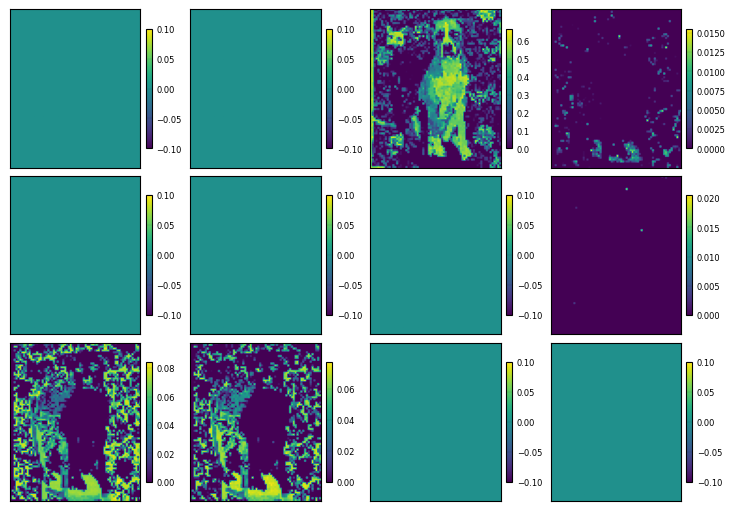

In [46]:
embeddings(encode, shape_=image.shape[0:2], figsize=(15, 5))


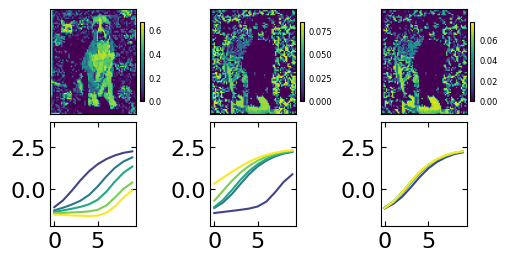

In [47]:
latent_generator(decoder, encode, image, 5, 10, device=device,
                 figsize=(5, 2.5), divider_=False, indx=[2, 8, 9])


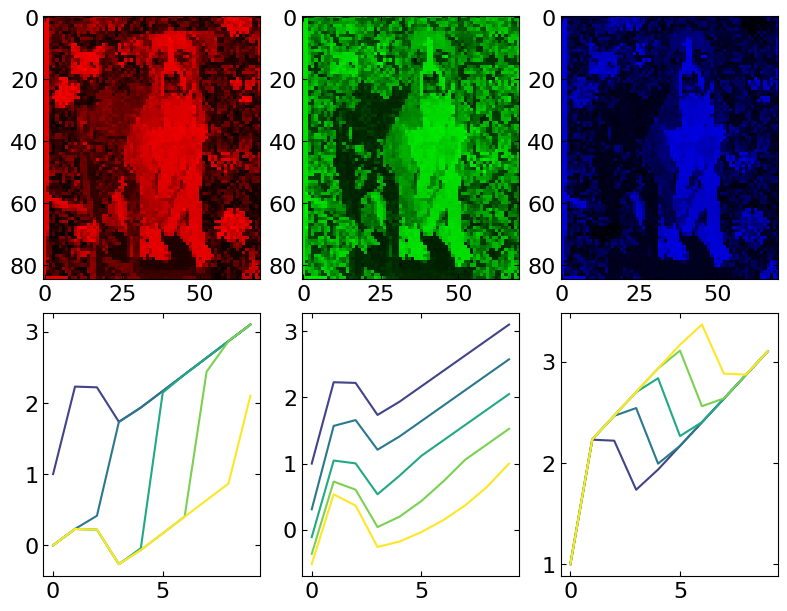

In [48]:
fig, ax = layout_fig(6, mod=3)

ax = ax.ravel()

cmap = plt.cm.viridis

for i, ax in enumerate(ax):
    if i < 3:
        img = np.zeros(image.shape)
        img[:, :, i] = image[:, :, i]
        ax.imshow(img)
    else:
        values = np.zeros((5, 3))
        values[:, i - 3] = np.linspace(0, 1, 5)
        y_data = generate_data(values, length=10)
        for j in range(y_data.shape[0]):
            color = cmap((j + 1) / y_data.shape[0])
            ax.plot(y_data[j], c=color)


In [49]:
from IPython.display import HTML

# Youtube
HTML(
    '<iframe width="560" height="315" src="https://www.youtube.com/embed/ElTwQClLsW0" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)


C:\Users\jca92\.conda\envs\tutorials\lib\site-packages\IPython\core\display.py:419: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [50]:
latent_dim = 12


class Encoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()
        # extracts the mean and standard deviation
        self.mn = nn.Linear(self.latent_dim, self.latent_dim)
        self.sd = nn.Linear(self.latent_dim, self.latent_dim)

    def forward(self, x):
        x, (_, __) = self.lstm(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        x = self.relu(x)
        mn = self.mn(x)
        sd = self.sd(x)
        std = torch.exp(sd * 0.5).cuda()
        eps = torch.normal(0, 1, size=std.size()).cuda()
        out = eps.mul(std).add_(mn).cuda()

        return out, mn, sd


class Decoder(nn.Module):
    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(
            latent_dim, 12, batch_first=True, bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 10, 1])
        x, (_, __) = self.lstm(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [51]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4)


In [52]:
# training with beta regularization scheduling

def Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    epochs,
    coef=0,
    coef_1=0,
    ln_parm=1,
    beta_step_size=0,
    epoch_per_beta=10,
    initial_epochs=10,
    device=device,
    save=False,
):

    N_EPOCHS = epochs
    best_train_loss = float("inf")

    for epoch in range(N_EPOCHS):

        if epoch < initial_epochs:
            # starts training with no VAE regularization
            beta = 0
        else:
            # adds VAE regularization
            beta = ((epoch - initial_epochs) //
                    epoch_per_beta + 1) * beta_step_size

        train_loss = loss_function(
            model,
            encoder,
            decoder,
            train_iterator,
            optimizer,
            coef,
            coef_1,
            ln_parm,
            beta=beta,
            mse=False,
        )

        train_loss /= len(train_iterator)
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(".............................")

        if save:
            if (
                (epoch - initial_epochs) // epoch_per_beta
                == (epoch - initial_epochs) / epoch_per_beta
            ) and (epoch >= initial_epochs):

                best_train_loss = float("inf")

            if best_train_loss > train_loss:
                best_train_loss = train_loss
                patience_counter = 1
                checkpoint = {
                    "net": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": epoch,
                    "encoder": encoder.state_dict(),
                    "decoder": decoder.state_dict(),
                }
                if epoch >= 0:
                    torch.save(
                        checkpoint, f"./test__Train_Loss:{train_loss:.4f}-{epoch}.pkl"
                    )


In [53]:
random_seed(seed=42)

Train(
    model,
    encoder,
    decoder,
    train_iterator,
    optimizer,
    500,
    beta_step_size=0.05,
    epoch_per_beta=100,
    initial_epochs=200,
    device=device,
)


Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 116.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 122.34it/s]

Epoch 0, Train Loss: 1.8868
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 129.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.46it/s]

Epoch 1, Train Loss: 1.8601
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.09it/s]

Epoch 2, Train Loss: 1.8369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.35it/s]

Epoch 3, Train Loss: 1.8194
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.04it/s]

Epoch 4, Train Loss: 1.7971
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.80it/s]

Epoch 5, Train Loss: 1.7614
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.66it/s]

Epoch 6, Train Loss: 1.7277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.49it/s]

Epoch 7, Train Loss: 1.6581
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.27it/s]

Epoch 8, Train Loss: 1.5673
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 158.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.70it/s]

Epoch 9, Train Loss: 1.4347
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.66it/s]

Epoch 10, Train Loss: 1.2674
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.76it/s]

Epoch 11, Train Loss: 1.1148
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.84it/s]

Epoch 12, Train Loss: 0.9595
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.56it/s]

Epoch 13, Train Loss: 0.8134
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.12it/s]

Epoch 14, Train Loss: 0.6702
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.94it/s]

Epoch 15, Train Loss: 0.5385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.08it/s]

Epoch 16, Train Loss: 0.4226
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.89it/s]

Epoch 17, Train Loss: 0.3489
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.94it/s]

Epoch 18, Train Loss: 0.3002
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 154.00it/s]

Epoch 19, Train Loss: 0.2694
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.91it/s]

Epoch 20, Train Loss: 0.2484
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.15it/s]

Epoch 21, Train Loss: 0.2366
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.48it/s]

Epoch 22, Train Loss: 0.2302
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.06it/s]

Epoch 23, Train Loss: 0.2195
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.11it/s]

Epoch 24, Train Loss: 0.2134
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.04it/s]

Epoch 25, Train Loss: 0.2084
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 167.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.62it/s]

Epoch 26, Train Loss: 0.2034
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 146.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.13it/s]

Epoch 27, Train Loss: 0.1974
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.73it/s]

Epoch 28, Train Loss: 0.1946
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.96it/s]

Epoch 29, Train Loss: 0.1912
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.71it/s]

Epoch 30, Train Loss: 0.1883
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.71it/s]

Epoch 31, Train Loss: 0.1846
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.97it/s]

Epoch 32, Train Loss: 0.1818
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.15it/s]

Epoch 33, Train Loss: 0.1795
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.57it/s]

Epoch 34, Train Loss: 0.1763
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.18it/s]

Epoch 35, Train Loss: 0.1745
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.78it/s]

Epoch 36, Train Loss: 0.1719
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.30it/s]

Epoch 37, Train Loss: 0.1700
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.37it/s]

Epoch 38, Train Loss: 0.1682
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.14it/s]

Epoch 39, Train Loss: 0.1660
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.38it/s]

Epoch 40, Train Loss: 0.1636
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.14it/s]

Epoch 41, Train Loss: 0.1618
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.22it/s]

Epoch 42, Train Loss: 0.1596
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.22it/s]

Epoch 43, Train Loss: 0.1581
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.66it/s]

Epoch 44, Train Loss: 0.1561
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.53it/s]

Epoch 45, Train Loss: 0.1540
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.27it/s]

Epoch 46, Train Loss: 0.1523
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 168.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.78it/s]

Epoch 47, Train Loss: 0.1502
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.55it/s]

Epoch 48, Train Loss: 0.1483
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.20it/s]

Epoch 49, Train Loss: 0.1460
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.01it/s]

Epoch 50, Train Loss: 0.1448
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.72it/s]

Epoch 51, Train Loss: 0.1428
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 127.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 122.41it/s]

Epoch 52, Train Loss: 0.1410
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.28it/s]

Epoch 53, Train Loss: 0.1391
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.62it/s]

Epoch 54, Train Loss: 0.1376
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.07it/s]

Epoch 55, Train Loss: 0.1361
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.96it/s]

Epoch 56, Train Loss: 0.1344
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.96it/s]

Epoch 57, Train Loss: 0.1331
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.69it/s]

Epoch 58, Train Loss: 0.1316
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 133.64it/s]

Epoch 59, Train Loss: 0.1302
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.78it/s]

Epoch 60, Train Loss: 0.1289
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.62it/s]

Epoch 61, Train Loss: 0.1276
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.61it/s]

Epoch 62, Train Loss: 0.1266
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.71it/s]

Epoch 63, Train Loss: 0.1255
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.11it/s]

Epoch 64, Train Loss: 0.1247
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.05it/s]

Epoch 65, Train Loss: 0.1233
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.69it/s]

Epoch 66, Train Loss: 0.1224
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.53it/s]

Epoch 67, Train Loss: 0.1214
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.35it/s]

Epoch 68, Train Loss: 0.1204
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 136.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 133.89it/s]

Epoch 69, Train Loss: 0.1196
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.78it/s]

Epoch 70, Train Loss: 0.1191
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.00it/s]

Epoch 71, Train Loss: 0.1180
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.06it/s]

Epoch 72, Train Loss: 0.1171
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.62it/s]

Epoch 73, Train Loss: 0.1162
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.78it/s]

Epoch 74, Train Loss: 0.1157
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.51it/s]

Epoch 75, Train Loss: 0.1146
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 149.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.16it/s]

Epoch 76, Train Loss: 0.1141
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 137.46it/s]

Epoch 77, Train Loss: 0.1135
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.68it/s]

Epoch 78, Train Loss: 0.1125
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 159.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.22it/s]

Epoch 79, Train Loss: 0.1119
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.47it/s]

Epoch 80, Train Loss: 0.1113
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.64it/s]

Epoch 81, Train Loss: 0.1106
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.73it/s]

Epoch 82, Train Loss: 0.1097
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.39it/s]

Epoch 83, Train Loss: 0.1091
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.43it/s]

Epoch 84, Train Loss: 0.1085
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 132.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 137.16it/s]

Epoch 85, Train Loss: 0.1080
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.92it/s]

Epoch 86, Train Loss: 0.1072
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.69it/s]

Epoch 87, Train Loss: 0.1068
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.87it/s]

Epoch 88, Train Loss: 0.1059
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.05it/s]

Epoch 89, Train Loss: 0.1054
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.20it/s]

Epoch 90, Train Loss: 0.1048
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.91it/s]

Epoch 91, Train Loss: 0.1043
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.52it/s]

Epoch 92, Train Loss: 0.1037
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.68it/s]

Epoch 93, Train Loss: 0.1032
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.90it/s]

Epoch 94, Train Loss: 0.1026
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 129.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.60it/s]

Epoch 95, Train Loss: 0.1022
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.15it/s]

Epoch 96, Train Loss: 0.1016
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.29it/s]

Epoch 97, Train Loss: 0.1011
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.05it/s]

Epoch 98, Train Loss: 0.1007
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.11it/s]

Epoch 99, Train Loss: 0.1001
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.77it/s]

Epoch 100, Train Loss: 0.0997
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.67it/s]

Epoch 101, Train Loss: 0.0993
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.02it/s]

Epoch 102, Train Loss: 0.0986
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 139.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.24it/s]

Epoch 103, Train Loss: 0.0983
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.04it/s]

Epoch 104, Train Loss: 0.0976
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.92it/s]

Epoch 105, Train Loss: 0.0971
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.37it/s]

Epoch 106, Train Loss: 0.0966
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.63it/s]

Epoch 107, Train Loss: 0.0960
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.85it/s]

Epoch 108, Train Loss: 0.0958
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.37it/s]

Epoch 109, Train Loss: 0.0949
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 122.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 133.55it/s]

Epoch 110, Train Loss: 0.0945
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 150.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.15it/s]

Epoch 111, Train Loss: 0.0937
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 136.66it/s]

Epoch 112, Train Loss: 0.0931
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 137.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.63it/s]

Epoch 113, Train Loss: 0.0924
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 142.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.97it/s]

Epoch 114, Train Loss: 0.0917
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.98it/s]

Epoch 115, Train Loss: 0.0908
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.26it/s]

Epoch 116, Train Loss: 0.0901
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.13it/s]

Epoch 117, Train Loss: 0.0892
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.21it/s]

Epoch 118, Train Loss: 0.0883
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.92it/s]

Epoch 119, Train Loss: 0.0872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.29it/s]

Epoch 120, Train Loss: 0.0862
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.04it/s]

Epoch 121, Train Loss: 0.0849
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.11it/s]

Epoch 122, Train Loss: 0.0836
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.84it/s]

Epoch 123, Train Loss: 0.0821
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.45it/s]

Epoch 124, Train Loss: 0.0804
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.68it/s]

Epoch 125, Train Loss: 0.0786
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.91it/s]

Epoch 126, Train Loss: 0.0768
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.76it/s]

Epoch 127, Train Loss: 0.0744
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 140.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.88it/s]

Epoch 128, Train Loss: 0.0723
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.97it/s]

Epoch 129, Train Loss: 0.0704
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 154.51it/s]

Epoch 130, Train Loss: 0.0687
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.80it/s]

Epoch 131, Train Loss: 0.0670
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 141.91it/s]

Epoch 132, Train Loss: 0.0653
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.20it/s]

Epoch 133, Train Loss: 0.0638
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 142.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 141.16it/s]

Epoch 134, Train Loss: 0.0623
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 130.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 127.95it/s]

Epoch 135, Train Loss: 0.0611
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.14it/s]

Epoch 136, Train Loss: 0.0600
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.06it/s]

Epoch 137, Train Loss: 0.0588
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.70it/s]

Epoch 138, Train Loss: 0.0578
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.03it/s]

Epoch 139, Train Loss: 0.0569
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.43it/s]

Epoch 140, Train Loss: 0.0560
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.28it/s]

Epoch 141, Train Loss: 0.0549
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.16it/s]

Epoch 142, Train Loss: 0.0541
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.09it/s]

Epoch 143, Train Loss: 0.0533
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.91it/s]

Epoch 144, Train Loss: 0.0526
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.15it/s]

Epoch 145, Train Loss: 0.0518
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.10it/s]

Epoch 146, Train Loss: 0.0512
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.84it/s]

Epoch 147, Train Loss: 0.0504
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.45it/s]

Epoch 148, Train Loss: 0.0497
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.33it/s]

Epoch 149, Train Loss: 0.0489
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.60it/s]

Epoch 150, Train Loss: 0.0482
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.14it/s]

Epoch 151, Train Loss: 0.0477
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 130.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.67it/s]

Epoch 152, Train Loss: 0.0471
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 136.30it/s]

Epoch 153, Train Loss: 0.0466
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 154.38it/s]

Epoch 154, Train Loss: 0.0461
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.69it/s]

Epoch 155, Train Loss: 0.0454
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.91it/s]

Epoch 156, Train Loss: 0.0450
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.55it/s]

Epoch 157, Train Loss: 0.0443
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.83it/s]

Epoch 158, Train Loss: 0.0438
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.49it/s]

Epoch 159, Train Loss: 0.0433
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 137.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.68it/s]

Epoch 160, Train Loss: 0.0428
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.92it/s]

Epoch 161, Train Loss: 0.0423
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.07it/s]

Epoch 162, Train Loss: 0.0419
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.38it/s]

Epoch 163, Train Loss: 0.0412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.47it/s]

Epoch 164, Train Loss: 0.0408
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.29it/s]

Epoch 165, Train Loss: 0.0404
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.54it/s]

Epoch 166, Train Loss: 0.0400
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.54it/s]

Epoch 167, Train Loss: 0.0396
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.97it/s]

Epoch 168, Train Loss: 0.0392
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.87it/s]

Epoch 169, Train Loss: 0.0385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.17it/s]

Epoch 170, Train Loss: 0.0380
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.88it/s]

Epoch 171, Train Loss: 0.0377
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.81it/s]

Epoch 172, Train Loss: 0.0371
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.05it/s]

Epoch 173, Train Loss: 0.0369
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 178.96it/s]

Epoch 174, Train Loss: 0.0365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.71it/s]

Epoch 175, Train Loss: 0.0360
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.64it/s]

Epoch 176, Train Loss: 0.0356
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.45it/s]

Epoch 177, Train Loss: 0.0351
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 181.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.30it/s]

Epoch 178, Train Loss: 0.0346
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.18it/s]

Epoch 179, Train Loss: 0.0343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.64it/s]

Epoch 180, Train Loss: 0.0338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.95it/s]

Epoch 181, Train Loss: 0.0335
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.54it/s]

Epoch 182, Train Loss: 0.0331
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.93it/s]

Epoch 183, Train Loss: 0.0326
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.16it/s]

Epoch 184, Train Loss: 0.0323
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 185, Train Loss: 0.0317
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 168.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.89it/s]

Epoch 186, Train Loss: 0.0313
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.90it/s]

Epoch 187, Train Loss: 0.0310
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 157.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.18it/s]

Epoch 188, Train Loss: 0.0304
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.37it/s]

Epoch 189, Train Loss: 0.0299
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 149.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.33it/s]

Epoch 190, Train Loss: 0.0294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.53it/s]

Epoch 191, Train Loss: 0.0288
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 130.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 127.42it/s]

Epoch 192, Train Loss: 0.0283
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 138.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 137.46it/s]

Epoch 193, Train Loss: 0.0277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.13it/s]

Epoch 194, Train Loss: 0.0272
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.01it/s]

Epoch 195, Train Loss: 0.0269
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.04it/s]

Epoch 196, Train Loss: 0.0263
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 139.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.94it/s]

Epoch 197, Train Loss: 0.0259
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.76it/s]

Epoch 198, Train Loss: 0.0255
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.31it/s]

Epoch 199, Train Loss: 0.0252
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 132.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 129.21it/s]

Epoch 200, Train Loss: 2.6322
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.92it/s]

Epoch 201, Train Loss: 1.1233
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.29it/s]

Epoch 202, Train Loss: 0.7742
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.99it/s]

Epoch 203, Train Loss: 0.6060
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 169.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.13it/s]

Epoch 204, Train Loss: 0.5094
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 154.96it/s]

Epoch 205, Train Loss: 0.4462
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.08it/s]

Epoch 206, Train Loss: 0.4063
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.52it/s]

Epoch 207, Train Loss: 0.3747
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.60it/s]

Epoch 208, Train Loss: 0.3496
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.63it/s]

Epoch 209, Train Loss: 0.3333
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.17it/s]

Epoch 210, Train Loss: 0.3203
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.68it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.39it/s]

Epoch 211, Train Loss: 0.3077
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.15it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.41it/s]

Epoch 212, Train Loss: 0.3000
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.32it/s]

Epoch 213, Train Loss: 0.2910
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.18it/s]

Epoch 214, Train Loss: 0.2819
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.13it/s]

Epoch 215, Train Loss: 0.2749
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.91it/s]

Epoch 216, Train Loss: 0.2684
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.21it/s]

Epoch 217, Train Loss: 0.2664
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 118.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 123.45it/s]

Epoch 218, Train Loss: 0.2622
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.43it/s]

Epoch 219, Train Loss: 0.2600
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.44it/s]

Epoch 220, Train Loss: 0.2551
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 182.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.47it/s]

Epoch 221, Train Loss: 0.2516
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 159.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.27it/s]

Epoch 222, Train Loss: 0.2482
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.51it/s]

Epoch 223, Train Loss: 0.2441
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.20it/s]

Epoch 224, Train Loss: 0.2412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.94it/s]

Epoch 225, Train Loss: 0.2382
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.11it/s]

Epoch 226, Train Loss: 0.2361
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.86it/s]

Epoch 227, Train Loss: 0.2343
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.31it/s]

Epoch 228, Train Loss: 0.2323
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 185.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.00it/s]

Epoch 229, Train Loss: 0.2304
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.01it/s]

Epoch 230, Train Loss: 0.2305
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.48it/s]

Epoch 231, Train Loss: 0.2264
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.08it/s]

Epoch 232, Train Loss: 0.2256
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.28it/s]

Epoch 233, Train Loss: 0.2229
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.65it/s]

Epoch 234, Train Loss: 0.2220
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.39it/s]

Epoch 235, Train Loss: 0.2192
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.50it/s]

Epoch 236, Train Loss: 0.2173
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 179.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.57it/s]

Epoch 237, Train Loss: 0.2159
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.33it/s]

Epoch 238, Train Loss: 0.2162
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.48it/s]

Epoch 239, Train Loss: 0.2119
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.52it/s]

Epoch 240, Train Loss: 0.2105
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.64it/s]

Epoch 241, Train Loss: 0.2092
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.46it/s]

Epoch 242, Train Loss: 0.2083
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 132.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 131.92it/s]

Epoch 243, Train Loss: 0.2080
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.36it/s]

Epoch 244, Train Loss: 0.2048
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.03it/s]

Epoch 245, Train Loss: 0.2044
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 176.29it/s]

Epoch 246, Train Loss: 0.1998
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.51it/s]

Epoch 247, Train Loss: 0.1961
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.89it/s]

Epoch 248, Train Loss: 0.1948
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 176.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.93it/s]

Epoch 249, Train Loss: 0.1931
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.47it/s]

Epoch 250, Train Loss: 0.1918
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 154.91it/s]

Epoch 251, Train Loss: 0.1872
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.89it/s]

Epoch 252, Train Loss: 0.1866
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 139.26it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.42it/s]

Epoch 253, Train Loss: 0.1848
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.56it/s]

Epoch 254, Train Loss: 0.1814
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.14it/s]

Epoch 255, Train Loss: 0.1800
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 146.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.61it/s]

Epoch 256, Train Loss: 0.1773
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.09it/s]

Epoch 257, Train Loss: 0.1760
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.16it/s]

Epoch 258, Train Loss: 0.1761
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 136.71it/s]

Epoch 259, Train Loss: 0.1731
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.40it/s]

Epoch 260, Train Loss: 0.1726
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.16it/s]

Epoch 261, Train Loss: 0.1695
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.72it/s]

Epoch 262, Train Loss: 0.1688
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 149.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.63it/s]

Epoch 263, Train Loss: 0.1689
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.18it/s]

Epoch 264, Train Loss: 0.1662
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.94it/s]

Epoch 265, Train Loss: 0.1656
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.90it/s]

Epoch 266, Train Loss: 0.1650
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 146.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 141.35it/s]

Epoch 267, Train Loss: 0.1628
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.50it/s]

Epoch 268, Train Loss: 0.1596
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.59it/s]

Epoch 269, Train Loss: 0.1605
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 151.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.34it/s]

Epoch 270, Train Loss: 0.1604
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 138.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.02it/s]

Epoch 271, Train Loss: 0.1586
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 128.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.70it/s]

Epoch 272, Train Loss: 0.1576
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 131.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 133.63it/s]

Epoch 273, Train Loss: 0.1574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 129.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 127.51it/s]

Epoch 274, Train Loss: 0.1551
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.11it/s]

Epoch 275, Train Loss: 0.1546
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 141.94it/s]

Epoch 276, Train Loss: 0.1519
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.95it/s]

Epoch 277, Train Loss: 0.1517
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 112.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 109.31it/s]

Epoch 278, Train Loss: 0.1516
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 125.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 127.87it/s]

Epoch 279, Train Loss: 0.1505
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 116.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 112.57it/s]

Epoch 280, Train Loss: 0.1487
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████▍                                                               | 11/19 [00:00<00:00, 105.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 112.33it/s]

Epoch 281, Train Loss: 0.1471
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                        | 10/19 [00:00<00:00, 95.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 114.20it/s]

Epoch 282, Train Loss: 0.1471
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.20it/s]

Epoch 283, Train Loss: 0.1454
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 128.96it/s]

Epoch 284, Train Loss: 0.1456
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.16it/s]

Epoch 285, Train Loss: 0.1456
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.58it/s]

Epoch 286, Train Loss: 0.1437
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 125.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.76it/s]

Epoch 287, Train Loss: 0.1445
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 112.37it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 108.05it/s]

Epoch 288, Train Loss: 0.1416
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.71it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 137.46it/s]

Epoch 289, Train Loss: 0.1420
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 127.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 121.06it/s]

Epoch 290, Train Loss: 0.1412
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 128.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.60it/s]

Epoch 291, Train Loss: 0.1399
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.94it/s]

Epoch 292, Train Loss: 0.1397
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.28it/s]

Epoch 293, Train Loss: 0.1396
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 136.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.00it/s]

Epoch 294, Train Loss: 0.1387
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 124.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 113.16it/s]

Epoch 295, Train Loss: 0.1358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 146.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.97it/s]

Epoch 296, Train Loss: 0.1365
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 124.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.36it/s]

Epoch 297, Train Loss: 0.1358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.74it/s]

Epoch 298, Train Loss: 0.1359
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.53it/s]

Epoch 299, Train Loss: 0.1344
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.89it/s]

Epoch 300, Train Loss: 0.1889
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.27it/s]

Epoch 301, Train Loss: 0.1851
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.82it/s]

Epoch 302, Train Loss: 0.1802
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.88it/s]

Epoch 303, Train Loss: 0.1783
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.67it/s]

Epoch 304, Train Loss: 0.1761
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.61it/s]

Epoch 305, Train Loss: 0.1763
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 139.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 136.15it/s]

Epoch 306, Train Loss: 0.1758
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.13it/s]

Epoch 307, Train Loss: 0.1750
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.38it/s]

Epoch 308, Train Loss: 0.1740
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.18it/s]

Epoch 309, Train Loss: 0.1726
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.39it/s]

Epoch 310, Train Loss: 0.1718
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.26it/s]

Epoch 311, Train Loss: 0.1701
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.71it/s]

Epoch 312, Train Loss: 0.1695
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.46it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.35it/s]

Epoch 313, Train Loss: 0.1697
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.46it/s]

Epoch 314, Train Loss: 0.1684
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.40it/s]

Epoch 315, Train Loss: 0.1692
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.99it/s]

Epoch 316, Train Loss: 0.1662
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.08it/s]

Epoch 317, Train Loss: 0.1671
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.57it/s]

Epoch 318, Train Loss: 0.1658
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 136.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.28it/s]

Epoch 319, Train Loss: 0.1656
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.84it/s]

Epoch 320, Train Loss: 0.1645
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.38it/s]

Epoch 321, Train Loss: 0.1632
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.54it/s]

Epoch 322, Train Loss: 0.1640
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.11it/s]

Epoch 323, Train Loss: 0.1643
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.10it/s]

Epoch 324, Train Loss: 0.1619
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.13it/s]

Epoch 325, Train Loss: 0.1622
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.79it/s]

Epoch 326, Train Loss: 0.1604
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 139.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.02it/s]

Epoch 327, Train Loss: 0.1609
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.50it/s]

Epoch 328, Train Loss: 0.1578
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.54it/s]

Epoch 329, Train Loss: 0.1584
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 146.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.05it/s]

Epoch 330, Train Loss: 0.1570
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 128.79it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 131.93it/s]

Epoch 331, Train Loss: 0.1574
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.76it/s]

Epoch 332, Train Loss: 0.1589
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.10it/s]

Epoch 333, Train Loss: 0.1566
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.52it/s]

Epoch 334, Train Loss: 0.1547
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.24it/s]

Epoch 335, Train Loss: 0.1551
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 132.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.74it/s]

Epoch 336, Train Loss: 0.1538
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.52it/s]

Epoch 337, Train Loss: 0.1532
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.68it/s]

Epoch 338, Train Loss: 0.1512
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 186.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 184.28it/s]

Epoch 339, Train Loss: 0.1527
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.55it/s]

Epoch 340, Train Loss: 0.1517
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 183.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 180.80it/s]

Epoch 341, Train Loss: 0.1502
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.28it/s]

Epoch 342, Train Loss: 0.1514
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.49it/s]

Epoch 343, Train Loss: 0.1496
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.79it/s]

Epoch 344, Train Loss: 0.1487
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.12it/s]

Epoch 345, Train Loss: 0.1490
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 129.36it/s]

Epoch 346, Train Loss: 0.1486
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.42it/s]

Epoch 347, Train Loss: 0.1487
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.55it/s]

Epoch 348, Train Loss: 0.1464
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 171.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.66it/s]

Epoch 349, Train Loss: 0.1461
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.75it/s]

Epoch 350, Train Loss: 0.1442
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 142.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.17it/s]

Epoch 351, Train Loss: 0.1460
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 168.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.67it/s]

Epoch 352, Train Loss: 0.1443
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 139.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.94it/s]

Epoch 353, Train Loss: 0.1434
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.95it/s]

Epoch 354, Train Loss: 0.1424
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 169.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.49it/s]

Epoch 355, Train Loss: 0.1425
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 179.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.26it/s]

Epoch 356, Train Loss: 0.1416
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.67it/s]

Epoch 357, Train Loss: 0.1415
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.28it/s]

Epoch 358, Train Loss: 0.1415
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 149.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.70it/s]

Epoch 359, Train Loss: 0.1396
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.01it/s]

Epoch 360, Train Loss: 0.1393
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 136.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 140.46it/s]

Epoch 361, Train Loss: 0.1385
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.15it/s]

Epoch 362, Train Loss: 0.1380
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.31it/s]

Epoch 363, Train Loss: 0.1375
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.58it/s]

Epoch 364, Train Loss: 0.1375
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.48it/s]

Epoch 365, Train Loss: 0.1364
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.35it/s]

Epoch 366, Train Loss: 0.1376
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.06it/s]

Epoch 367, Train Loss: 0.1352
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.23it/s]

Epoch 368, Train Loss: 0.1359
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.47it/s]

Epoch 369, Train Loss: 0.1349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.98it/s]

Epoch 370, Train Loss: 0.1338
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.03it/s]

Epoch 371, Train Loss: 0.1351
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.25it/s]

Epoch 372, Train Loss: 0.1314
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 166.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.32it/s]

Epoch 373, Train Loss: 0.1329
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 171.82it/s]

Epoch 374, Train Loss: 0.1301
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.55it/s]

Epoch 375, Train Loss: 0.1310
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.35it/s]

Epoch 376, Train Loss: 0.1290
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.40it/s]

Epoch 377, Train Loss: 0.1294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 125.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 127.62it/s]

Epoch 378, Train Loss: 0.1295
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.42it/s]

Epoch 379, Train Loss: 0.1274
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 149.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.97it/s]

Epoch 380, Train Loss: 0.1273
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 137.50it/s]

Epoch 381, Train Loss: 0.1273
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 131.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 129.20it/s]

Epoch 382, Train Loss: 0.1276
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.96it/s]

Epoch 383, Train Loss: 0.1254
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 130.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.64it/s]

Epoch 384, Train Loss: 0.1260
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.61it/s]

Epoch 385, Train Loss: 0.1256
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 138.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.93it/s]

Epoch 386, Train Loss: 0.1243
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.40it/s]

Epoch 387, Train Loss: 0.1237
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.41it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.48it/s]

Epoch 388, Train Loss: 0.1233
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 156.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.45it/s]

Epoch 389, Train Loss: 0.1233
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 134.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 137.48it/s]

Epoch 390, Train Loss: 0.1211
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.44it/s]

Epoch 391, Train Loss: 0.1215
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.48it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 135.33it/s]

Epoch 392, Train Loss: 0.1209
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.78it/s]

Epoch 393, Train Loss: 0.1209
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.65it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.44it/s]

Epoch 394, Train Loss: 0.1203
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 154.82it/s]

Epoch 395, Train Loss: 0.1189
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 119.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 122.39it/s]

Epoch 396, Train Loss: 0.1182
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 160.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.29it/s]

Epoch 397, Train Loss: 0.1194
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 157.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.34it/s]

Epoch 398, Train Loss: 0.1184
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 168.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.79it/s]

Epoch 399, Train Loss: 0.1178
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 128.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 125.73it/s]

Epoch 400, Train Loss: 0.1453
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.00it/s]

Epoch 401, Train Loss: 0.1418
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.14it/s]

Epoch 402, Train Loss: 0.1407
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.73it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 168.62it/s]

Epoch 403, Train Loss: 0.1399
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.68it/s]

Epoch 404, Train Loss: 0.1398
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.87it/s]

Epoch 405, Train Loss: 0.1390
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.08it/s]

Epoch 406, Train Loss: 0.1379
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.68it/s]

Epoch 407, Train Loss: 0.1374
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 150.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.96it/s]

Epoch 408, Train Loss: 0.1377
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 137.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 134.84it/s]

Epoch 409, Train Loss: 0.1362
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.07it/s]

Epoch 410, Train Loss: 0.1358
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.83it/s]

Epoch 411, Train Loss: 0.1376
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.78it/s]

Epoch 412, Train Loss: 0.1349
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.15it/s]

Epoch 413, Train Loss: 0.1341
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.73it/s]

Epoch 414, Train Loss: 0.1340
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 173.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.52it/s]

Epoch 415, Train Loss: 0.1327
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.34it/s]

Epoch 416, Train Loss: 0.1327
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 133.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 130.90it/s]

Epoch 417, Train Loss: 0.1319
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.34it/s]

Epoch 418, Train Loss: 0.1308
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.06it/s]

Epoch 419, Train Loss: 0.1303
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 167.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.18it/s]

Epoch 420, Train Loss: 0.1304
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.27it/s]

Epoch 421, Train Loss: 0.1294
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.60it/s]

Epoch 422, Train Loss: 0.1295
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.24it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 175.95it/s]

Epoch 423, Train Loss: 0.1284
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 137.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 131.03it/s]

Epoch 424, Train Loss: 0.1274
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.70it/s]

Epoch 425, Train Loss: 0.1277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.49it/s]

Epoch 426, Train Loss: 0.1295
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.70it/s]

Epoch 427, Train Loss: 0.1276
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.84it/s]

Epoch 428, Train Loss: 0.1283
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.38it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.77it/s]

Epoch 429, Train Loss: 0.1277
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.56it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 172.55it/s]

Epoch 430, Train Loss: 0.1253
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 158.78it/s]

Epoch 431, Train Loss: 0.1275
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.62it/s]

Epoch 432, Train Loss: 0.1258
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 136.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 136.42it/s]

Epoch 433, Train Loss: 0.1272
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 177.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 177.33it/s]

Epoch 434, Train Loss: 0.1242
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.91it/s]

Epoch 435, Train Loss: 0.1248
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 145.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.59it/s]

Epoch 436, Train Loss: 0.1238
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 140.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.80it/s]

Epoch 437, Train Loss: 0.1249
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 162.40it/s]

Epoch 438, Train Loss: 0.1244
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.48it/s]

Epoch 439, Train Loss: 0.1226
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 139.62it/s]

Epoch 440, Train Loss: 0.1243
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 140.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.95it/s]

Epoch 441, Train Loss: 0.1234
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 169.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 167.85it/s]

Epoch 442, Train Loss: 0.1216
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 156.97it/s]

Epoch 443, Train Loss: 0.1218
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 162.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.51it/s]

Epoch 444, Train Loss: 0.1216
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 125.06it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 116.27it/s]

Epoch 445, Train Loss: 0.1222
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 47%|████████████████████████████████████████████████████████████████████████▍                                                                                | 9/19 [00:00<00:00, 80.81it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 90.92it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 88.51it/s]

Epoch 446, Train Loss: 0.1210
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 53%|████████████████████████████████████████████████████████████████████████████████                                                                        | 10/19 [00:00<00:00, 93.89it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 95.27it/s]

Epoch 447, Train Loss: 0.1207
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 116.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 116.92it/s]

Epoch 448, Train Loss: 0.1216
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 126.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 123.78it/s]

Epoch 449, Train Loss: 0.1206
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 148.59it/s]

Epoch 450, Train Loss: 0.1197
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 165.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.26it/s]

Epoch 451, Train Loss: 0.1203
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.46it/s]

Epoch 452, Train Loss: 0.1195
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 140.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.25it/s]

Epoch 453, Train Loss: 0.1200
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 148.12it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 151.46it/s]

Epoch 454, Train Loss: 0.1187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 149.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.14it/s]

Epoch 455, Train Loss: 0.1174
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 12/19 [00:00<00:00, 116.30it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 120.17it/s]

Epoch 456, Train Loss: 0.1200
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 163.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 161.13it/s]

Epoch 457, Train Loss: 0.1187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.05it/s]

Epoch 458, Train Loss: 0.1188
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 175.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.66it/s]

Epoch 459, Train Loss: 0.1187
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 174.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 173.83it/s]

Epoch 460, Train Loss: 0.1184
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 142.99it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.38it/s]

Epoch 461, Train Loss: 0.1176
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 13/19 [00:00<00:00, 127.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 128.98it/s]

Epoch 462, Train Loss: 0.1177
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.67it/s]

Epoch 463, Train Loss: 0.1186
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 164.54it/s]

Epoch 464, Train Loss: 0.1171
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.07it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.34it/s]

Epoch 465, Train Loss: 0.1169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.92it/s]

Epoch 466, Train Loss: 0.1157
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 172.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.33it/s]

Epoch 467, Train Loss: 0.1169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 178.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 174.93it/s]

Epoch 468, Train Loss: 0.1163
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.94it/s]

Epoch 469, Train Loss: 0.1165
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.29it/s]

Epoch 470, Train Loss: 0.1167
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 168.76it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 165.16it/s]

Epoch 471, Train Loss: 0.1170
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 149.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.86it/s]

Epoch 472, Train Loss: 0.1149
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 150.60it/s]

Epoch 473, Train Loss: 0.1152
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.81it/s]

Epoch 474, Train Loss: 0.1169
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 164.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 160.88it/s]

Epoch 475, Train Loss: 0.1158
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 169.80it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 169.60it/s]

Epoch 476, Train Loss: 0.1148
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 167.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.21it/s]

Epoch 477, Train Loss: 0.1152
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 155.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 152.47it/s]

Epoch 478, Train Loss: 0.1152
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 163.26it/s]

Epoch 479, Train Loss: 0.1147
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.13it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.08it/s]

Epoch 480, Train Loss: 0.1143
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 144.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 147.12it/s]

Epoch 481, Train Loss: 0.1151
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 153.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 149.16it/s]

Epoch 482, Train Loss: 0.1133
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 166.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 166.17it/s]

Epoch 483, Train Loss: 0.1152
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 18/19 [00:00<00:00, 170.44it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 170.29it/s]

Epoch 484, Train Loss: 0.1144
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 159.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.48it/s]

Epoch 485, Train Loss: 0.1143
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 139.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.39it/s]

Epoch 486, Train Loss: 0.1132
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 153.97it/s]

Epoch 487, Train Loss: 0.1149
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 17/19 [00:00<00:00, 161.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 157.48it/s]

Epoch 488, Train Loss: 0.1129
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 147.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 145.22it/s]

Epoch 489, Train Loss: 0.1128
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 143.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 131.32it/s]

Epoch 490, Train Loss: 0.1124
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 158.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 159.42it/s]

Epoch 491, Train Loss: 0.1123
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 141.47it/s]

Epoch 492, Train Loss: 0.1129
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 15/19 [00:00<00:00, 141.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138.54it/s]

Epoch 493, Train Loss: 0.1128
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 139.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 144.23it/s]

Epoch 494, Train Loss: 0.1122
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 136.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 132.41it/s]

Epoch 495, Train Loss: 0.1129
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 148.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 146.28it/s]

Epoch 496, Train Loss: 0.1124
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 152.95it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 142.83it/s]

Epoch 497, Train Loss: 0.1126
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/19 [00:00<00:00, 154.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 155.87it/s]

Epoch 498, Train Loss: 0.1108
.............................


  0%|                                                                                                                                                                 | 0/19 [00:00<?, ?it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 14/19 [00:00<00:00, 135.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 143.80it/s]

Epoch 499, Train Loss: 0.1119
.............................


In [54]:
encoded_spectra, mn, sd = encoder(
    torch.tensor(np.atleast_3d(dog_data), dtype=torch.float32).to(device)
)
decoded_spectra = decoder(encoded_spectra)


In [55]:
encoded_spectra = encoded_spectra.to("cpu")
encoded_spectra = encoded_spectra.detach().numpy()
decoded_spectra = decoded_spectra.to("cpu")
decoded_spectra = decoded_spectra.detach().numpy()


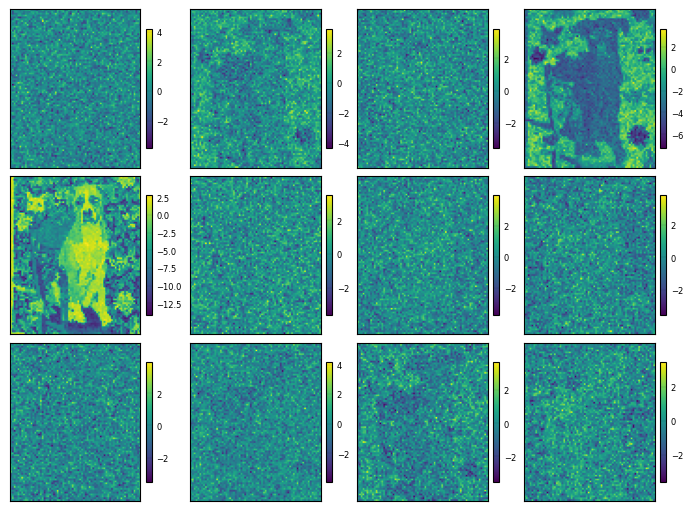

In [56]:
embeddings(encoded_spectra, shape_=image.shape[0:2], figsize=(15, 5))


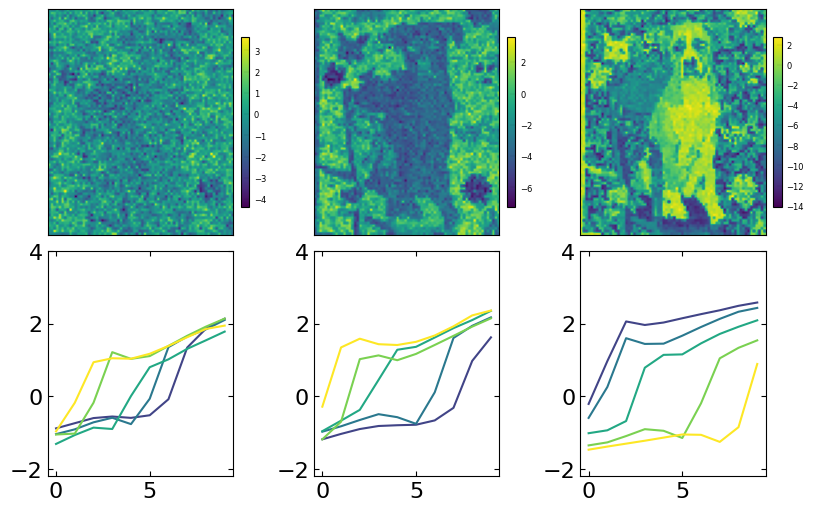

In [57]:
latent_generator(decoder, encoded_spectra, image, 5, 10,
                 device=device, figsize=(15, 5), divider_=False, indx=[1, 3, 4])
